In [1]:
pip install lazypredict

     ---------------------------------------- 0.0/63.5 kB ? eta -:--:--
     ------ --------------------------------- 10.2/63.5 kB ? eta -:--:--
     ------------------ ------------------- 30.7/63.5 kB 435.7 kB/s eta 0:00:01
     ------------------------ ------------- 41.0/63.5 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 63.5/63.5 kB 425.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/28.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/28.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/28.2 MB 660.6 kB/s eta 0:00:43
   ---------------------------------------- 0.0/28.2 MB 393.8 kB/s eta 0:01:12
   ---------------------------------------- 0.0/28.2 MB 393.8 kB/s eta 0:01:12
   ---------------------------------------- 0.0/28.2 MB 393.8 kB/s eta 0:01:12
   ---------------------------------------- 0.1/28.2 MB 435.7 kB/s eta 0:01:05
   ---------------------------------------- 0.1/28.2 MB 379.3 kB/s eta 0:01:15
 

In [3]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [31]:
import argparse
import pandas as pd
import numpy as np
import joblib
import os
import sys
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.AtomPairs import Pairs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
# 导入 LazyPredict
from lazypredict.Supervised import LazyRegressor


def calculate_fingerprints(smiles, fp_type='AtomPair'):
    """计算分子指纹或描述符
    
    参数:
        smiles (str): 分子SMILES表示
        fp_type (str): 指纹类型，可以是'AtomPair'或'RDKit'
        
    返回:
        numpy.ndarray: 分子指纹向量或描述符向量
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    if fp_type == 'AtomPair':
        # 修复: 使用正确的函数获取原子对指纹
        fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=2048)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    elif fp_type == 'RDKit':
        # 计算RDKit分子描述符
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        descriptors = calc.CalcDescriptors(mol)
        return np.array(descriptors)
    else:
        raise ValueError(f"不支持的指纹类型: {fp_type}")


def preprocess_data(data_path, fp_type='AtomPair'):
    """预处理数据集
    
    参数:
        data_path (str): 数据文件路径
        fp_type (str): 指纹类型
        
    返回:
        tuple: (X, y) 特征矩阵和目标变量
    """
    # 读取CSV文件
    df = pd.read_csv(data_path)
    
    # 检查必要的列
    if 'Smiles' not in df.columns:
        raise ValueError("数据集必须包含'Smiles'列")
    if 'pIC50' not in df.columns:
        raise ValueError("数据集必须包含'pIC50'列")
    
    # 计算分子指纹
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(df['Smiles']):
        fp = calculate_fingerprints(smiles, fp_type)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
    
    # 创建特征矩阵和目标变量
    X = np.array(fps)
    y = df.loc[valid_indices, 'pIC50'].values
    
    # 处理特殊情况：RDKit描述符可能包含NaN值
    if fp_type == 'RDKit':
        # 替换NaN值为0
        X = np.nan_to_num(X)
    
    return X, y


def train_model(fp_type='AtomPair', input_path=None, output_dir=None):
    """训练模型
    
    参数:
        fp_type (str): 指纹类型
        input_path (str): 输入数据文件路径
        output_dir (str): 模型输出目录
    
    返回:
        dict: 包含模型性能评估结果的字典
    """
    print(f"\n{'='*60}")
    print(f"开始使用 {fp_type} 特征进行模型训练与评估")
    print(f"{'='*60}")
    
    # 预处理数据
    X, y = preprocess_data(input_path, fp_type)
    
    print(f"使用 {fp_type} 特征，特征维度: {X.shape[1]}")
    
    # 标准化特征 - 修复：添加特征标准化步骤
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    print("开始使用LazyPredict评估多种模型性能...")
    # 使用LazyPredict评估多种回归模型
    reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
    
    try:
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        
        # 修复: 过滤掉性能不合理的模型
        valid_models = models[(models['R-Squared'] <= 1.0) & (models['R-Squared'] >= -1.0)]
        
        if valid_models.empty:
            print("警告: LazyRegressor返回的模型性能不合理，将使用自定义评估方法...")
            valid_models = None
        else:
            # 打印模型性能评估结果
            print(f"\n{fp_type} 特征 - 多种回归模型性能比较:")
            print(valid_models)
            
            # 保存模型评估结果
            models_csv_path = os.path.join(output_dir, f"model_comparison_{fp_type}.csv")
            valid_models.to_csv(models_csv_path)
            print(f"模型比较结果已保存到: {models_csv_path}")
    except Exception as e:
        print(f"LazyRegressor评估失败: {str(e)}，将使用自定义评估方法...")
        valid_models = None
    
    # 修复: 如果LazyRegressor失败，使用自定义评估方法
    if valid_models is None or valid_models.empty:
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
        from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
        from sklearn.svm import SVR
        
        # 定义要评估的模型
        models_to_evaluate = {
            'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
            'Ridge': Ridge(random_state=42),
            'Lasso': Lasso(random_state=42),
            'ElasticNet': ElasticNet(random_state=42),
            'SVR': SVR(),
            'LinearRegression': LinearRegression()
        }
        
        # 评估每个模型
        results = []
        for name, model in models_to_evaluate.items():
            # 使用交叉验证评估
            cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
            
            # 在整个训练集上训练模型并评估测试集性能
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            results.append({
                'Model': name,
                'R-Squared': r2,
                'RMSE': rmse,
                'CV R-Squared': np.mean(cv_scores)
            })
        
        # 创建DataFrame并按R²排序
        valid_models = pd.DataFrame(results).sort_values('R-Squared', ascending=False)
        
        print(f"\n{fp_type} 特征 - 多种回归模型性能比较 (自定义评估):")
        print(valid_models)
        
        # 保存模型评估结果
        models_csv_path = os.path.join(output_dir, f"model_comparison_{fp_type}.csv")
        valid_models.to_csv(models_csv_path)
        print(f"模型比较结果已保存到: {models_csv_path}")
    
    # 找出表现最好的模型（以R²为标准）
    best_model_name = valid_models.index[0] if isinstance(valid_models.index[0], str) else valid_models['Model'].iloc[0]
    print(f"\n根据R²评分，表现最好的模型是: {best_model_name}")
    
    # 选择表现最好的模型
    from sklearn.utils import all_estimators
    from sklearn.ensemble import RandomForestRegressor  # 导入用于回退的模型
    
    all_reg = dict(all_estimators(type_filter='regressor'))
    
    try:
        # 尝试使用表现最好的模型
        BestModel = all_reg.get(best_model_name)
        if BestModel is None:
            # 处理LazyRegressor可能返回的非标准模型名称
            if 'RandomForest' in best_model_name:
                BestModel = RandomForestRegressor
            elif 'GradientBoosting' in best_model_name:
                from sklearn.ensemble import GradientBoostingRegressor
                BestModel = GradientBoostingRegressor
            elif 'Ridge' in best_model_name and 'CV' not in best_model_name:
                from sklearn.linear_model import Ridge
                BestModel = Ridge
            else:
                # 默认回退到RandomForest
                BestModel = RandomForestRegressor
                print(f"无法识别模型 {best_model_name}，回退到RandomForest...")
        
        best_model = BestModel(random_state=42)
        print(f"使用{best_model.__class__.__name__}作为最终模型进行训练...")
    except Exception as e:
        # 如果找不到最佳模型或出错，回退到RandomForest
        print(f"初始化最佳模型时出错: {str(e)}，回退到RandomForest...")
        best_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # 使用最佳模型在完整训练集上训练
    best_model.fit(X_train, y_train)
    
    # 评估最佳模型
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{fp_type} 特征 - 最终模型性能评估:")
    print(f"R² 分数: {r2:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")
    
    # 保存模型和缩放器
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    model_path = os.path.join(output_dir, f"best_model_{fp_type}.pkl")
    scaler_path = os.path.join(output_dir, f"scaler_{fp_type}.pkl")
    meta_path = os.path.join(output_dir, f"meta_{fp_type}.pkl")
    
    joblib.dump(best_model, model_path)
    joblib.dump(scaler, scaler_path)
    
    # 保存元数据
    meta = {
        'fp_type': fp_type,
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'model_path': model_path,
        'scaler_path': scaler_path,
        'feature_dimension': X.shape[1]
    }
    joblib.dump(meta, meta_path)
    
    print(f"最佳模型已保存到: {model_path}")
    print(f"特征缩放器已保存到: {scaler_path}")
    print(f"元数据已保存到: {meta_path}")
    
    # 可视化模型性能比较
    try:
        # 获取前15个模型进行可视化
        if isinstance(valid_models.index[0], str):
            top_models = valid_models.head(15)
            model_names = top_models.index
            r2_values = top_models['R-Squared']
        else:
            top_models = valid_models.head(15)
            model_names = top_models['Model']
            r2_values = top_models['R-Squared']
        
        plt.figure(figsize=(12, 8))
        plt.barh(model_names, r2_values)
        plt.xlabel('R² 分数')
        plt.title(f'{fp_type} 特征 - 回归模型性能比较 (R²)')
        plt.tight_layout()
        
        # 保存图表
        fig_path = os.path.join(output_dir, f"model_comparison_{fp_type}.png")
        plt.savefig(fig_path)
        plt.close()
        print(f"模型比较图表已保存到: {fig_path}")
        
        # 可视化特征重要性（如果模型支持的话）
        if hasattr(best_model, 'feature_importances_'):
            # 计算特征重要性
            importances = best_model.feature_importances_
            
            # 创建DataFrame来存储重要性
            if fp_type == 'RDKit':
                # 对于RDKit描述符，使用描述符名称
                feature_names = [x[0] for x in Descriptors._descList]
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importances
                })
            else:
                # 对于指纹，使用索引
                importance_df = pd.DataFrame({
                    'Feature': [f'Bit_{i}' for i in range(len(importances))],
                    'Importance': importances
                })
            
            # 按重要性排序
            importance_df = importance_df.sort_values('Importance', ascending=False)
            
            # 只显示前20个最重要的特征
            top_features = importance_df.head(20)
            
            plt.figure(figsize=(12, 8))
            plt.barh(top_features['Feature'], top_features['Importance'])
            plt.xlabel('特征重要性')
            plt.title(f'{fp_type} 特征 - 特征重要性 (Top 20)')
            plt.tight_layout()
            
            # 保存图表
            importance_path = os.path.join(output_dir, f"feature_importance_{fp_type}.png")
            plt.savefig(importance_path)
            plt.close()
            print(f"特征重要性图表已保存到: {importance_path}")
            
            # 保存特征重要性数据
            importance_csv = os.path.join(output_dir, f"feature_importance_{fp_type}.csv")
            importance_df.to_csv(importance_csv, index=False)
        
    except Exception as e:
        print(f"创建可视化时出错: {str(e)}")
    
    # 返回性能结果以便后续比较
    return {
        'fp_type': fp_type,
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'feature_dimension': X.shape[1]
    }


def predict_model(model_path=None, input_path=None, output_path=None, fp_type='AtomPair'):
    """使用模型进行预测
    
    参数:
        model_path (str): 模型文件路径
        input_path (str): 输入数据文件路径
        output_path (str): 输出结果文件路径
        fp_type (str): 指纹类型
    """
    # 加载模型
    model = joblib.load(model_path)
    
    # 尝试加载缩放器
    scaler_path = model_path.replace("best_model_", "scaler_")
    try:
        scaler = joblib.load(scaler_path)
        use_scaler = True
        print(f"已加载特征缩放器: {scaler_path}")
    except:
        print("未找到特征缩放器，将直接使用原始特征")
        use_scaler = False
        
    # 读取数据
    df = pd.read_csv(input_path)
    
    smiles_col = None
    if 'Smiles' in df.columns:
        smiles_col = 'Smiles'
    elif 'SMILES' in df.columns:
        smiles_col = 'SMILES'
    
    if smiles_col is None:
        raise ValueError("数据集必须包含'Smiles'或'SMILES'列")
    
    # 计算分子指纹
    fps = []
    valid_indices = []
    invalid_smiles = []
    
    for i, smiles in enumerate(df[smiles_col]):
        fp = calculate_fingerprints(smiles, fp_type)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
        else:
            invalid_smiles.append(smiles)
    
    if invalid_smiles:
        print(f"警告: {len(invalid_smiles)}个SMILES无法解析")
    
    # 预测活性
    X = np.array(fps)
    
    # 处理特殊情况：RDKit描述符可能包含NaN值
    if fp_type == 'RDKit':
        # 替换NaN值为0
        X = np.nan_to_num(X)
    
    # 如果有缩放器，应用缩放
    if use_scaler:
        X = scaler.transform(X)
        
    predictions = model.predict(X)
    
    # 准备输出数据
    result_df = df.iloc[valid_indices].copy()
    result_df['Predicted_pIC50'] = predictions
    
    # 保存结果
    result_df.to_csv(output_path, index=False)
    print(f"预测结果已保存到: {output_path}")


def evaluate_all_fp_types(input_path, output_dir):
    """评估所有指纹类型的性能
    
    参数:
        input_path (str): 输入数据文件路径
        output_dir (str): 输出目录
    """
    fp_types = ['AtomPair', 'RDKit']
    
    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 用于存储各特征类型性能的结果
    performance_results = []
    
    # 为每种特征类型训练模型并评估性能
    for fp_type in fp_types:
        print(f"\n\n{'='*60}")
        print(f"开始评估 {fp_type} 特征")
        print(f"{'='*60}\n")
        
        # 训练模型并获取性能结果
        performance = train_model(fp_type=fp_type, input_path=input_path, output_dir=output_dir)
        performance_results.append(performance)
    
    # 创建特征类型性能比较结果
    if performance_results:
        create_feature_type_comparison(performance_results, output_dir)


def create_feature_type_comparison(performance_results, output_dir):
    """创建不同特征类型的性能比较
    
    参数:
        performance_results (list): 包含不同特征类型性能的列表
        output_dir (str): 输出目录
    """
    # 创建比较DataFrame
    comparison_df = pd.DataFrame(performance_results)
    
    # 保存为CSV
    comparison_path = os.path.join(output_dir, "feature_type_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)
    print(f"\n所有特征类型性能比较已保存到: {comparison_path}")
    
    # 打印比较结果
    print("\n不同特征类型的性能比较:")
    print(comparison_df)
    
    # 可视化R²比较
    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['fp_type'], comparison_df['r2'])
    
    # 在柱状图上添加R²值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.xlabel('特征类型')
    plt.ylabel('R² 分数')
    plt.title('不同特征类型的性能比较 (R²)')
    plt.ylim(0, max(comparison_df['r2']) * 1.1)  # 设置合适的y轴范围
    plt.tight_layout()
    
    # 保存图表
    r2_comparison_path = os.path.join(output_dir, "feature_type_comparison_r2.png")
    plt.savefig(r2_comparison_path)
    plt.close()
    print(f"R²比较图表已保存到: {r2_comparison_path}")
    
    # 可视化RMSE比较
    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['fp_type'], comparison_df['rmse'])
    
    # 在柱状图上添加RMSE值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.xlabel('特征类型')
    plt.ylabel('RMSE')
    plt.title('不同特征类型的性能比较 (RMSE)')
    plt.ylim(0, max(comparison_df['rmse']) * 1.1)  # 设置合适的y轴范围
    plt.tight_layout()
    
    # 保存图表
    rmse_comparison_path = os.path.join(output_dir, "feature_type_comparison_rmse.png")
    plt.savefig(rmse_comparison_path)
    plt.close()
    print(f"RMSE比较图表已保存到: {rmse_comparison_path}")
    
    # 创建详细的比较报告
    create_detailed_comparison_report(output_dir)


def create_detailed_comparison_report(output_dir):
    """创建详细的比较报告
    
    参数:
        output_dir (str): 输出目录
    """
    # 收集所有特征类型的性能数据和模型比较结果
    feature_types = ['AtomPair', 'RDKit']
    
    all_model_comparisons = {}
    best_models = {}
    feature_importances = {}
    
    # 加载各个特征类型的模型比较结果
    for fp_type in feature_types:
        # 加载模型比较结果
        model_comparison_path = os.path.join(output_dir, f"model_comparison_{fp_type}.csv")
        if os.path.exists(model_comparison_path):
            model_comparison = pd.read_csv(model_comparison_path)
            all_model_comparisons[fp_type] = model_comparison
        
        # 加载元数据
        meta_path = os.path.join(output_dir, f"meta_{fp_type}.pkl")
        if os.path.exists(meta_path):
            meta_data = joblib.load(meta_path)
            best_models[fp_type] = meta_data
        
        # 加载特征重要性（如果存在）
        importance_path = os.path.join(output_dir, f"feature_importance_{fp_type}.csv")
        if os.path.exists(importance_path):
            feature_importance = pd.read_csv(importance_path)
            feature_importances[fp_type] = feature_importance
    
    # 创建详细报告
    report_path = os.path.join(output_dir, "detailed_comparison_report.html")
    
    with open(report_path, 'w') as f:
        f.write('<html>\n<head>\n')
        f.write('<title>分子活性预测模型比较报告</title>\n')
        f.write('<style>\n')
        f.write('body { font-family: Arial, sans-serif; margin: 20px; }\n')
        f.write('h1, h2, h3 { color: #333; }\n')
        f.write('table { border-collapse: collapse; width: 100%; margin-bottom: 20px; }\n')
        f.write('th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }\n')
        f.write('th { background-color: #f2f2f2; }\n')
        f.write('tr:nth-child(even) { background-color: #f9f9f9; }\n')
        f.write('img { max-width: 100%; margin: 10px 0; }\n')
        f.write('.section { margin-bottom: 30px; }\n')
        f.write('</style>\n')
        f.write('</head>\n<body>\n')
        
        # 标题
        f.write('<h1>分子活性预测模型比较报告</h1>\n')
        
        # 特征类型比较
        f.write('<div class="section">\n')
        f.write('<h2>特征类型性能总览</h2>\n')
        f.write('<p>下表显示了不同特征类型的最佳模型及其性能指标</p>\n')
        
        f.write('<table>\n')
        f.write('<tr><th>特征类型</th><th>特征维度</th><th>最佳模型</th><th>R² 分数</th><th>RMSE</th></tr>\n')
        
        for fp_type, model_data in best_models.items():
            f.write(f'<tr><td>{fp_type}</td><td>{model_data.get("feature_dimension", "N/A")}</td>')
            f.write(f'<td>{model_data.get("best_model", "N/A")}</td>')
            f.write(f'<td>{model_data.get("r2", "N/A"):.4f}</td>')
            f.write(f'<td>{model_data.get("rmse", "N/A"):.4f}</td></tr>\n')
        
        f.write('</table>\n')
        
        # 添加特征类型比较图表
        f.write('<h3>R² 分数比较</h3>\n')
        f.write(f'<img src="feature_type_comparison_r2.png" alt="R² 比较">\n')
        
        f.write('<h3>RMSE 比较</h3>\n')
        f.write(f'<img src="feature_type_comparison_rmse.png" alt="RMSE 比较">\n')
        f.write('</div>\n')
        
        # 各特征类型的详细模型比较
        for fp_type in feature_types:
            f.write(f'<div class="section">\n')
            f.write(f'<h2>{fp_type} 特征 - 模型详细比较</h2>\n')
            
            # 添加模型比较表格
            if fp_type in all_model_comparisons:
                model_comparison = all_model_comparisons[fp_type]
                
                f.write('<h3>模型性能比较</h3>\n')
                f.write('<table>\n')
                
                # 表头
                f.write('<tr>')
                for col in model_comparison.columns:
                    f.write(f'<th>{col}</th>')
                f.write('</tr>\n')
                
                # 表格数据（显示前10个模型）
                for idx, row in model_comparison.head(10).iterrows():
                    f.write('<tr>')
                    for col in model_comparison.columns:
                        value = row[col]
                        if isinstance(value, float):
                            f.write(f'<td>{value:.4f}</td>')
                        else:
                            f.write(f'<td>{value}</td>')
                    f.write('</tr>\n')
                
                f.write('</table>\n')
                
                # 添加模型比较图表
                f.write('<h3>模型性能比较图表</h3>\n')
                f.write(f'<img src="model_comparison_{fp_type}.png" alt="{fp_type} 模型比较">\n')
            
            # 添加特征重要性（如果存在）
            if fp_type in feature_importances:
                f.write('<h3>特征重要性</h3>\n')
                
                # 添加特征重要性图表
                f.write(f'<img src="feature_importance_{fp_type}.png" alt="{fp_type} 特征重要性">\n')
                
                # 添加特征重要性表格
                feature_importance = feature_importances[fp_type]
                
                f.write('<table>\n')
                f.write('<tr><th>特征</th><th>重要性</th></tr>\n')
                
                # 显示前10个重要特征
                for idx, row in feature_importance.head(10).iterrows():
                    f.write(f'<tr><td>{row["Feature"]}</td><td>{row["Importance"]:.4f}</td></tr>\n')
                
                f.write('</table>\n')
            
            f.write('</div>\n')
        
        f.write('</body>\n</html>')
    
    print(f"\n详细比较报告已保存到: {report_path}")


if __name__ == "__main__":
    # 创建定制化参数解析器
    class JupyterSafeParser(argparse.ArgumentParser):
        def parse_args(self, args=None, namespace=None):
            # 确保我们不使用系统参数，而是使用传入的参数
            if args is None:
                # 在Jupyter环境中，不使用sys.argv，而使用空列表
                # 这样可以避免Jupyter自身的参数干扰
                if 'ipykernel' in sys.modules:
                    args = []
                else:
                    args = sys.argv[1:]
            return super().parse_args(args=args, namespace=namespace)

    parser = JupyterSafeParser(
        description='分子活性预测工具',
        add_help=True,
        formatter_class=argparse.RawTextHelpFormatter
    )
    
    # 添加参数
    parser.add_argument('--fp', type=str, 
                       choices=['AtomPair', 'RDKit', 'ALL'], 
                       default='AtomPair',
                       help='分子指纹类型: AtomPair, RDKit 或 ALL(评估所有类型)')
    
    # 创建互斥参数组
    mode_group = parser.add_mutually_exclusive_group(required=True)
    mode_group.add_argument('--train', action='store_true', help='训练模式')
    mode_group.add_argument('--predict', action='store_true', help='预测模式')
    
    # 添加输入输出参数
    parser.add_argument('--input', type=str, required=True, help='输入CSV文件路径')
    parser.add_argument('--output', type=str, required=True, help='输出目录或文件路径')
    parser.add_argument('--model', type=str, help='模型文件路径（仅预测模式需要）')
    
    # 安全解析参数
    try:
        # 检测是否在Jupyter环境中
        in_jupyter = 'ipykernel' in sys.modules
        
        if in_jupyter:
            # 在Jupyter中运行时，不尝试解析命令行参数
            # 而是向用户显示帮助信息
            parser.print_help()
            print("\n在Jupyter环境中运行时，请在代码中直接设置参数，例如：")
            print("args = parser.parse_args(['--fp', 'ALL', '--train', '--input', 'data.csv', '--output', 'models'])")
            
            # 提前退出以避免解析错误
            # 但不调用sys.exit()，因为这会导致Jupyter内核中断
            args = None
        else:
            # 命令行环境下正常解析参数
            args = parser.parse_args()
    except Exception as e:
        print(f"参数解析错误: {str(e)}")
        # 避免调用sys.exit()，因为这会在Jupyter中导致内核中断
        args = None

    # 参数逻辑验证和主逻辑执行
    if args is not None:
        # 验证参数
        if args.predict and args.model is None:
            print("错误: 预测模式下必须指定模型文件路径 (--model)")
        else:
            # 执行主逻辑
            if args.train:
                if args.fp == 'ALL':
                    evaluate_all_fp_types(input_path=args.input, output_dir=args.output)
                else:
                    train_model(
                        fp_type=args.fp,
                        input_path=args.input,
                        output_dir=args.output
                    )
            else:
                predict_model(
                    model_path=args.model,
                    input_path=args.input,
                    output_path=args.output,
                    fp_type=args.fp
                )

    # Jupyter环境下可直接执行的代码块
    print("设置参数并运行模型...")
    args = parser.parse_args(['--fp', 'ALL', 
                            '--train', 
                            '--input', 'D:/Menin/excelcsv/menin200more.csv', 
                            '--output', 'model_comparison_output'])

    # 执行主逻辑
    if args.train:
        if args.fp == 'ALL':
            evaluate_all_fp_types(input_path=args.input, output_dir=args.output)
        else:
            train_model(
                fp_type=args.fp,
                input_path=args.input,
                output_dir=args.output
            )
    else:
        predict_model(
            model_path=args.model,
            input_path=args.input,
            output_path=args.output,
            fp_type=args.fp
        )


[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION WARNING: please use AtomPairGenerator
[11:45:54] DEPRECATION W

usage: ipykernel_launcher.py [-h] [--fp {AtomPair,RDKit,ALL}]
                             (--train | --predict) --input INPUT --output
                             OUTPUT [--model MODEL]

分子活性预测工具

options:
  -h, --help            show this help message and exit
  --fp {AtomPair,RDKit,ALL}
                        分子指纹类型: AtomPair, RDKit 或 ALL(评估所有类型)
  --train               训练模式
  --predict             预测模式
  --input INPUT         输入CSV文件路径
  --output OUTPUT       输出目录或文件路径
  --model MODEL         模型文件路径（仅预测模式需要）

在Jupyter环境中运行时，请在代码中直接设置参数，例如：
args = parser.parse_args(['--fp', 'ALL', '--train', '--input', 'data.csv', '--output', 'models'])
设置参数并运行模型...


开始评估 AtomPair 特征


开始使用 AtomPair 特征进行模型训练与评估
使用 AtomPair 特征，特征维度: 2048
开始使用LazyPredict评估多种模型性能...


100%|██████████| 42/42 [00:30<00:00,  1.38it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5501
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 892
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerator
[11:46:27] DEPRECATION WARNING: please use MorganGenerat

使用 RDKit 特征，特征维度: 210
开始使用LazyPredict评估多种模型性能...


100%|██████████| 42/42 [00:10<00:00,  3.82it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4449
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 143
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [32]:
import argparse
import pandas as pd
import numpy as np
import joblib
import os
import sys
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.AtomPairs import Pairs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.utils import all_estimators

def calculate_fingerprints(smiles, fp_type='AtomPair'):
    """计算分子指纹或描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    if fp_type == 'AtomPair':
        fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=2048)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    elif fp_type == 'RDKit':
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        descriptors = calc.CalcDescriptors(mol)
        return np.array(descriptors)
    else:
        raise ValueError(f"不支持的指纹类型: {fp_type}")


def preprocess_data(data_path, fp_type='AtomPair'):
    """预处理数据集"""
    df = pd.read_csv(data_path)

    if 'Smiles' not in df.columns:
        raise ValueError("数据集必须包含'Smiles'列")
    if 'pIC50' not in df.columns:
        raise ValueError("数据集必须包含'pIC50'列")

    fps = []
    valid_indices = []

    for i, smiles in enumerate(df['Smiles']):
        fp = calculate_fingerprints(smiles, fp_type)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)

    X = np.array(fps)
    y = df.loc[valid_indices, 'pIC50'].values

    if fp_type == 'RDKit':
        X = np.nan_to_num(X)

    return X, y


def train_model(fp_type='AtomPair', input_path=None, output_dir=None):
    """训练模型"""
    print(f"\n{'='*60}")
    print(f"开始使用 {fp_type} 特征进行模型训练与评估")
    print(f"{'='*60}")

    X, y = preprocess_data(input_path, fp_type)

    print(f"使用 {fp_type} 特征，特征维度: {X.shape[1]}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 使用 KFold 交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 增加 shuffle
    
    # 初始化 LazyRegressor
    reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

    try:
        # 使用 LazyPredict 进行评估
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)

        valid_models = models[(models['R-Squared'] <= 1.0) & (models['R-Squared'] >= -1.0)]

        if valid_models.empty:
            print("警告: LazyRegressor返回的模型性能不合理，将使用自定义评估方法...")
            valid_models = None
        else:
            print(f"\n{fp_type} 特征 - 多种回归模型性能比较:")
            print(valid_models)

            models_csv_path = os.path.join(output_dir, f"model_comparison_{fp_type}.csv")
            valid_models.to_csv(models_csv_path)
            print(f"模型比较结果已保存到: {models_csv_path}")

    except Exception as e:
        print(f"LazyRegressor评估失败: {str(e)}，将使用自定义评估方法...")
        valid_models = None

    if valid_models is None or valid_models.empty:
        models_to_evaluate = {
            'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
            'Ridge': Ridge(random_state=42),
            'Lasso': Lasso(random_state=42),
            'ElasticNet': ElasticNet(random_state=42),
            'SVR': SVR(),
            'LinearRegression': LinearRegression()
        }

        results = []
        for name, model in models_to_evaluate.items():
            cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')  # 使用 KFold
            
            # 在整个训练集上训练模型并评估测试集性能
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            results.append({
                'Model': name,
                'R-Squared': r2,
                'RMSE': rmse,
                'CV R-Squared': np.mean(cv_scores)
            })

        valid_models = pd.DataFrame(results).sort_values('R-Squared', ascending=False)

        print(f"\n{fp_type} 特征 - 多种回归模型性能比较 (自定义评估):")
        print(valid_models)

        models_csv_path = os.path.join(output_dir, f"model_comparison_{fp_type}.csv")
        valid_models.to_csv(models_csv_path)
        print(f"模型比较结果已保存到: {models_csv_path}")

    best_model_name = valid_models.index[0] if isinstance(valid_models.index[0], str) else valid_models['Model'].iloc[0]
    print(f"\n根据R²评分，表现最好的模型是: {best_model_name}")

    all_reg = dict(all_estimators(type_filter='regressor'))

    try:
        BestModel = all_reg.get(best_model_name)
        if BestModel is None:
            if 'RandomForest' in best_model_name:
                BestModel = RandomForestRegressor
            elif 'GradientBoosting' in best_model_name:
                BestModel = GradientBoostingRegressor
            elif 'Ridge' in best_model_name and 'CV' not in best_model_name:
                BestModel = Ridge
            else:
                BestModel = RandomForestRegressor
                print(f"无法识别模型 {best_model_name}，回退到RandomForest...")

        best_model = BestModel(random_state=42)
        print(f"使用{best_model.__class__.__name__}作为最终模型进行训练...")
    except Exception as e:
        print(f"初始化最佳模型时出错: {str(e)}，回退到RandomForest...")
        best_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # 使用 KFold 交叉验证训练最终模型
    cv_scores = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2')
    print(f"\n{fp_type} 特征 - 最终模型交叉验证 R² 分数: {np.mean(cv_scores):.4f}")

    # 在整个数据集上训练最终模型
    best_model.fit(X_scaled, y)

    # 评估最佳模型
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n{fp_type} 特征 - 最终模型性能评估:")
    print(f"R² 分数: {r2:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model_path = os.path.join(output_dir, f"best_model_{fp_type}.pkl")
    scaler_path = os.path.join(output_dir, f"scaler_{fp_type}.pkl")
    meta_path = os.path.join(output_dir, f"meta_{fp_type}.pkl")

    joblib.dump(best_model, model_path)
    joblib.dump(scaler, scaler_path)

    meta = {
        'fp_type': fp_type,
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'cv_r2': np.mean(cv_scores),  # 添加交叉验证 R²
        'model_path': model_path,
        'scaler_path': scaler_path,
        'feature_dimension': X.shape[1]
    }
    joblib.dump(meta, meta_path)

    print(f"最佳模型已保存到: {model_path}")
    print(f"特征缩放器已保存到: {scaler_path}")
    print(f"元数据已保存到: {meta_path}")

    try:
        if isinstance(valid_models.index[0], str):
            top_models = valid_models.head(15)
            model_names = top_models.index
            r2_values = top_models['R-Squared']
        else:
            top_models = valid_models.head(15)
            model_names = top_models['Model']
            r2_values = top_models['R-Squared']

        plt.figure(figsize=(12, 8))
        plt.barh(model_names, r2_values)
        plt.xlabel('R² 分数')
        plt.title(f'{fp_type} 特征 - 回归模型性能比较 (R²)')
        plt.tight_layout()

        fig_path = os.path.join(output_dir, f"model_comparison_{fp_type}.png")
        plt.savefig(fig_path)
        plt.close()
        print(f"模型比较图表已保存到: {fig_path}")

        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_

            if fp_type == 'RDKit':
                feature_names = [x[0] for x in Descriptors._descList]
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importances
                })
            else:
                importance_df = pd.DataFrame({
                    'Feature': [f'Bit_{i}' for i in range(len(importances))],
                    'Importance': importances
                })

            importance_df = importance_df.sort_values('Importance', ascending=False)

            top_features = importance_df.head(20)

            plt.figure(figsize=(12, 8))
            plt.barh(top_features['Feature'], top_features['Importance'])
            plt.xlabel('特征重要性')
            plt.title(f'{fp_type} 特征 - 特征重要性 (Top 20)')
            plt.tight_layout()

            importance_path = os.path.join(output_dir, f"feature_importance_{fp_type}.png")
            plt.savefig(importance_path)
            plt.close()
            print(f"特征重要性图表已保存到: {importance_path}")

            importance_csv = os.path.join(output_dir, f"feature_importance_{fp_type}.csv")
            importance_df.to_csv(importance_csv, index=False)

    except Exception as e:
        print(f"创建可视化时出错: {str(e)}")

    return {
        'fp_type': fp_type,
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'cv_r2': np.mean(cv_scores),  # 添加交叉验证 R²
        'feature_dimension': X.shape[1]
    }


def predict_model(model_path=None, input_path=None, output_path=None, fp_type='AtomPair'):
    """使用模型进行预测"""
    model = joblib.load(model_path)

    scaler_path = model_path.replace("best_model_", "scaler_")
    try:
        scaler = joblib.load(scaler_path)
        use_scaler = True
        print(f"已加载特征缩放器: {scaler_path}")
    except:
        print("未找到特征缩放器，将直接使用原始特征")
        use_scaler = False

    df = pd.read_csv(input_path)

    smiles_col = None
    if 'Smiles' in df.columns:
        smiles_col = 'Smiles'
    elif 'SMILES' in df.columns:
        smiles_col = 'SMILES'

    if smiles_col is None:
        raise ValueError("数据集必须包含'Smiles'或'SMILES'列")

    fps = []
    valid_indices = []
    invalid_smiles = []

    for i, smiles in enumerate(df[smiles_col]):
        fp = calculate_fingerprints(smiles, fp_type)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
        else:
            invalid_smiles.append(smiles)

    if invalid_smiles:
        print(f"警告: {len(invalid_smiles)}个SMILES无法解析")

    X = np.array(fps)

    if fp_type == 'RDKit':
        X = np.nan_to_num(X)

    if use_scaler:
        X = scaler.transform(X)

    predictions = model.predict(X)

    result_df = df.iloc[valid_indices].copy()
    result_df['Predicted_pIC50'] = predictions

    result_df.to_csv(output_path, index=False)
    print(f"预测结果已保存到: {output_path}")


def evaluate_all_fp_types(input_path, output_dir):
    """评估所有指纹类型的性能"""
    fp_types = ['AtomPair', 'RDKit']

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    performance_results = []

    for fp_type in fp_types:
        print(f"\n\n{'='*60}")
        print(f"开始评估 {fp_type} 特征")
        print(f"{'='*60}\n")

        performance = train_model(fp_type=fp_type, input_path=input_path, output_dir=output_dir)
        performance_results.append(performance)

    if performance_results:
        create_feature_type_comparison(performance_results, output_dir)


def create_feature_type_comparison(performance_results, output_dir):
    """创建不同特征类型的性能比较"""
    comparison_df = pd.DataFrame(performance_results)

    comparison_path = os.path.join(output_dir, "feature_type_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)
    print(f"\n所有特征类型性能比较已保存到: {comparison_path}")

    print("\n不同特征类型的性能比较:")
    print(comparison_df)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['fp_type'], comparison_df['r2'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.xlabel('特征类型')
    plt.ylabel('R² 分数')
    plt.title('不同特征类型的性能比较 (R²)')
    plt.ylim(0, max(comparison_df['r2']) * 1.1)
    plt.tight_layout()

    r2_comparison_path = os.path.join(output_dir, "feature_type_comparison_r2.png")
    plt.savefig(r2_comparison_path)
    plt.close()
    print(f"R²比较图表已保存到: {r2_comparison_path}")

    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['fp_type'], comparison_df['rmse'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.xlabel('特征类型')
    plt.ylabel('RMSE')
    plt.title('不同特征类型的性能比较 (RMSE)')
    plt.ylim(0, max(comparison_df['rmse']) * 1.1)
    plt.tight_layout()

    rmse_comparison_path = os.path.join(output_dir, "feature_type_comparison_rmse.png")
    plt.savefig(rmse_comparison_path)
    plt.close()
    print(f"RMSE比较图表已保存到: {rmse_comparison_path}")

    create_detailed_comparison_report(output_dir)


def create_detailed_comparison_report(output_dir):
    """创建详细的比较报告"""
    feature_types = ['AtomPair', 'RDKit']

    all_model_comparisons = {}
    best_models = {}
    feature_importances = {}

    for fp_type in feature_types:
        model_comparison_path = os.path.join(output_dir, f"model_comparison_{fp_type}.csv")
        if os.path.exists(model_comparison_path):
            model_comparison = pd.read_csv(model_comparison_path)
            all_model_comparisons[fp_type] = model_comparison

        meta_path = os.path.join(output_dir, f"meta_{fp_type}.pkl")
        if os.path.exists(meta_path):
            meta_data = joblib.load(meta_path)
            best_models[fp_type] = meta_data

        importance_path = os.path.join(output_dir, f"feature_importance_{fp_type}.csv")
        if os.path.exists(importance_path):
            feature_importance = pd.read_csv(importance_path)
            feature_importances[fp_type] = feature_importance

    report_path = os.path.join(output_dir, "detailed_comparison_report.html")

    with open(report_path, 'w') as f:
        f.write('<html>\n<head>\n')
        f.write('<title>分子活性预测模型比较报告</title>\n')
        f.write('<style>\n')
        f.write('body { font-family: Arial, sans-serif; margin: 20px; }\n')
        f.write('h1, h2, h3 { color: #333; }\n')
        f.write('table { border-collapse: collapse; width: 100%; margin-bottom: 20px; }\n')
        f.write('th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }\n')
        f.write('th { background-color: #f2f2f2; }\n')
        f.write('tr:nth-child(even) { background-color: #f9f9f9; }\n')
        f.write('img { max-width: 100%; margin: 10px 0; }\n')
        f.write('.section { margin-bottom: 30px; }\n')
        f.write('</style>\n')
        f.write('</head>\n<body>\n')

        f.write('<h1>分子活性预测模型比较报告</h1>\n')

        f.write('<div class="section">\n')
        f.write('<h2>特征类型性能总览</h2>\n')
        f.write('<p>下表显示了不同特征类型的最佳模型及其性能指标</p>\n')

        f.write('<table>\n')
        f.write('<tr><th>特征类型</th><th>特征维度</th><th>最佳模型</th><th>R² 分数</th><th>RMSE</th><th>CV R²</th></tr>\n')

        for fp_type, model_data in best_models.items():
            f.write(f'<tr><td>{fp_type}</td><td>{model_data.get("feature_dimension", "N/A")}</td>')
            f.write(f'<td>{model_data.get("best_model", "N/A")}</td>')
            f.write(f'<td>{model_data.get("r2", "N/A"):.4f}</td>')
            f.write(f'<td>{model_data.get("rmse", "N/A"):.4f}</td>')
            f.write(f'<td>{model_data.get("cv_r2", "N/A"):.4f}</td></tr>\n')  # 添加 CV R²

        f.write('</table>\n')

        f.write('<h3>R² 分数比较</h3>\n')
        f.write(f'<img src="feature_type_comparison_r2.png" alt="R² 比较">\n')

        f.write('<h3>RMSE 比较</h3>\n')
        f.write(f'<img src="feature_type_comparison_rmse.png" alt="RMSE 比较">\n')
        f.write('</div>\n')

        for fp_type in feature_types:
            f.write(f'<div class="section">\n')
            f.write(f'<h2>{fp_type} 特征 - 模型详细比较</h2>\n')

            if fp_type in all_model_comparisons:
                model_comparison = all_model_comparisons[fp_type]

                f.write('<h3>模型性能比较</h3>\n')
                f.write('<table>\n')

                f.write('<tr>')
                for col in model_comparison.columns:
                    f.write(f'<th>{col}</th>')
                f.write('</tr>\n')

                for idx, row in model_comparison.head(10).iterrows():
                    f.write('<tr>')
                    for col in model_comparison.columns:
                        value = row[col]
                        if isinstance(value, float):
                            f.write(f'<td>{value:.4f}</td>')
                        else:
                            f.write(f'<td>{value}</td>')
                    f.write('</tr>\n')

                f.write('</table>\n')

                f.write('<h3>模型性能比较图表</h3>\n')
                f.write(f'<img src="model_comparison_{fp_type}.png" alt="{fp_type} 模型比较">\n')

            if fp_type in feature_importances:
                f.write('<h3>特征重要性</h3>\n')

                f.write(f'<img src="feature_importance_{fp_type}.png" alt="{fp_type} 特征重要性">\n')

                feature_importance = feature_importances[fp_type]

                f.write('<table>\n')
                f.write('<tr><th>特征</th><th>重要性</th></tr>\n')

                for idx, row in feature_importance.head(10).iterrows():
                    f.write(f'<tr><td>{row["Feature"]}</td><td>{row["Importance"]:.4f}</td></tr>\n')

                f.write('</table>\n')

            f.write('</div>\n')

        f.write('</body>\n</html>')

    print(f"\n详细比较报告已保存到: {report_path}")


if __name__ == "__main__":
    class JupyterSafeParser(argparse.ArgumentParser):
        def parse_args(self, args=None, namespace=None):
            if args is None:
                if 'ipykernel' in sys.modules:
                    args = []
                else:
                    args = sys.argv[1:]
            return super().parse_args(args=args, namespace=namespace)

    parser = JupyterSafeParser(
        description='分子活性预测工具',
        add_help=True,
        formatter_class=argparse.RawTextHelpFormatter
    )

    parser.add_argument('--fp', type=str,
                       choices=['AtomPair', 'RDKit', 'ALL'],
                       default='AtomPair',
                       help='分子指纹类型: AtomPair, RDKit 或 ALL(评估所有类型)')

    mode_group = parser.add_mutually_exclusive_group(required=True)
    mode_group.add_argument('--train', action='store_true', help='训练模式')
    mode_group.add_argument('--predict', action='store_true', help='预测模式')

    parser.add_argument('--input', type=str, required=True, help='输入CSV文件路径')
    parser.add_argument('--output', type=str, required=True, help='输出目录或文件路径')
    parser.add_argument('--model', type=str, help='模型文件路径（仅预测模式需要）')

    try:
        in_jupyter = 'ipykernel' in sys.modules

        if in_jupyter:
            parser.print_help()
            print("\n在Jupyter环境中运行时，请在代码中直接设置参数，例如：")
            print("args = parser.parse_args(['--fp', 'ALL', '--train', '--input', 'data.csv', '--output', 'models'])")

            args = None
        else:
            args = parser.parse_args()
    except Exception as e:
        print(f"参数解析错误: {str(e)}")
        args = None

    if args is not None:
        if args.predict and args.model is None:
            print("错误: 预测模式下必须指定模型文件路径 (--model)")
        else:
            if args.train:
                if args.fp == 'ALL':
                    evaluate_all_fp_types(input_path=args.input, output_dir=args.output)
                else:
                    train_model(
                        fp_type=args.fp,
                        input_path=args.input,
                        output_dir=args.output
                    )
            else:
                predict_model(
                    model_path=args.model,
                    input_path=args.input,
                    output_path=args.output,
                    fp_type=args.fp
                )

    print("设置参数并运行模型...")
    args = parser.parse_args(['--fp', 'ALL',
                            '--train',
                            '--input', 'D:/Menin/excelcsv/menin200more.csv',
                            '--output', 'model_comparison_output'])

    if args.train:
        if args.fp == 'ALL':
            evaluate_all_fp_types(input_path=args.input, output_dir=args.output)
        else:
            train_model(
                fp_type=args.fp,
                input_path=args.input,
                output_dir=args.output
            )
    else:
        predict_model(
            model_path=args.model,
            input_path=args.input,
            output_path=args.output,
            fp_type=args.fp
        )


[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION WARNING: please use AtomPairGenerator
[11:51:11] DEPRECATION W

usage: ipykernel_launcher.py [-h] [--fp {AtomPair,RDKit,ALL}]
                             (--train | --predict) --input INPUT --output
                             OUTPUT [--model MODEL]

分子活性预测工具

options:
  -h, --help            show this help message and exit
  --fp {AtomPair,RDKit,ALL}
                        分子指纹类型: AtomPair, RDKit 或 ALL(评估所有类型)
  --train               训练模式
  --predict             预测模式
  --input INPUT         输入CSV文件路径
  --output OUTPUT       输出目录或文件路径
  --model MODEL         模型文件路径（仅预测模式需要）

在Jupyter环境中运行时，请在代码中直接设置参数，例如：
args = parser.parse_args(['--fp', 'ALL', '--train', '--input', 'data.csv', '--output', 'models'])
设置参数并运行模型...


开始评估 AtomPair 特征


开始使用 AtomPair 特征进行模型训练与评估
使用 AtomPair 特征，特征维度: 2048


100%|██████████| 42/42 [00:28<00:00,  1.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5501
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 892
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 


AtomPair 特征 - 最终模型交叉验证 R² 分数: 0.7528

AtomPair 特征 - 最终模型性能评估:
R² 分数: 0.9392
均方根误差 (RMSE): 0.3393
最佳模型已保存到: model_comparison_output\best_model_AtomPair.pkl
特征缩放器已保存到: model_comparison_output\scaler_AtomPair.pkl
元数据已保存到: model_comparison_output\meta_AtomPair.pkl
模型比较图表已保存到: model_comparison_output\model_comparison_AtomPair.png
特征重要性图表已保存到: model_comparison_output\feature_importance_AtomPair.png


开始评估 RDKit 特征


开始使用 RDKit 特征进行模型训练与评估


[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerator
[11:51:50] DEPRECATION WARNING: please use MorganGenerat

使用 RDKit 特征，特征维度: 210


100%|██████████| 42/42 [00:10<00:00,  3.86it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4449
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 143
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [33]:
import argparse
import pandas as pd
import numpy as np
import joblib
import os
import sys
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.AtomPairs import Pairs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.utils import all_estimators

def calculate_atom_pair_fingerprints(smiles):
    """计算AtomPair分子指纹"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=2048)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    return np.array(descriptors)

def preprocess_data_combined(data_path):
    """预处理数据集，合并AtomPair指纹和RDKit描述符"""
    df = pd.read_csv(data_path)

    if 'Smiles' not in df.columns:
        raise ValueError("数据集必须包含'Smiles'列")
    if 'pIC50' not in df.columns:
        raise ValueError("数据集必须包含'pIC50'列")

    atom_pair_fps = []
    rdkit_descs = []
    valid_indices = []

    for i, smiles in enumerate(df['Smiles']):
        atom_pair_fp = calculate_atom_pair_fingerprints(smiles)
        rdkit_desc = calculate_rdkit_descriptors(smiles)

        if atom_pair_fp is not None and rdkit_desc is not None:
            atom_pair_fps.append(atom_pair_fp)
            rdkit_descs.append(rdkit_desc)
            valid_indices.append(i)

    # 将AtomPair指纹和RDKit描述符合并
    X_atom_pair = np.array(atom_pair_fps)
    X_rdkit = np.array(rdkit_descs)
    X_rdkit = np.nan_to_num(X_rdkit)  # 处理RDKit描述符中的NaN值

    X = np.concatenate((X_atom_pair, X_rdkit), axis=1)

    y = df.loc[valid_indices, 'pIC50'].values

    return X, y

def train_model_combined(input_path=None, output_dir=None):
    """训练模型，使用合并的AtomPair指纹和RDKit描述符"""
    print(f"\n{'='*60}")
    print(f"开始使用 AtomPair + RDKit 特征进行模型训练与评估")
    print(f"{'='*60}")

    X, y = preprocess_data_combined(input_path)

    print(f"使用 AtomPair + RDKit 特征，特征维度: {X.shape[1]}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 使用 KFold 交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 增加 shuffle

    # 初始化 LazyRegressor
    reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

    try:
        # 使用 LazyPredict 进行评估
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)

        valid_models = models[(models['R-Squared'] <= 1.0) & (models['R-Squared'] >= -1.0)]

        if valid_models.empty:
            print("警告: LazyRegressor返回的模型性能不合理，将使用自定义评估方法...")
            valid_models = None
        else:
            print(f"\nAtomPair + RDKit 特征 - 多种回归模型性能比较:")
            print(valid_models)

            models_csv_path = os.path.join(output_dir, f"model_comparison_combined.csv")
            valid_models.to_csv(models_csv_path)
            print(f"模型比较结果已保存到: {models_csv_path}")

    except Exception as e:
        print(f"LazyRegressor评估失败: {str(e)}，将使用自定义评估方法...")
        valid_models = None

    if valid_models is None or valid_models.empty:
        models_to_evaluate = {
            'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
            'Ridge': Ridge(random_state=42),
            'Lasso': Lasso(random_state=42),
            'ElasticNet': ElasticNet(random_state=42),
            'SVR': SVR(),
            'LinearRegression': LinearRegression()
        }

        results = []
        for name, model in models_to_evaluate.items():
            cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')  # 使用 KFold

            # 在整个训练集上训练模型并评估测试集性能
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            results.append({
                'Model': name,
                'R-Squared': r2,
                'RMSE': rmse,
                'CV R-Squared': np.mean(cv_scores)
            })

        valid_models = pd.DataFrame(results).sort_values('R-Squared', ascending=False)

        print(f"\nAtomPair + RDKit 特征 - 多种回归模型性能比较 (自定义评估):")
        print(valid_models)

        models_csv_path = os.path.join(output_dir, f"model_comparison_combined.csv")
        valid_models.to_csv(models_csv_path)
        print(f"模型比较结果已保存到: {models_csv_path}")

    best_model_name = valid_models.index[0] if isinstance(valid_models.index[0], str) else valid_models['Model'].iloc[0]
    print(f"\n根据R²评分，表现最好的模型是: {best_model_name}")

    all_reg = dict(all_estimators(type_filter='regressor'))

    try:
        BestModel = all_reg.get(best_model_name)
        if BestModel is None:
            if 'RandomForest' in best_model_name:
                BestModel = RandomForestRegressor
            elif 'GradientBoosting' in best_model_name:
                BestModel = GradientBoostingRegressor
            elif 'Ridge' in best_model_name and 'CV' not in best_model_name:
                BestModel = Ridge
            else:
                BestModel = RandomForestRegressor
                print(f"无法识别模型 {best_model_name}，回退到RandomForest...")

        best_model = BestModel(random_state=42)
        print(f"使用{best_model.__class__.__name__}作为最终模型进行训练...")
    except Exception as e:
        print(f"初始化最佳模型时出错: {str(e)}，回退到RandomForest...")
        best_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # 使用 KFold 交叉验证训练最终模型
    cv_scores = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2')
    print(f"\nAtomPair + RDKit 特征 - 最终模型交叉验证 R² 分数: {np.mean(cv_scores):.4f}")

    # 在整个数据集上训练最终模型
    best_model.fit(X_scaled, y)

    # 评估最佳模型
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nAtomPair + RDKit 特征 - 最终模型性能评估:")
    print(f"R² 分数: {r2:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model_path = os.path.join(output_dir, f"best_model_combined.pkl")
    scaler_path = os.path.join(output_dir, f"scaler_combined.pkl")
    meta_path = os.path.join(output_dir, f"meta_combined.pkl")

    joblib.dump(best_model, model_path)
    joblib.dump(scaler, scaler_path)

    meta = {
        'fp_type': 'AtomPair + RDKit',
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'cv_r2': np.mean(cv_scores),  # 添加交叉验证 R²
        'model_path': model_path,
        'scaler_path': scaler_path,
        'feature_dimension': X.shape[1]
    }
    joblib.dump(meta, meta_path)

    print(f"最佳模型已保存到: {model_path}")
    print(f"特征缩放器已保存到: {scaler_path}")
    print(f"元数据已保存到: {meta_path}")

    try:
        if isinstance(valid_models.index[0], str):
            top_models = valid_models.head(15)
            model_names = top_models.index
            r2_values = top_models['R-Squared']
        else:
            top_models = valid_models.head(15)
            model_names = top_models['Model']
            r2_values = top_models['R-Squared']

        plt.figure(figsize=(12, 8))
        plt.barh(model_names, r2_values)
        plt.xlabel('R² 分数')
        plt.title('AtomPair + RDKit 特征 - 回归模型性能比较 (R²)')
        plt.tight_layout()

        fig_path = os.path.join(output_dir, f"model_comparison_combined.png")
        plt.savefig(fig_path)
        plt.close()
        print(f"模型比较图表已保存到: {fig_path}")

        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_

            # 创建特征名称列表
            feature_names = []
            for i in range(2048):
                feature_names.append(f'AtomPair_Bit_{i}')
            for desc in Descriptors._descList:
                feature_names.append(f'RDKit_{desc[0]}')

            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            })

            importance_df = importance_df.sort_values('Importance', ascending=False)

            top_features = importance_df.head(20)

            plt.figure(figsize=(12, 8))
            plt.barh(top_features['Feature'], top_features['Importance'])
            plt.xlabel('特征重要性')
            plt.title('AtomPair + RDKit 特征 - 特征重要性 (Top 20)')
            plt.tight_layout()

            importance_path = os.path.join(output_dir, f"feature_importance_combined.png")
            plt.savefig(importance_path)
            plt.close()
            print(f"特征重要性图表已保存到: {importance_path}")

            importance_csv = os.path.join(output_dir, f"feature_importance_combined.csv")
            importance_df.to_csv(importance_csv, index=False)

    except Exception as e:
        print(f"创建可视化时出错: {str(e)}")

    return {
        'fp_type': 'AtomPair + RDKit',
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'cv_r2': np.mean(cv_scores),  # 添加交叉验证 R²
        'feature_dimension': X.shape[1]
    }

def predict_model_combined(model_path=None, input_path=None, output_path=None):
    """使用模型进行预测，使用合并的AtomPair指纹和RDKit描述符"""
    model = joblib.load(model_path)

    scaler_path = model_path.replace("best_model_combined.pkl", "scaler_combined.pkl")
    try:
        scaler = joblib.load(scaler_path)
        use_scaler = True
        print(f"已加载特征缩放器: {scaler_path}")
    except:
        print("未找到特征缩放器，将直接使用原始特征")
        use_scaler = False

    df = pd.read_csv(input_path)

    smiles_col = None
    if 'Smiles' in df.columns:
        smiles_col = 'Smiles'
    elif 'SMILES' in df.columns:
        smiles_col = 'SMILES'

    if smiles_col is None:
        raise ValueError("数据集必须包含'Smiles'或'SMILES'列")

    atom_pair_fps = []
    rdkit_descs = []
    valid_indices = []
    invalid_smiles = []

    for i, smiles in enumerate(df[smiles_col]):
        atom_pair_fp = calculate_atom_pair_fingerprints(smiles)
        rdkit_desc = calculate_rdkit_descriptors(smiles)

        if atom_pair_fp is not None and rdkit_desc is not None:
            atom_pair_fps.append(atom_pair_fp)
            rdkit_descs.append(rdkit_desc)
            valid_indices.append(i)
        else:
            invalid_smiles.append(smiles)

    if invalid_smiles:
        print(f"警告: {len(invalid_smiles)}个SMILES无法解析")

    X_atom_pair = np.array(atom_pair_fps)
    X_rdkit = np.array(rdkit_descs)
    X_rdkit = np.nan_to_num(X_rdkit)

    X = np.concatenate((X_atom_pair, X_rdkit), axis=1)

    if use_scaler:
        X = scaler.transform(X)

    predictions = model.predict(X)

    result_df = df.iloc[valid_indices].copy()
    result_df['Predicted_pIC50'] = predictions

    result_df.to_csv(output_path, index=False)
    print(f"预测结果已保存到: {output_path}")

if __name__ == "__main__":
    class JupyterSafeParser(argparse.ArgumentParser):
        def parse_args(self, args=None, namespace=None):
            if args is None:
                if 'ipykernel' in sys.modules:
                    args = []
                else:
                    args = sys.argv[1:]
            return super().parse_args(args=args, namespace=namespace)

    parser = JupyterSafeParser(
        description='分子活性预测工具',
        add_help=True,
        formatter_class=argparse.RawTextHelpFormatter
    )

    mode_group = parser.add_mutually_exclusive_group(required=True)
    mode_group.add_argument('--train', action='store_true', help='训练模式')
    mode_group.add_argument('--predict', action='store_true', help='预测模式')

    parser.add_argument('--input', type=str, required=True, help='输入CSV文件路径')
    parser.add_argument('--output', type=str, required=True, help='输出目录或文件路径')
    parser.add_argument('--model', type=str, help='模型文件路径（仅预测模式需要）')

    try:
        in_jupyter = 'ipykernel' in sys.modules

        if in_jupyter:
            parser.print_help()
            print("\n在Jupyter环境中运行时，请在代码中直接设置参数，例如：")
            print("args = parser.parse_args(['--train', '--input', 'data.csv', '--output', 'models'])")

            args = None
        else:
            args = parser.parse_args()
    except Exception as e:
        print(f"参数解析错误: {str(e)}")
        args = None

    if args is not None:
        if args.predict and args.model is None:
            print("错误: 预测模式下必须指定模型文件路径 (--model)")
        else:
            if args.train:
                train_model_combined(
                    input_path=args.input,
                    output_dir=args.output
                )
            else:
                predict_model_combined(
                    model_path=args.model,
                    input_path=args.input,
                    output_path=args.output
                )

    print("设置参数并运行模型...")
    args = parser.parse_args(['--train',
                            '--input', 'D:/Menin/excelcsv/menin200more.csv',
                            '--output', 'model_comparison_output'])

    if args.train:
        train_model_combined(
            input_path=args.input,
            output_dir=args.output
        )
    else:
        predict_model_combined(
            model_path=args.model,
            input_path=args.input,
            output_path=args.output
        )


usage: ipykernel_launcher.py [-h] (--train | --predict) --input INPUT --output
                             OUTPUT [--model MODEL]

分子活性预测工具

options:
  -h, --help       show this help message and exit
  --train          训练模式
  --predict        预测模式
  --input INPUT    输入CSV文件路径
  --output OUTPUT  输出目录或文件路径
  --model MODEL    模型文件路径（仅预测模式需要）

在Jupyter环境中运行时，请在代码中直接设置参数，例如：
args = parser.parse_args(['--train', '--input', 'data.csv', '--output', 'models'])
设置参数并运行模型...

开始使用 AtomPair + RDKit 特征进行模型训练与评估


[14:21:32] DEPRECATION WARNING: please use AtomPairGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use AtomPairGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use AtomPairGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use AtomPairGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use AtomP

使用 AtomPair + RDKit 特征，特征维度: 2258


100%|██████████| 42/42 [00:31<00:00,  1.34it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9950
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1035
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [34]:
import argparse
import pandas as pd
import numpy as np
import joblib
import os
import sys
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.AtomPairs import Pairs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.utils import all_estimators
from sklearn.feature_selection import SelectKBest, f_regression

def calculate_atom_pair_fingerprints(smiles):
    """计算AtomPair分子指纹"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=2048)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    return np.array(descriptors)

def preprocess_data_combined(data_path, n_features_to_select=500):
    """预处理数据集，合并AtomPair指纹和RDKit描述符，并进行特征选择"""
    df = pd.read_csv(data_path)

    if 'Smiles' not in df.columns:
        raise ValueError("数据集必须包含'Smiles'列")
    if 'pIC50' not in df.columns:
        raise ValueError("数据集必须包含'pIC50'列")

    atom_pair_fps = []
    rdkit_descs = []
    valid_indices = []

    for i, smiles in enumerate(df['Smiles']):
        atom_pair_fp = calculate_atom_pair_fingerprints(smiles)
        rdkit_desc = calculate_rdkit_descriptors(smiles)

        if atom_pair_fp is not None and rdkit_desc is not None:
            atom_pair_fps.append(atom_pair_fp)
            rdkit_descs.append(rdkit_desc)
            valid_indices.append(i)

    # 将AtomPair指纹和RDKit描述符合并
    X_atom_pair = np.array(atom_pair_fps)
    X_rdkit = np.array(rdkit_descs)
    X_rdkit = np.nan_to_num(X_rdkit)  # 处理RDKit描述符中的NaN值

    X = np.concatenate((X_atom_pair, X_rdkit), axis=1)

    y = df.loc[valid_indices, 'pIC50'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k=n_features_to_select)
    X_new = selector.fit_transform(X, y)

    return X_new, y, selector

def train_model_combined(input_path=None, output_dir=None, n_features_to_select=500):
    """训练模型，使用合并的AtomPair指纹和RDKit描述符，并进行特征选择"""
    print(f"\n{'='*60}")
    print(f"开始使用 AtomPair + RDKit 特征进行模型训练与评估 (特征选择后)")
    print(f"{'='*60}")

    X, y, selector = preprocess_data_combined(input_path, n_features_to_select)

    print(f"使用 AtomPair + RDKit 特征 (特征选择后)，特征维度: {X.shape[1]}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 使用 KFold 交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 增加 shuffle

    # 初始化 LazyRegressor
    reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

    try:
        # 使用 LazyPredict 进行评估
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)

        valid_models = models[(models['R-Squared'] <= 1.0) & (models['R-Squared'] >= -1.0)]

        if valid_models.empty:
            print("警告: LazyRegressor返回的模型性能不合理，将使用自定义评估方法...")
            valid_models = None
        else:
            print(f"\nAtomPair + RDKit 特征 (特征选择后) - 多种回归模型性能比较:")
            print(valid_models)

            models_csv_path = os.path.join(output_dir, f"model_comparison_combined_fs.csv")
            valid_models.to_csv(models_csv_path)
            print(f"模型比较结果已保存到: {models_csv_path}")

    except Exception as e:
        print(f"LazyRegressor评估失败: {str(e)}，将使用自定义评估方法...")
        valid_models = None

    if valid_models is None or valid_models.empty:
        models_to_evaluate = {
            'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
            'Ridge': Ridge(random_state=42),
            'Lasso': Lasso(random_state=42),
            'ElasticNet': ElasticNet(random_state=42),
            'SVR': SVR(),
            'LinearRegression': LinearRegression()
        }

        results = []
        for name, model in models_to_evaluate.items():
            cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')  # 使用 KFold

            # 在整个训练集上训练模型并评估测试集性能
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            results.append({
                'Model': name,
                'R-Squared': r2,
                'RMSE': rmse,
                'CV R-Squared': np.mean(cv_scores)
            })

        valid_models = pd.DataFrame(results).sort_values('R-Squared', ascending=False)

        print(f"\nAtomPair + RDKit 特征 (特征选择后) - 多种回归模型性能比较 (自定义评估):")
        print(valid_models)

        models_csv_path = os.path.join(output_dir, f"model_comparison_combined_fs.csv")
        valid_models.to_csv(models_csv_path)
        print(f"模型比较结果已保存到: {models_csv_path}")

    best_model_name = valid_models.index[0] if isinstance(valid_models.index[0], str) else valid_models['Model'].iloc[0]
    print(f"\n根据R²评分，表现最好的模型是: {best_model_name}")

    all_reg = dict(all_estimators(type_filter='regressor'))

    try:
        BestModel = all_reg.get(best_model_name)
        if BestModel is None:
            if 'RandomForest' in best_model_name:
                BestModel = RandomForestRegressor
            elif 'GradientBoosting' in best_model_name:
                BestModel = GradientBoostingRegressor
            elif 'Ridge' in best_model_name and 'CV' not in best_model_name:
                BestModel = Ridge
            else:
                BestModel = RandomForestRegressor
                print(f"无法识别模型 {best_model_name}，回退到RandomForest...")

        best_model = BestModel(random_state=42)
        print(f"使用{best_model.__class__.__name__}作为最终模型进行训练...")
    except Exception as e:
        print(f"初始化最佳模型时出错: {str(e)}，回退到RandomForest...")
        best_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # 使用 KFold 交叉验证训练最终模型
    cv_scores = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2')
    print(f"\nAtomPair + RDKit 特征 (特征选择后) - 最终模型交叉验证 R² 分数: {np.mean(cv_scores):.4f}")

    # 在整个数据集上训练最终模型
    best_model.fit(X_scaled, y)

    # 评估最佳模型
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nAtomPair + RDKit 特征 (特征选择后) - 最终模型性能评估:")
    print(f"R² 分数: {r2:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model_path = os.path.join(output_dir, f"best_model_combined_fs.pkl")
    scaler_path = os.path.join(output_dir, f"scaler_combined_fs.pkl")
    selector_path = os.path.join(output_dir, f"selector_combined_fs.pkl")
    meta_path = os.path.join(output_dir, f"meta_combined_fs.pkl")

    joblib.dump(best_model, model_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(selector, selector_path)
    
    meta = {
        'fp_type': 'AtomPair + RDKit (特征选择后)',
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'cv_r2': np.mean(cv_scores),  # 添加交叉验证 R²
        'model_path': model_path,
        'scaler_path': scaler_path,
        'selector_path': selector_path,
        'feature_dimension': X.shape[1],
        'n_features_selected': n_features_to_select
    }
    joblib.dump(meta, meta_path)

    print(f"最佳模型已保存到: {model_path}")
    print(f"特征缩放器已保存到: {scaler_path}")
    print(f"特征选择器已保存到: {selector_path}")
    print(f"元数据已保存到: {meta_path}")

    try:
        if isinstance(valid_models.index[0], str):
            top_models = valid_models.head(15)
            model_names = top_models.index
            r2_values = top_models['R-Squared']
        else:
            top_models = valid_models.head(15)
            model_names = top_models['Model']
            r2_values = top_models['R-Squared']

        plt.figure(figsize=(12, 8))
        plt.barh(model_names, r2_values)
        plt.xlabel('R² 分数')
        plt.title('AtomPair + RDKit 特征 (特征选择后) - 回归模型性能比较 (R²)')
        plt.tight_layout()

        fig_path = os.path.join(output_dir, f"model_comparison_combined_fs.png")
        plt.savefig(fig_path)
        plt.close()
        print(f"模型比较图表已保存到: {fig_path}")

        # 特征重要性分析 (仅适用于支持特征重要性的模型)
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_

            # 获取所选特征的索引
            selected_features_indices = selector.get_support(indices=True)

            # 创建完整的特征名称列表
            all_feature_names = []
            for i in range(2048):
                all_feature_names.append(f'AtomPair_Bit_{i}')
            for desc in Descriptors._descList:
                all_feature_names.append(f'RDKit_{desc[0]}')

            # 获取所选特征的名称
            selected_feature_names = [all_feature_names[i] for i in selected_features_indices]

            importance_df = pd.DataFrame({
                'Feature': selected_feature_names,
                'Importance': importances
            })

            importance_df = importance_df.sort_values('Importance', ascending=False)

            top_features = importance_df.head(20)

            plt.figure(figsize=(12, 8))
            plt.barh(top_features['Feature'], top_features['Importance'])
            plt.xlabel('特征重要性')
            plt.title('AtomPair + RDKit 特征 (特征选择后) - 特征重要性 (Top 20)')
            plt.tight_layout()

            importance_path = os.path.join(output_dir, f"feature_importance_combined_fs.png")
            plt.savefig(importance_path)
            plt.close()
            print(f"特征重要性图表已保存到: {importance_path}")

            importance_csv = os.path.join(output_dir, f"feature_importance_combined_fs.csv")
            importance_df.to_csv(importance_csv, index=False)

    except Exception as e:
        print(f"创建可视化时出错: {str(e)}")

    return {
        'fp_type': 'AtomPair + RDKit (特征选择后)',
        'best_model': best_model.__class__.__name__,
        'r2': r2,
        'rmse': rmse,
        'cv_r2': np.mean(cv_scores),  # 添加交叉验证 R²
        'feature_dimension': X.shape[1],
        'n_features_selected': n_features_to_select
    }

def predict_model_combined(model_path=None, input_path=None, output_path=None):
    """使用模型进行预测，使用合并的AtomPair指纹和RDKit描述符，并应用特征选择"""
    model = joblib.load(model_path)

    scaler_path = model_path.replace("best_model_combined_fs.pkl", "scaler_combined_fs.pkl")
    selector_path = model_path.replace("best_model_combined_fs.pkl", "selector_combined_fs.pkl")

    try:
        scaler = joblib.load(scaler_path)
        use_scaler = True
        print(f"已加载特征缩放器: {scaler_path}")
    except:
        print("未找到特征缩放器，将直接使用原始特征")
        use_scaler = False

    try:
        selector = joblib.load(selector_path)
        use_selector = True
        print(f"已加载特征选择器: {selector_path}")
    except:
        print("未找到特征选择器，将使用所有特征")
        use_selector = False

    df = pd.read_csv(input_path)

    smiles_col = None
    if 'Smiles' in df.columns:
        smiles_col = 'Smiles'
    elif 'SMILES' in df.columns:
        smiles_col = 'SMILES'

    if smiles_col is None:
        raise ValueError("数据集必须包含'Smiles'或'SMILES'列")

    atom_pair_fps = []
    rdkit_descs = []
    valid_indices = []
    invalid_smiles = []

    for i, smiles in enumerate(df[smiles_col]):
        atom_pair_fp = calculate_atom_pair_fingerprints(smiles)
        rdkit_desc = calculate_rdkit_descriptors(smiles)

        if atom_pair_fp is not None and rdkit_desc is not None:
            atom_pair_fps.append(atom_pair_fp)
            rdkit_descs.append(rdkit_desc)
            valid_indices.append(i)
        else:
            invalid_smiles.append(smiles)

    if invalid_smiles:
        print(f"警告: {len(invalid_smiles)}个SMILES无法解析")

    X_atom_pair = np.array(atom_pair_fps)
    X_rdkit = np.array(rdkit_descs)
    X_rdkit = np.nan_to_num(X_rdkit)

    X = np.concatenate((X_atom_pair, X_rdkit), axis=1)

    if use_selector:
        X = selector.transform(X)

    if use_scaler:
        X = scaler.transform(X)

    predictions = model.predict(X)

    result_df = df.iloc[valid_indices].copy()
    result_df['Predicted_pIC50'] = predictions

    result_df.to_csv(output_path, index=False)
    print(f"预测结果已保存到: {output_path}")

if __name__ == "__main__":
    class JupyterSafeParser(argparse.ArgumentParser):
        def parse_args(self, args=None, namespace=None):
            if args is None:
                if 'ipykernel' in sys.modules:
                    args = []
                else:
                    args = sys.argv[1:]
            return super().parse_args(args=args, namespace=namespace)

    parser = JupyterSafeParser(
        description='分子活性预测工具',
        add_help=True,
        formatter_class=argparse.RawTextHelpFormatter
    )

    mode_group = parser.add_mutually_exclusive_group(required=True)
    mode_group.add_argument('--train', action='store_true', help='训练模式')
    mode_group.add_argument('--predict', action='store_true', help='预测模式')

    parser.add_argument('--input', type=str, required=True, help='输入CSV文件路径')
    parser.add_argument('--output', type=str, required=True, help='输出目录或文件路径')
    parser.add_argument('--model', type=str, help='模型文件路径（仅预测模式需要）')
    parser.add_argument('--n_features', type=int, default=500, help='要选择的特征数量')

    try:
        in_jupyter = 'ipykernel' in sys.modules

        if in_jupyter:
            parser.print_help()
            print("\n在Jupyter环境中运行时，请在代码中直接设置参数，例如：")
            print("args = parser.parse_args(['--train', '--input', 'data.csv', '--output', 'models', '--n_features', '500'])")

            args = None
        else:
            args = parser.parse_args()
    except Exception as e:
        print(f"参数解析错误: {str(e)}")
        args = None

    if args is not None:
        if args.predict and args.model is None:
            print("错误: 预测模式下必须指定模型文件路径 (--model)")
        else:
            if args.train:
                train_model_combined(
                    input_path=args.input,
                    output_dir=args.output,
                    n_features_to_select=args.n_features
                )
            else:
                predict_model_combined(
                    model_path=args.model,
                    input_path=args.input,
                    output_path=args.output
                )

    print("设置参数并运行模型...")
    args = parser.parse_args(['--train',
                            '--input', 'D:/Menin/excelcsv/menin200more.csv',
                            '--output', 'model_comparison_output',
                            '--n_features', '500'])

    if args.train:
        train_model_combined(
            input_path=args.input,
            output_dir=args.output,
            n_features_to_select=args.n_features
        )
    else:
        predict_model_combined(
            model_path=args.model,
            input_path=args.input,
            output_path=args.output
        )


usage: ipykernel_launcher.py [-h] (--train | --predict) --input INPUT --output
                             OUTPUT [--model MODEL] [--n_features N_FEATURES]

分子活性预测工具

options:
  -h, --help            show this help message and exit
  --train               训练模式
  --predict             预测模式
  --input INPUT         输入CSV文件路径
  --output OUTPUT       输出目录或文件路径
  --model MODEL         模型文件路径（仅预测模式需要）
  --n_features N_FEATURES
                        要选择的特征数量

在Jupyter环境中运行时，请在代码中直接设置参数，例如：
args = parser.parse_args(['--train', '--input', 'data.csv', '--output', 'models', '--n_features', '500'])
设置参数并运行模型...

开始使用 AtomPair + RDKit 特征进行模型训练与评估 (特征选择后)


[14:24:36] DEPRECATION WARNING: please use AtomPairGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use AtomPairGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use AtomPairGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:36] DEPRECATION WARNING: please use MorganGenerator
[14:24:37] DEPRECATION WARNING: please use AtomPairGenerator
[14:24:37] DEPRECATION WARNING: please use MorganGenerator
[14:24:37] DEPRECATION WARNING: please use MorganGenerator
[14:24:37] DEPRECATION WARNING: please use MorganGenerator
[14:24:37] DEPRECATION WARNING: please use AtomP

使用 AtomPair + RDKit 特征 (特征选择后)，特征维度: 500


100%|██████████| 42/42 [00:23<00:00,  1.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5408
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 452
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 


AtomPair + RDKit 特征 (特征选择后) - 最终模型交叉验证 R² 分数: 0.7614

AtomPair + RDKit 特征 (特征选择后) - 最终模型性能评估:
R² 分数: 0.9457
均方根误差 (RMSE): 0.3207
最佳模型已保存到: model_comparison_output\best_model_combined_fs.pkl
特征缩放器已保存到: model_comparison_output\scaler_combined_fs.pkl
特征选择器已保存到: model_comparison_output\selector_combined_fs.pkl
元数据已保存到: model_comparison_output\meta_combined_fs.pkl
模型比较图表已保存到: model_comparison_output\model_comparison_combined_fs.png
特征重要性图表已保存到: model_comparison_output\feature_importance_combined_fs.png


In [44]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib
import lightgbm as lgb
import warnings

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# 指纹生成函数
def generate_atompair_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
        mol, nBits=n_bits, includeChirality=True)
    return list(fp) if fp else None

# 特征工程
n_bits = 2048
atom_pair_fps = [generate_atompair_fingerprint(s, n_bits) for s in smiles]
valid_indices = [i for i, fp in enumerate(atom_pair_fps) if fp is not None]
X = pd.DataFrame(
    [atom_pair_fps[i] for i in valid_indices],
    columns=[f"Bit_{i}" for i in range(n_bits)]
).astype(np.int8)
y = pIC50.iloc[valid_indices].values

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 基础模型配置
base_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

# 模型训练与评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 定义交叉验证评估指标
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'  # 注意：返回的是负值
    }
    
    # 5折交叉验证
    cv_results = cross_validate(model, X_train, y_train, 
                              cv=5, scoring=scoring,
                              return_train_score=False,
                              n_jobs=-1)
    
    # 完整训练
    model.fit(X_train, y_train)
    
    # 测试集评估
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),  # 转换为正数
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse
    }

# 初始化模型
model = lgb.LGBMRegressor(**base_params)

# 评估并输出结果
results = evaluate_model(model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(model, r'D:\Menin\joblibpipeline\opt_atom_lightregressor_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_atom_lightregressor_model.pkl")


[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION WARNING: please use AtomPairGenerator
[15:35:57] DEPRECATION W


模型评估结果:
5折交叉验证结果:
  R²: 0.7367 (±0.1214)
  RMSE: 0.7255 (±0.1663)

测试集结果:
  R²: 0.5889
  RMSE: 0.8821

模型已保存到: D:\Menin\joblibpipeline\opt_atom_lightregressor_model.pkl


In [45]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import numpy as np
import joblib
import warnings

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# 指纹生成函数
def generate_atompair_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
        mol, nBits=n_bits, includeChirality=True)
    return list(fp) if fp else None

# 特征工程
n_bits = 2048
atom_pair_fps = [generate_atompair_fingerprint(s, n_bits) for s in smiles]
valid_indices = [i for i, fp in enumerate(atom_pair_fps) if fp is not None]
X = pd.DataFrame(
    [atom_pair_fps[i] for i in valid_indices],
    columns=[f"Bit_{i}" for i in range(n_bits)]
).astype(np.int8)
y = pIC50.iloc[valid_indices].values

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 贝叶斯优化参数空间
param_space = {
    'max_iter': Integer(100, 1000),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'max_leaf_nodes': Integer(20, 100),
    'min_samples_leaf': Integer(5, 50),
    'l2_regularization': Real(0.01, 10, 'log-uniform'),
    'max_bins': Integer(100, 255)
}

# 基础模型
base_model = HistGradientBoostingRegressor(
    random_state=42,
    early_stopping=True,
    scoring='neg_root_mean_squared_error',
    n_iter_no_change=20,
    validation_fraction=0.1
)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    n_iter=30,  # 优化迭代次数
    cv=5,       # 内部交叉验证折数
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 定义交叉验证评估指标
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    # 5折交叉验证
    cv_results = cross_validate(model, X_train, y_train, 
                              cv=5, scoring=scoring,
                              return_train_score=False,
                              n_jobs=-1)
    
    # 完整训练
    model.fit(X_train, y_train)
    
    # 测试集评估
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for k, v in results['Best_Params'].items():
    print(f"  {k}: {v}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_atom_histgradient_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_atom_histgradient_model.pkl")


[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION WARNING: please use AtomPairGenerator
[15:38:56] DEPRECATION W

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, tot

In [47]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
import numpy as np
import joblib
import warnings

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# 指纹生成函数
def generate_atompair_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
        mol, nBits=n_bits, includeChirality=True)
    return list(fp) if fp else None

# 特征工程
n_bits = 2048
atom_pair_fps = [generate_atompair_fingerprint(s, n_bits) for s in smiles]
valid_indices = [i for i, fp in enumerate(atom_pair_fps) if fp is not None]
X = pd.DataFrame(
    [atom_pair_fps[i] for i in valid_indices],
    columns=[f"Bit_{i}" for i in range(n_bits)]
).astype(np.int8)
y = pIC50.iloc[valid_indices].values

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 修正后的贝叶斯优化参数空间
param_space = {
    'l1_ratio': Real(0.1, 0.9, 'uniform'),  # 控制L1/L2混合比例
    'eps': Real(0.001, 0.1, 'log-uniform'),  # 路径长度参数
    'n_alphas': Categorical([50, 100, 200])  # alpha网格数量
}

# 基础模型
base_model = ElasticNetCV(
    cv=5,  # 内置交叉验证折数
    max_iter=10000,
    random_state=42,
    selection='random',
    tol=1e-4
)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    n_iter=30,  # 优化迭代次数
    cv=5,       # 外部交叉验证折数
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 定义交叉验证评估指标
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    # 5折交叉验证
    cv_results = cross_validate(model, X_train, y_train, 
                              cv=5, scoring=scoring,
                              return_train_score=False,
                              n_jobs=-1)
    
    # 完整训练
    model.fit(X_train, y_train)
    
    # 测试集评估
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
print(f"  l1_ratio: {results['Best_Params']['l1_ratio']:.4f}")
print(f"  eps: {results['Best_Params']['eps']:.4f}")
print(f"  n_alphas: {results['Best_Params']['n_alphas']}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_atom_elasticnet_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_atom_elasticnet_model.pkl")

# 输出重要特征
print("\n特征重要性分析:")
coef = best_model.coef_
important_features = np.where(coef != 0)[0]
print(f"非零特征数量: {len(important_features)}/{n_bits}")
print("Top 10重要特征索引:", important_features[:10])


[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION WARNING: please use AtomPairGenerator
[15:58:24] DEPRECATION W

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, tot

In [50]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    
    # 基础描述符
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RingCount': Descriptors.RingCount(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
    }
    
    # 3D描述符 (需要构象优化)
    try:
        mol = Chem.AddHs(mol)
        Chem.AllChem.EmbedMolecule(mol)
        descriptors.update({
            'PMI1': rdMolDescriptors.CalcPMI1(mol),
            'PMI2': rdMolDescriptors.CalcPMI2(mol),
            'PMI3': rdMolDescriptors.CalcPMI3(mol),
            'NPR1': rdMolDescriptors.CalcNPR1(mol),
            'NPR2': rdMolDescriptors.CalcNPR2(mol),
            'RadiusOfGyration': rdMolDescriptors.CalcRadiusOfGyration(mol),
            'InertialShapeFactor': rdMolDescriptors.CalcInertialShapeFactor(mol),
        })
    except:
        pass
    
    return descriptors

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices = [i for i, desc in enumerate(descriptors_list) if desc is not None]
X = pd.DataFrame([descriptors_list[i] for i in valid_indices])
y = pIC50.iloc[valid_indices].values

# 检查并处理缺失值
print(f"\n原始特征数: {X.shape[1]}")
print(f"缺失值统计:\n{X.isna().sum()}")

# 删除全为NaN的列
X = X.dropna(axis=1, how='all')
print(f"\n删除全NaN列后特征数: {X.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),  # 用中位数填充剩余缺失值
    StandardScaler()
)

# 应用预处理
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=X.columns)

# 贝叶斯优化参数空间
param_space = {
    'extratreesregressor__n_estimators': Integer(50, 300),
    'extratreesregressor__max_depth': Integer(3, 20),
    'extratreesregressor__min_samples_split': Integer(2, 10),
    'extratreesregressor__min_samples_leaf': Integer(1, 5),
    'extratreesregressor__max_features': Real(0.1, 1.0, 'uniform'),
    'extratreesregressor__bootstrap': Categorical([True, False])
}

# 创建完整管道
model_pipeline = make_pipeline(
    ExtraTreesRegressor(random_state=42, n_jobs=-1)
)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=model_pipeline,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    cv_results = cross_validate(model, X_train, y_train, 
                             cv=5, scoring=scoring,
                             return_train_score=False,
                             n_jobs=-1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': r2_score(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for param, value in results['Best_Params'].items():
    print(f"  {param.split('__')[-1]}: {value}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_rdkit_extratrees_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_rdkit_extratrees_model.pkl")

# 特征重要性分析
print("\n特征重要性分析:")
importances = best_model.named_steps['extratreesregressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Descriptor': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10最重要描述符:")
print(feature_importance_df.head(10).to_string(index=False))


计算RDKit描述符...


[16:18:14] 

****
Pre-condition Violation
molecule has no conformers
Violation occurred on line 136 in file D:\bld\rdkit_1717491683482\work\Code\GraphMol\Descriptors\PMI.cpp
Failed Expression: mol.getNumConformers() >= 1
****




原始特征数: 15
缺失值统计:
MolWt                  0
LogP                   0
NumHAcceptors          0
NumHDonors             0
NumRotatableBonds      0
TPSA                   0
RingCount              0
HeavyAtomCount         0
PMI1                   1
PMI2                   1
PMI3                   1
NPR1                   1
NPR2                   1
RadiusOfGyration       1
InertialShapeFactor    1
dtype: int64

删除全NaN列后特征数: 15

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 cand

In [51]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    
    # 基础描述符
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RingCount': Descriptors.RingCount(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
    }
    
    # 3D描述符 (需要构象优化)
    try:
        mol = Chem.AddHs(mol)
        Chem.AllChem.EmbedMolecule(mol)
        descriptors.update({
            'PMI1': rdMolDescriptors.CalcPMI1(mol),
            'PMI2': rdMolDescriptors.CalcPMI2(mol),
            'PMI3': rdMolDescriptors.CalcPMI3(mol),
            'NPR1': rdMolDescriptors.CalcNPR1(mol),
            'NPR2': rdMolDescriptors.CalcNPR2(mol),
            'RadiusOfGyration': rdMolDescriptors.CalcRadiusOfGyration(mol),
            'InertialShapeFactor': rdMolDescriptors.CalcInertialShapeFactor(mol),
        })
    except:
        pass
    
    return descriptors

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices = [i for i, desc in enumerate(descriptors_list) if desc is not None]
X = pd.DataFrame([descriptors_list[i] for i in valid_indices])
y = pIC50.iloc[valid_indices].values

# 检查并处理缺失值
print(f"\n原始特征数: {X.shape[1]}")
print(f"缺失值统计:\n{X.isna().sum()}")

# 删除全为NaN的列
X = X.dropna(axis=1, how='all')
print(f"\n删除全NaN列后特征数: {X.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),  # 用中位数填充剩余缺失值
    StandardScaler()
)

# 应用预处理
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=X.columns)

# 贝叶斯优化参数空间
param_space = {
    'randomforestregressor__n_estimators': Integer(50, 300),
    'randomforestregressor__max_depth': Integer(3, 20),
    'randomforestregressor__min_samples_split': Integer(2, 10),
    'randomforestregressor__min_samples_leaf': Integer(1, 5),
    'randomforestregressor__max_features': Real(0.1, 1.0, 'uniform'),
    'randomforestregressor__bootstrap': Categorical([True, False])
}

# 创建完整管道
model_pipeline = make_pipeline(
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=model_pipeline,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    cv_results = cross_validate(model, X_train, y_train, 
                             cv=5, scoring=scoring,
                             return_train_score=False,
                             n_jobs=-1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': r2_score(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for param, value in results['Best_Params'].items():
    print(f"  {param.split('__')[-1]}: {value}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_rdkit_randomforest_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_rdkit_randomforest_model.pkl")

# 特征重要性分析
print("\n特征重要性分析:")
importances = best_model.named_steps['randomforestregressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Descriptor': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10最重要描述符:")
print(feature_importance_df.head(10).to_string(index=False))


计算RDKit描述符...


[16:27:31] 

****
Pre-condition Violation
molecule has no conformers
Violation occurred on line 136 in file D:\bld\rdkit_1717491683482\work\Code\GraphMol\Descriptors\PMI.cpp
Failed Expression: mol.getNumConformers() >= 1
****




原始特征数: 15
缺失值统计:
MolWt                  0
LogP                   0
NumHAcceptors          0
NumHDonors             0
NumRotatableBonds      0
TPSA                   0
RingCount              0
HeavyAtomCount         0
PMI1                   1
PMI2                   1
PMI3                   1
NPR1                   1
NPR2                   1
RadiusOfGyration       1
InertialShapeFactor    1
dtype: int64

删除全NaN列后特征数: 15

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 cand

In [53]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    
    # 基础描述符
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RingCount': Descriptors.RingCount(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
    }
    
    # 3D描述符 (需要构象优化)
    try:
        mol = Chem.AddHs(mol)
        Chem.AllChem.EmbedMolecule(mol)
        descriptors.update({
            'PMI1': rdMolDescriptors.CalcPMI1(mol),
            'PMI2': rdMolDescriptors.CalcPMI2(mol),
            'PMI3': rdMolDescriptors.CalcPMI3(mol),
            'NPR1': rdMolDescriptors.CalcNPR1(mol),
            'NPR2': rdMolDescriptors.CalcNPR2(mol),
            'RadiusOfGyration': rdMolDescriptors.CalcRadiusOfGyration(mol),
            'InertialShapeFactor': rdMolDescriptors.CalcInertialShapeFactor(mol),
        })
    except:
        pass
    
    return descriptors

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices = [i for i, desc in enumerate(descriptors_list) if desc is not None]
X = pd.DataFrame([descriptors_list[i] for i in valid_indices])
y = pIC50.iloc[valid_indices].values

# 检查并处理缺失值
print(f"\n原始特征数: {X.shape[1]}")
print(f"缺失值统计:\n{X.isna().sum()}")

# 删除全为NaN的列
X = X.dropna(axis=1, how='all')
print(f"\n删除全NaN列后特征数: {X.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),  # 用中位数填充剩余缺失值
    StandardScaler()
)

# 应用预处理
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=X.columns)

# 创建基础决策树
base_estimator = DecisionTreeRegressor(random_state=42)

# 创建完整管道
model_pipeline = make_pipeline(
    AdaBoostRegressor(
        estimator=base_estimator,  # 注意：参数名改为estimator
        random_state=42
    )
)

# 贝叶斯优化参数空间
param_space = {
    'adaboostregressor__n_estimators': Integer(50, 300),
    'adaboostregressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'adaboostregressor__loss': Categorical(['linear', 'square', 'exponential']),
    'adaboostregressor__estimator__max_depth': Integer(1, 5)  # 基础决策树的深度
}

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=model_pipeline,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    cv_results = cross_validate(model, X_train, y_train, 
                             cv=5, scoring=scoring,
                             return_train_score=False,
                             n_jobs=-1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': r2_score(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for param, value in results['Best_Params'].items():
    print(f"  {param.split('__')[-1]}: {value}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_rdkit_adaboost_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_rdkit_adaboost_model.pkl")

# 特征重要性分析
print("\n特征重要性分析:")
importances = best_model.named_steps['adaboostregressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Descriptor': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10最重要描述符:")
print(feature_importance_df.head(10).to_string(index=False))


计算RDKit描述符...


[17:03:24] 

****
Pre-condition Violation
molecule has no conformers
Violation occurred on line 136 in file D:\bld\rdkit_1717491683482\work\Code\GraphMol\Descriptors\PMI.cpp
Failed Expression: mol.getNumConformers() >= 1
****




原始特征数: 15
缺失值统计:
MolWt                  0
LogP                   0
NumHAcceptors          0
NumHDonors             0
NumRotatableBonds      0
TPSA                   0
RingCount              0
HeavyAtomCount         0
PMI1                   1
PMI2                   1
PMI3                   1
NPR1                   1
NPR2                   1
RadiusOfGyration       1
InertialShapeFactor    1
dtype: int64

删除全NaN列后特征数: 15

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 cand

In [57]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# 修改后的AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # 使用GetHashedAtomPairFingerprint替代GetAtomPairFingerprintAsBitVect
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# 修改后的RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 检查特征维度
print(f"\n原始特征数: {X_combined.shape[1]}")
print(f"AtomPair指纹维度: {X_fp.shape[1]}")
print(f"RDKit描述符维度: {X_desc.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# 应用预处理
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 特征选择 - 使用GBDT进行初步特征重要性评估
print("\n进行特征选择...")
selector = SelectFromModel(
    estimator=GradientBoostingRegressor(n_estimators=100, random_state=42),
    threshold="median"  # 选择重要性高于中位数的特征
)
selector.fit(X_train_preprocessed, y_train)

# 获取选择的特征
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)
selected_features_mask = selector.get_support()

# 分析选择的特征
n_selected = np.sum(selected_features_mask)
print(f"原始特征数: {X_train_preprocessed.shape[1]}")
print(f"选择后特征数: {n_selected} ({n_selected/X_train_preprocessed.shape[1]:.1%})")

# 分离指纹和描述符的选择情况
fp_mask = selected_features_mask[:X_fp.shape[1]]
desc_mask = selected_features_mask[X_fp.shape[1]:]

print("\nAtomPair指纹选择情况:")
print(f"  原始位数: {X_fp.shape[1]}")
print(f"  选择位数: {np.sum(fp_mask)} ({np.sum(fp_mask)/X_fp.shape[1]:.1%})")

print("\nRDKit描述符选择情况:")
print(f"  原始描述符数: {X_desc.shape[1]}")
print(f"  选择描述符数: {np.sum(desc_mask)} ({np.sum(desc_mask)/X_desc.shape[1]:.1%})")

# 创建完整管道（包含特征选择）
final_pipeline = make_pipeline(
    clone(preprocessor),
    clone(selector),
    GradientBoostingRegressor(random_state=42)
)

# 贝叶斯优化参数空间
param_space = {
    'gradientboostingregressor__n_estimators': Integer(50, 300),
    'gradientboostingregressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'gradientboostingregressor__max_depth': Integer(3, 10),
    'gradientboostingregressor__min_samples_split': Integer(2, 10),
    'gradientboostingregressor__min_samples_leaf': Integer(1, 10),
    'gradientboostingregressor__subsample': Real(0.5, 1.0),
    'gradientboostingregressor__max_features': Categorical(['sqrt', 'log2', None])
}

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=final_pipeline,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    cv_results = cross_validate(model, X_train, y_train, 
                             cv=5, scoring=scoring,
                             return_train_score=False,
                             n_jobs=-1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': r2_score(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for param, value in results['Best_Params'].items():
    print(f"  {param.split('__')[-1]}: {value}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump((best_model, preprocessor, selector), r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_selected_gb_model.pkl")

# 特征重要性分析（基于最终模型）
print("\n最终模型特征重要性分析:")
final_importances = best_model.named_steps['gradientboostingregressor'].feature_importances_

# 获取实际选择的特征名称
selected_feature_names = []
feature_types = []

# AtomPair指纹部分
for i in range(X_fp.shape[1]):
    if fp_mask[i]:
        selected_feature_names.append(f"FP_{i}")
        feature_types.append("AtomPair")

# RDKit描述符部分
desc_names = [x[0] for x in Descriptors._descList] + ['AUTOCORR3D', 'RDF', 'WHIM']
for i in range(X_desc.shape[1]):
    if desc_mask[i]:
        name = desc_names[i] if i < len(desc_names) else f"Desc_{i}"
        selected_feature_names.append(name)
        feature_types.append("Descriptor")

# 创建重要性DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Type': feature_types,
    'Importance': final_importances
}).sort_values('Importance', ascending=False)

# 分析不同类型特征的重要性
print("\n特征类型重要性分布:")
print(feature_importance_df.groupby('Type')['Importance'].agg(['mean', 'max', 'count']))

# 输出最重要的特征
print("\nTop 20最重要特征:")
print(feature_importance_df.head(20).to_string(index=False))


计算RDKit描述符...


[19:38:43] DEPRECATION WARNING: please use MorganGenerator
[19:38:43] DEPRECATION WARNING: please use MorganGenerator
[19:38:43] DEPRECATION WARNING: please use MorganGenerator
[19:38:43] DEPRECATION WARNING: please use MorganGenerator
[19:38:43] DEPRECATION WARNING: please use MorganGenerator
[19:38:43] DEPRECATION WARNING: please use MorganGenerator
[19:38:44] DEPRECATION WARNING: please use MorganGenerator
[19:38:44] DEPRECATION WARNING: please use MorganGenerator
[19:38:44] DEPRECATION WARNING: please use MorganGenerator
[19:38:44] DEPRECATION WARNING: please use MorganGenerator
[19:38:44] DEPRECATION WARNING: please use MorganGenerator
[19:38:44] DEPRECATION WARNING: please use MorganGenerator
[19:38:45] DEPRECATION WARNING: please use MorganGenerator
[19:38:45] DEPRECATION WARNING: please use MorganGenerator
[19:38:45] DEPRECATION WARNING: please use MorganGenerator
[19:38:45] DEPRECATION WARNING: please use MorganGenerator
[19:38:45] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...

原始特征数: 2258
AtomPair指纹维度: 2048
RDKit描述符维度: 210

进行特征选择...


[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION WARNING: please use AtomPairGenerator
[19:39:31] DEPRECATION W

原始特征数: 2258
选择后特征数: 2258 (100.0%)

AtomPair指纹选择情况:
  原始位数: 2048
  选择位数: 2048 (100.0%)

RDKit描述符选择情况:
  原始描述符数: 210
  选择描述符数: 210 (100.0%)

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each

In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 检查特征维度
print(f"\n原始特征数: {X_combined.shape[1]}")
print(f"AtomPair指纹维度: {X_fp.shape[1]}")
print(f"RDKit描述符维度: {X_desc.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VarianceThreshold(threshold=0.01)  # 先移除低方差特征
)

# 应用预处理
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 贝叶斯优化参数空间
param_space = {
    'histgradientboostingregressor__max_iter': Integer(100, 1000),
    'histgradientboostingregressor__learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'histgradientboostingregressor__max_leaf_nodes': Integer(20, 100),
    'histgradientboostingregressor__min_samples_leaf': Integer(5, 50),
    'histgradientboostingregressor__l2_regularization': Real(0.01, 10, 'log-uniform'),
    'histgradientboostingregressor__max_bins': Integer(100, 255)
}

# 基础模型
base_model = HistGradientBoostingRegressor(random_state=42)

# 创建包含预处理的完整管道
pipeline = make_pipeline(preprocessor, base_model)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=30,  # 优化迭代次数
    cv=5,       # 内部交叉验证折数
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("开始贝叶斯优化...")
opt.fit(X_train, y_train)  # Fit on the original, un-preprocessed data
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 定义交叉验证评估指标
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    # 5折交叉验证
    cv_results = cross_validate(model, X_train, y_train, 
                              cv=5, scoring=scoring,
                              return_train_score=False,
                              n_jobs=-1)
    
    # 完整训练
    model.fit(X_train, y_train)
    
    # 测试集评估
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for k, v in results['Best_Params'].items():
    print(f"  {k}: {v}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl")




计算RDKit描述符...


[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:57] DEPRECATION WARNING: please use MorganGenerator
[09:06:58] DEPRECATION WARNING: please use MorganGenerator
[09:06:58] DEPRECATION WARNING: please use MorganGenerator
[09:06:58] DEPRECATION WARNING: please use MorganGenerator
[09:06:58] DEPRECATION WARNING: please use MorganGenerator
[09:06:58] DEPRECATION WARNING: please use MorganGenerator
[09:06:58] DEPRECATION WARNING: please use MorganGenerator
[09:06:59] DEPRECATION WARNING: please use MorganGenerator
[09:06:59] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...

原始特征数: 2258
AtomPair指纹维度: 2048
RDKit描述符维度: 210
开始贝叶斯优化...


[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION WARNING: please use AtomPairGenerator
[09:07:51] DEPRECATION W

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [7]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 检查特征维度
print(f"\n原始特征数: {X_combined.shape[1]}")
print(f"AtomPair指纹维度: {X_fp.shape[1]}")
print(f"RDKit描述符维度: {X_desc.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VarianceThreshold(threshold=0.01)  # 先移除低方差特征
)

# 应用预处理
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 贝叶斯优化参数空间
param_space = {
    'randomforestregressor__n_estimators': Integer(100, 1000),
    'randomforestregressor__max_depth': Integer(5, 50),
    'randomforestregressor__min_samples_split': Integer(2, 20),
    'randomforestregressor__min_samples_leaf': Integer(1, 10),
    'randomforestregressor__max_features': Real(0.1, 1.0, prior='uniform')
}

# 基础模型
base_model = RandomForestRegressor(random_state=42)

# 创建包含预处理的完整管道
pipeline = make_pipeline(preprocessor, base_model)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=30,  # 优化迭代次数
    cv=5,       # 内部交叉验证折数
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("开始贝叶斯优化...")
opt.fit(X_train, y_train)  # Fit on the original, un-preprocessed data
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 定义交叉验证评估指标
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    # 5折交叉验证
    cv_results = cross_validate(model, X_train, y_train, 
                              cv=5, scoring=scoring,
                              return_train_score=False,
                              n_jobs=-1)
    
    # 完整训练
    model.fit(X_train, y_train)
    
    # 测试集评估
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for k, v in results['Best_Params'].items():
    print(f"  {k}: {v}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl")


计算RDKit描述符...


[09:00:37] DEPRECATION WARNING: please use MorganGenerator
[09:00:37] DEPRECATION WARNING: please use MorganGenerator
[09:00:37] DEPRECATION WARNING: please use MorganGenerator
[09:00:37] DEPRECATION WARNING: please use MorganGenerator
[09:00:37] DEPRECATION WARNING: please use MorganGenerator
[09:00:37] DEPRECATION WARNING: please use MorganGenerator
[09:00:38] DEPRECATION WARNING: please use MorganGenerator
[09:00:38] DEPRECATION WARNING: please use MorganGenerator
[09:00:38] DEPRECATION WARNING: please use MorganGenerator
[09:00:38] DEPRECATION WARNING: please use MorganGenerator
[09:00:38] DEPRECATION WARNING: please use MorganGenerator
[09:00:38] DEPRECATION WARNING: please use MorganGenerator
[09:00:39] DEPRECATION WARNING: please use MorganGenerator
[09:00:39] DEPRECATION WARNING: please use MorganGenerator
[09:00:39] DEPRECATION WARNING: please use MorganGenerator
[09:00:39] DEPRECATION WARNING: please use MorganGenerator
[09:00:39] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...

原始特征数: 2258
AtomPair指纹维度: 2048
RDKit描述符维度: 210
开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION WARNING: please use AtomPairGenerator
[09:01:28] DEPRECATION W

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

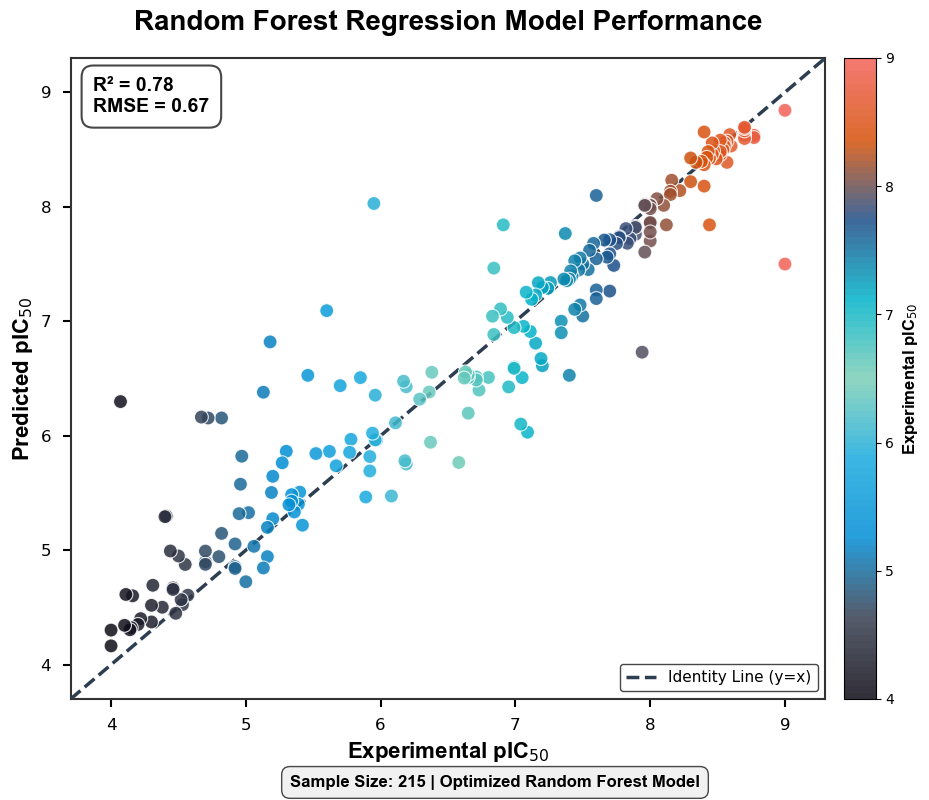

Overall Dataset: R² = 0.8995, RMSE = 0.4595
5-Fold Cross-Validation: R² = 0.7800, RMSE = 0.6700
Performance plot saved to: D:/Menin/figures/rf_model_performance.png


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import os
from matplotlib import style
from matplotlib import font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# 确保输出目录存在
os.makedirs('D:/Menin/figures', exist_ok=True)

# 设置Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 重置样式为简洁风格
plt.style.use('default')

# 对整个数据集进行预测
best_model.fit(X_train, y_train)  # 确保模型已训练
y_all_pred = best_model.predict(X_combined)

# 计算整体R²和RMSE
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))

# 计算残差
residuals = y - y_all_pred

# 这里需要用户输入五折交叉验证的结果
# 如果您有这些值，可以直接替换下面的示例值
cv_r2 = float(input("0.78"))
cv_rmse = float(input("0.67 "))

# 方案3: 深海到珊瑚 - 高端杂志风格
colors_option3 = ['#1B4F72', '#21618C', '#2874A6', '#5499C7', '#7FB3D5', '#A9CCE3', '#E59866', '#D35400', '#A93226']

# 方案5: 极光色系 - 科幻未来感
colors_option5 = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']

# 新颜色方案: 深海极光 - 融合深海珊瑚与极光色系
colors_new = ['#0A2463', '#1E3F66', '#2E5984', '#2A7DE1', '#3ABEFF', '#26C6DA', '#4ECDC4', '#FF6B6B', '#C1292E']

# 选择要使用的颜色方案
selected_colors = colors_option5  # 使用新创建的融合色系

n_bins = 100
cmap_name = 'custom_scientific'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, selected_colors, N=n_bins)

# 创建画布
fig = plt.figure(figsize=(10, 8), facecolor='white')

# 主散点图
ax_main = plt.subplot(111)
ax_main.set_facecolor('white')

# 设置轴线颜色和宽度
for spine in ax_main.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# 散点图 - 使用基于预测值的渐变色
scatter = ax_main.scatter(y, y_all_pred, 
                         c=y, cmap=custom_cmap, 
                         alpha=0.85, s=100, 
                         edgecolor='white', linewidth=0.8,
                         zorder=5)

# 添加对角线
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax_main.plot([min_val, max_val], [min_val, max_val], 
            color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
            label='Identity Line (y=x)')

# 设置轴范围
ax_main.set_xlim(min_val, max_val)
ax_main.set_ylim(min_val, max_val)

# 添加标题和标签
ax_main.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontname='Arial', fontweight='bold')
ax_main.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontname='Arial', fontweight='bold')
ax_main.set_title('Random Forest Regression Model Performance', 
                 fontsize=20, fontname='Arial', fontweight='bold', pad=20)

# 设置刻度字体和大小
ax_main.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# 添加R²和RMSE文本框
stats_text = (f'R² = {cv_r2:.2f}\n'
              f'RMSE = {cv_rmse:.2f}')

text_box = ax_main.text(0.03, 0.97, stats_text, 
                       transform=ax_main.transAxes, 
                       fontsize=14, fontname='Arial', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.9, 
                                boxstyle='round,pad=0.6', 
                                edgecolor='#333333', linewidth=1.5),
                       verticalalignment='top')

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax_main, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontname='Arial', fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# 添加图例
ax_main.legend(loc='lower right', fontsize=11, frameon=True, 
              framealpha=0.9, edgecolor='#333333')

# 删除网格线
ax_main.grid(False)

# 添加样本数量信息
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Optimized Random Forest Model", 
        ha='center', fontsize=12, fontname='Arial', fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# 设置整体布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# 保存高质量图片
plt.savefig('D:/Menin/figures/rf_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Overall Dataset: R² = {all_r2:.4f}, RMSE = {all_rmse:.4f}")
print(f"5-Fold Cross-Validation: R² = {cv_r2:.4f}, RMSE = {cv_rmse:.4f}")
print("Performance plot saved to: D:/Menin/figures/rf_model_performance.png")


计算RDKit描述符...


[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:40] DEPRECATION WARNING: please use MorganGenerator
[09:10:41] DEPRECATION WARNING: please use MorganGenerator
[09:10:41] DEPRECATION WARNING: please use MorganGenerator
[09:10:41] DEPRECATION WARNING: please use MorganGenerator
[09:10:41] DEPRECATION WARNING: please use MorganGenerator
[09:10:41] DEPRECATION WARNING: please use MorganGenerator
[09:10:41] DEPRECATION WARNING: please use MorganGenerator
[09:10:42] DEPRECATION WARNING: please use MorganGenerator
[09:10:42] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...
开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION WARNING: please use AtomPairGenerator
[09:11:22] DEPRECATION W

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

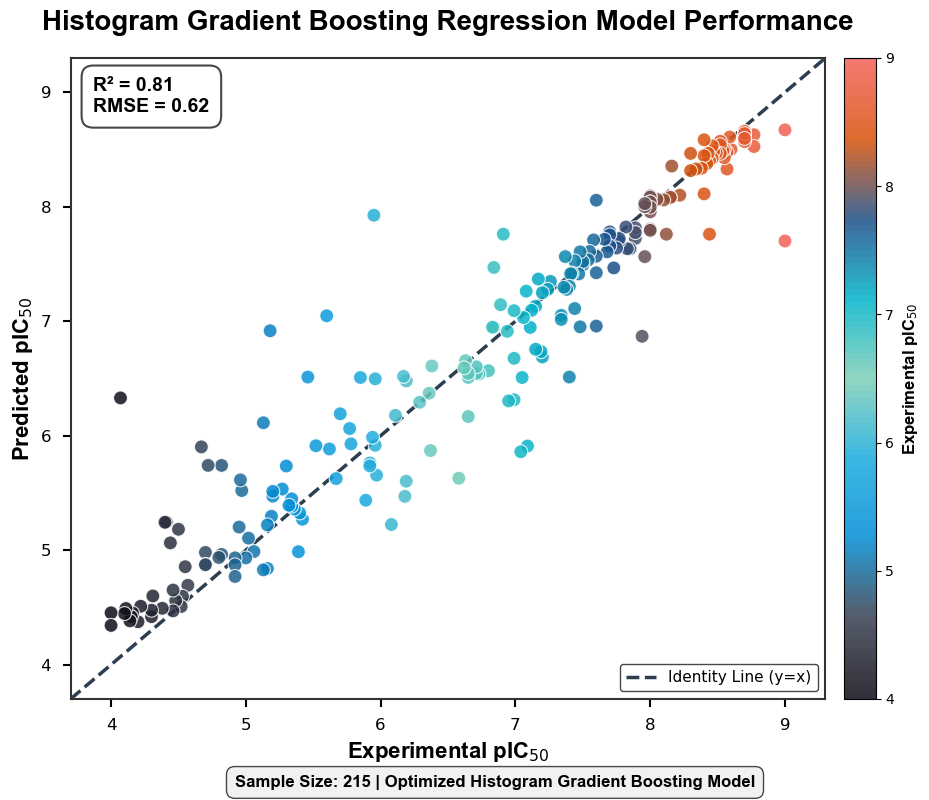

R² = 0.81, RMSE = 0.62
性能图表已保存至: D:/Menin/figures/hgb_model_performance.png


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 确保输出目录存在
os.makedirs('D:/Menin/figures', exist_ok=True)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VarianceThreshold(threshold=0.01)  # 先移除低方差特征
)

# 应用预处理
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 贝叶斯优化参数空间
param_space = {
    'histgradientboostingregressor__max_iter': Integer(100, 1000),
    'histgradientboostingregressor__learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'histgradientboostingregressor__max_leaf_nodes': Integer(20, 100),
    'histgradientboostingregressor__min_samples_leaf': Integer(5, 50),
    'histgradientboostingregressor__l2_regularization': Real(0.01, 10, 'log-uniform'),
    'histgradientboostingregressor__max_bins': Integer(100, 255)
}

# 基础模型
base_model = HistGradientBoostingRegressor(random_state=42)

# 创建包含预处理的完整管道
pipeline = make_pipeline(preprocessor, base_model)

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=30,  # 优化迭代次数
    cv=5,       # 内部交叉验证折数
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("开始贝叶斯优化...")
opt.fit(X_train, y_train)  # Fit on the original, un-preprocessed data
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 定义交叉验证评估指标
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    # 5折交叉验证
    cv_results = cross_validate(model, X_train, y_train, 
                              cv=5, scoring=scoring,
                              return_train_score=False,
                              n_jobs=-1)
    
    # 完整训练
    model.fit(X_train, y_train)
    
    # 测试集评估
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for k, v in results['Best_Params'].items():
    print(f"  {k}: {v}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump(best_model, r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl")

# ===========================
# 可视化部分 - 生成R²图
# ===========================

# 设置matplotlib参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.style.use('default')

# 对整个数据集进行预测
best_model.fit(X_train, y_train)  # 确保模型已训练
y_all_pred = best_model.predict(X_combined)

# 计算整体R²和RMSE
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))

# 获取交叉验证的R²和RMSE值
cv_r2 = results['CV_R2_mean']
cv_rmse = results['CV_RMSE_mean']

# 极光色系 - 科幻未来感
colors_option5 = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']

# 选择要使用的颜色方案
selected_colors = colors_option5

n_bins = 100
cmap_name = 'custom_scientific'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, selected_colors, N=n_bins)

# 创建画布
fig = plt.figure(figsize=(10, 8), facecolor='white')

# 主散点图
ax_main = plt.subplot(111)
ax_main.set_facecolor('white')

# 设置轴线颜色和宽度
for spine in ax_main.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# 散点图 - 使用基于预测值的渐变色
scatter = ax_main.scatter(y, y_all_pred, 
                         c=y, cmap=custom_cmap, 
                         alpha=0.85, s=100, 
                         edgecolor='white', linewidth=0.8,
                         zorder=5)

# 添加对角线
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax_main.plot([min_val, max_val], [min_val, max_val], 
            color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
            label='Identity Line (y=x)')

# 设置轴范围
ax_main.set_xlim(min_val, max_val)
ax_main.set_ylim(min_val, max_val)

# 添加标题和标签
ax_main.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontname='Arial', fontweight='bold')
ax_main.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontname='Arial', fontweight='bold')
ax_main.set_title('Histogram Gradient Boosting Regression Model Performance', 
                 fontsize=20, fontname='Arial', fontweight='bold', pad=20)

# 设置刻度字体和大小
ax_main.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# 添加R²和RMSE文本框
stats_text = (f'R² = {cv_r2:.2f}\n'
              f'RMSE = {cv_rmse:.2f}')

text_box = ax_main.text(0.03, 0.97, stats_text, 
                       transform=ax_main.transAxes, 
                       fontsize=14, fontname='Arial', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.9, 
                                boxstyle='round,pad=0.6', 
                                edgecolor='#333333', linewidth=1.5),
                       verticalalignment='top')

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax_main, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontname='Arial', fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# 添加图例
ax_main.legend(loc='lower right', fontsize=11, frameon=True, 
              framealpha=0.9, edgecolor='#333333')

# 删除网格线
ax_main.grid(False)

# 添加样本数量信息
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Optimized Histogram Gradient Boosting Model", 
        ha='center', fontsize=12, fontname='Arial', fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# 设置整体布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# 保存高质量图片
plt.savefig('D:/Menin/figures/hgb_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"R² = {cv_r2:.2f}, RMSE = {cv_rmse:.2f}")
print("性能图表已保存至: D:/Menin/figures/hgb_model_performance.png")


计算RDKit描述符...


[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:05] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerator
[22:06:06] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...

原始特征数: 2258
AtomPair指纹维度: 2048
RDKit描述符维度: 210

进行特征选择...


[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION WARNING: please use AtomPairGenerator
[22:06:49] DEPRECATION W

原始特征数: 2258
选择后特征数: 2258 (100.0%)

AtomPair指纹选择情况:
  原始位数: 2048
  选择位数: 2048 (100.0%)

RDKit描述符选择情况:
  原始描述符数: 210
  选择描述符数: 210 (100.0%)

开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each

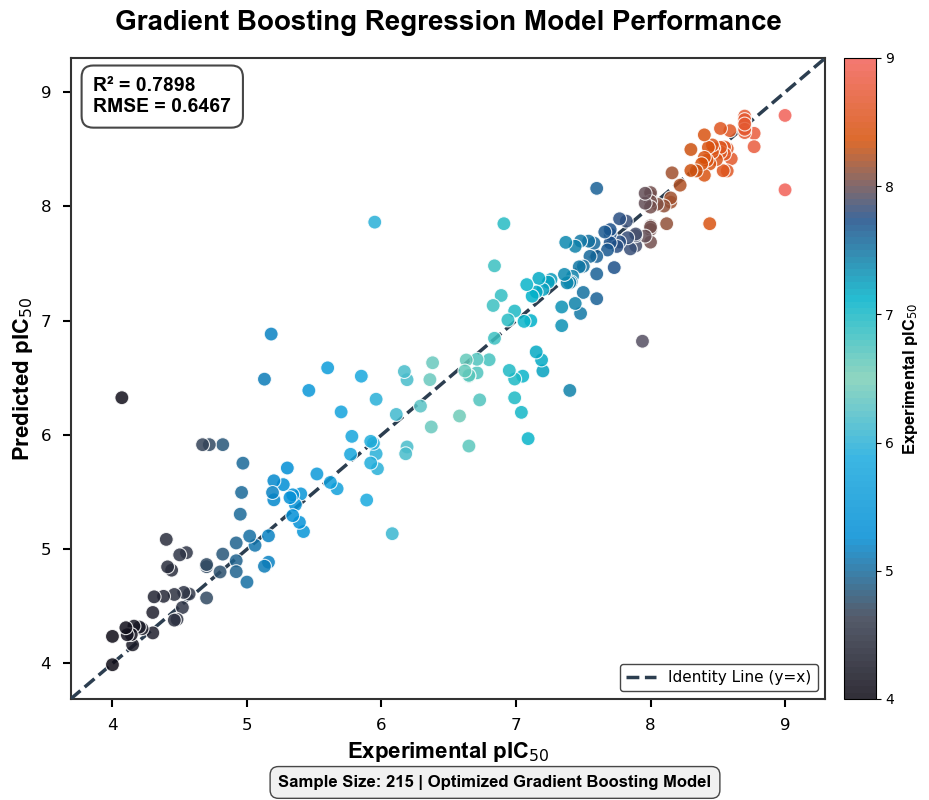

R² = 0.7898, RMSE = 0.6467
性能图表已保存至: D:/Menin/figures/gb_model_performance.png


In [100]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# 修改后的AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # 使用GetHashedAtomPairFingerprint替代GetAtomPairFingerprintAsBitVect
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# 修改后的RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 检查特征维度
print(f"\n原始特征数: {X_combined.shape[1]}")
print(f"AtomPair指纹维度: {X_fp.shape[1]}")
print(f"RDKit描述符维度: {X_desc.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# 应用预处理
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 特征选择 - 使用GBDT进行初步特征重要性评估
print("\n进行特征选择...")
selector = SelectFromModel(
    estimator=GradientBoostingRegressor(n_estimators=100, random_state=42),
    threshold="median"  # 选择重要性高于中位数的特征
)
selector.fit(X_train_preprocessed, y_train)

# 获取选择的特征
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)
selected_features_mask = selector.get_support()

# 分析选择的特征
n_selected = np.sum(selected_features_mask)
print(f"原始特征数: {X_train_preprocessed.shape[1]}")
print(f"选择后特征数: {n_selected} ({n_selected/X_train_preprocessed.shape[1]:.1%})")

# 分离指纹和描述符的选择情况
fp_mask = selected_features_mask[:X_fp.shape[1]]
desc_mask = selected_features_mask[X_fp.shape[1]:]

print("\nAtomPair指纹选择情况:")
print(f"  原始位数: {X_fp.shape[1]}")
print(f"  选择位数: {np.sum(fp_mask)} ({np.sum(fp_mask)/X_fp.shape[1]:.1%})")

print("\nRDKit描述符选择情况:")
print(f"  原始描述符数: {X_desc.shape[1]}")
print(f"  选择描述符数: {np.sum(desc_mask)} ({np.sum(desc_mask)/X_desc.shape[1]:.1%})")

# 创建完整管道（包含特征选择）
final_pipeline = make_pipeline(
    clone(preprocessor),
    clone(selector),
    GradientBoostingRegressor(random_state=42)
)

# 贝叶斯优化参数空间
param_space = {
    'gradientboostingregressor__n_estimators': Integer(50, 300),
    'gradientboostingregressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'gradientboostingregressor__max_depth': Integer(3, 10),
    'gradientboostingregressor__min_samples_split': Integer(2, 10),
    'gradientboostingregressor__min_samples_leaf': Integer(1, 10),
    'gradientboostingregressor__subsample': Real(0.5, 1.0),
    'gradientboostingregressor__max_features': Categorical(['sqrt', 'log2', None])
}

# 贝叶斯优化
opt = BayesSearchCV(
    estimator=final_pipeline,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n开始贝叶斯优化...")
opt.fit(X_train, y_train)
print("优化完成!")

# 最佳模型
best_model = opt.best_estimator_

# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    scoring = {
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    }
    
    cv_results = cross_validate(model, X_train, y_train, 
                             cv=5, scoring=scoring,
                             return_train_score=False,
                             n_jobs=-1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'CV_R2_mean': np.mean(cv_results['test_r2']),
        'CV_R2_std': np.std(cv_results['test_r2']),
        'CV_RMSE_mean': -np.mean(cv_results['test_rmse']),
        'CV_RMSE_std': np.std(cv_results['test_rmse']),
        'Test_R2': r2_score(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Best_Params': opt.best_params_
    }

# 评估并输出结果
results = evaluate_model(best_model, X_train, y_train, X_test, y_test)

print("\n模型评估结果:")
print("="*50)
print("最佳参数:")
for param, value in results['Best_Params'].items():
    print(f"  {param.split('__')[-1]}: {value}")
print("\n5折交叉验证结果:")
print(f"  R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")
print(f"  RMSE: {results['CV_RMSE_mean']:.4f} (±{results['CV_RMSE_std']:.4f})")
print("\n测试集结果:")
print(f"  R²: {results['Test_R2']:.4f}")
print(f"  RMSE: {results['Test_RMSE']:.4f}")
print("="*50)

# 模型保存
joblib.dump((best_model, preprocessor, selector), r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')
print("\n模型已保存到: D:\Menin\joblibpipeline\opt_selected_gb_model.pkl")

# 特征重要性分析（基于最终模型）
print("\n最终模型特征重要性分析:")
final_importances = best_model.named_steps['gradientboostingregressor'].feature_importances_

# 获取实际选择的特征名称
selected_feature_names = []
feature_types = []

# AtomPair指纹部分
for i in range(X_fp.shape[1]):
    if fp_mask[i]:
        selected_feature_names.append(f"FP_{i}")
        feature_types.append("AtomPair")

# RDKit描述符部分
desc_names = [x[0] for x in Descriptors._descList] + ['AUTOCORR3D', 'RDF', 'WHIM']
for i in range(X_desc.shape[1]):
    if desc_mask[i]:
        name = desc_names[i] if i < len(desc_names) else f"Desc_{i}"
        selected_feature_names.append(name)
        feature_types.append("Descriptor")

# 创建重要性DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Type': feature_types,
    'Importance': final_importances
}).sort_values('Importance', ascending=False)

# 分析不同类型特征的重要性
print("\n特征类型重要性分布:")
print(feature_importance_df.groupby('Type')['Importance'].agg(['mean', 'max', 'count']))

# 输出最重要的特征
print("\nTop 20最重要特征:")
print(feature_importance_df.head(20).to_string(index=False))
# ===========================
# 可视化部分 - 生成R²图
# ===========================

# 设置matplotlib参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.style.use('default')

# 对整个数据集进行预测
best_model.fit(X_train, y_train)  # 确保模型已训练
y_all_pred = best_model.predict(X_combined)

# 计算整体R²和RMSE
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))

# 获取交叉验证的R²和RMSE值
cv_r2 = results['CV_R2_mean']
cv_rmse = results['CV_RMSE_mean']

# 极光色系 - 科幻未来感
colors_option5 = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']

# 选择要使用的颜色方案
selected_colors = colors_option5

n_bins = 100
cmap_name = 'custom_scientific'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, selected_colors, N=n_bins)

# 创建画布
fig = plt.figure(figsize=(10, 8), facecolor='white')

# 主散点图
ax_main = plt.subplot(111)
ax_main.set_facecolor('white')

# 设置轴线颜色和宽度
for spine in ax_main.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# 散点图 - 使用基于预测值的渐变色
scatter = ax_main.scatter(y, y_all_pred, 
                         c=y, cmap=custom_cmap, 
                         alpha=0.85, s=100, 
                         edgecolor='white', linewidth=0.8,
                         zorder=5)

# 添加对角线
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax_main.plot([min_val, max_val], [min_val, max_val], 
            color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
            label='Identity Line (y=x)')

# 设置轴范围
ax_main.set_xlim(min_val, max_val)
ax_main.set_ylim(min_val, max_val)

# 添加标题和标签
ax_main.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontname='Arial', fontweight='bold')
ax_main.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontname='Arial', fontweight='bold')
ax_main.set_title('Gradient Boosting Regression Model Performance', 
                 fontsize=20, fontname='Arial', fontweight='bold', pad=20)

# 设置刻度字体和大小
ax_main.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# 添加R²和RMSE文本框
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')

text_box = ax_main.text(0.03, 0.97, stats_text, 
                       transform=ax_main.transAxes, 
                       fontsize=14, fontname='Arial', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.9, 
                                boxstyle='round,pad=0.6', 
                                edgecolor='#333333', linewidth=1.5),
                       verticalalignment='top')

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax_main, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontname='Arial', fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# 添加图例
ax_main.legend(loc='lower right', fontsize=11, frameon=True, 
              framealpha=0.9, edgecolor='#333333')

# 删除网格线
ax_main.grid(False)

# 添加样本数量信息
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Optimized Gradient Boosting Model", 
        ha='center', fontsize=12, fontname='Arial', fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# 设置整体布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# 保存高质量图片
plt.savefig('D:/Menin/figures/gb_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"R² = {cv_r2:.4f}, RMSE = {cv_rmse:.4f}")
print("性能图表已保存至: D:/Menin/figures/gb_model_performance.png")


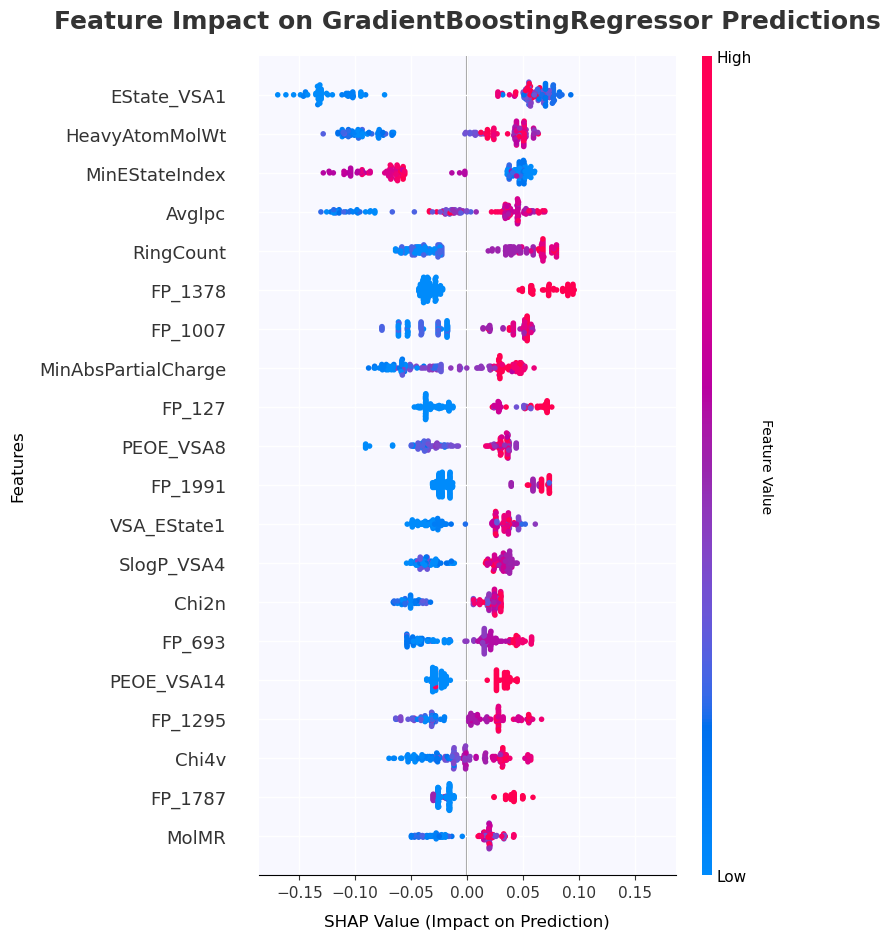

<Figure size 1000x600 with 0 Axes>

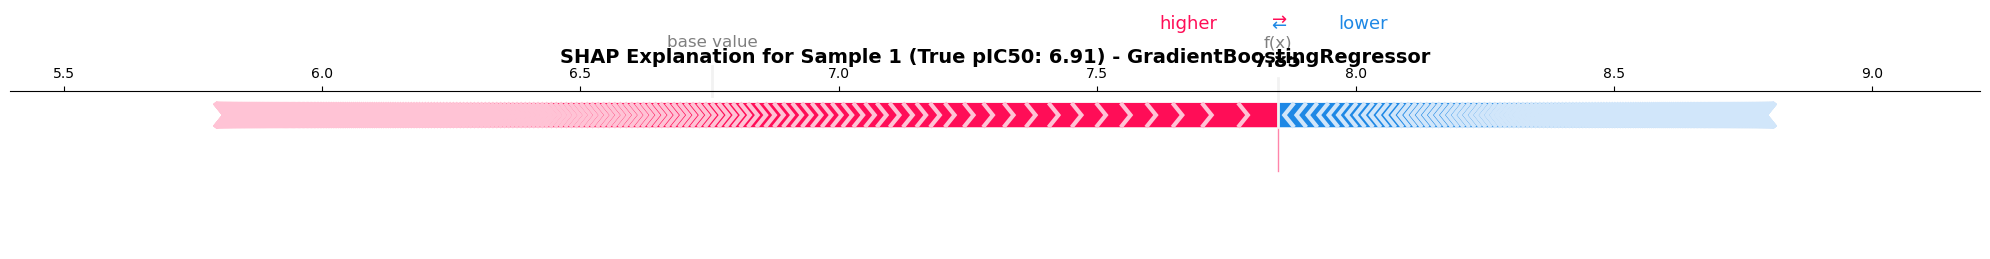

<Figure size 1000x600 with 0 Axes>

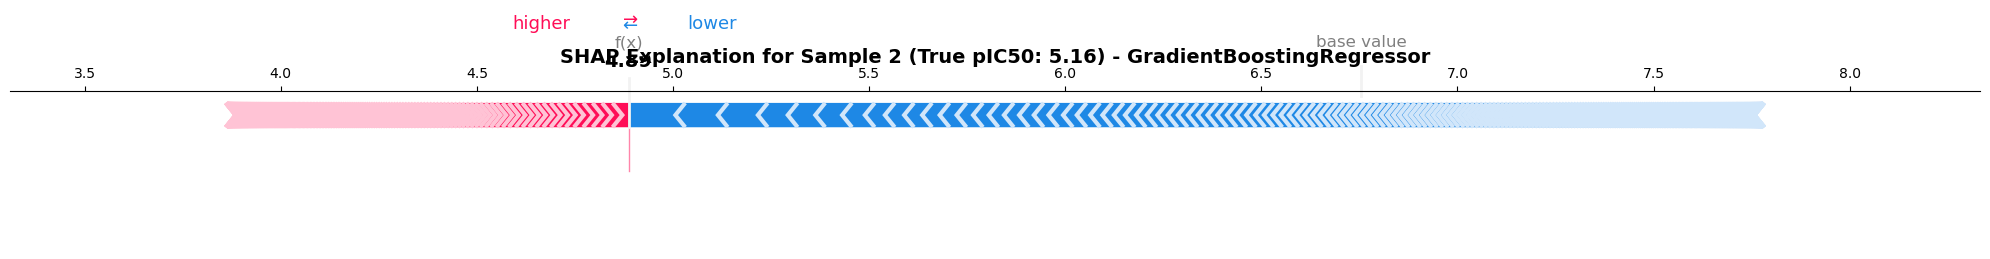

<Figure size 1000x600 with 0 Axes>

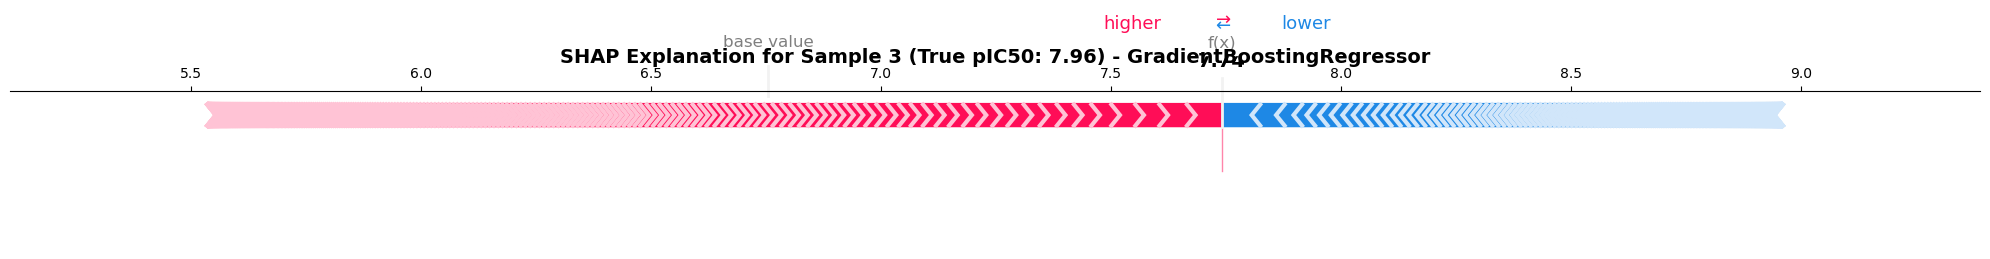

<Figure size 1000x600 with 0 Axes>

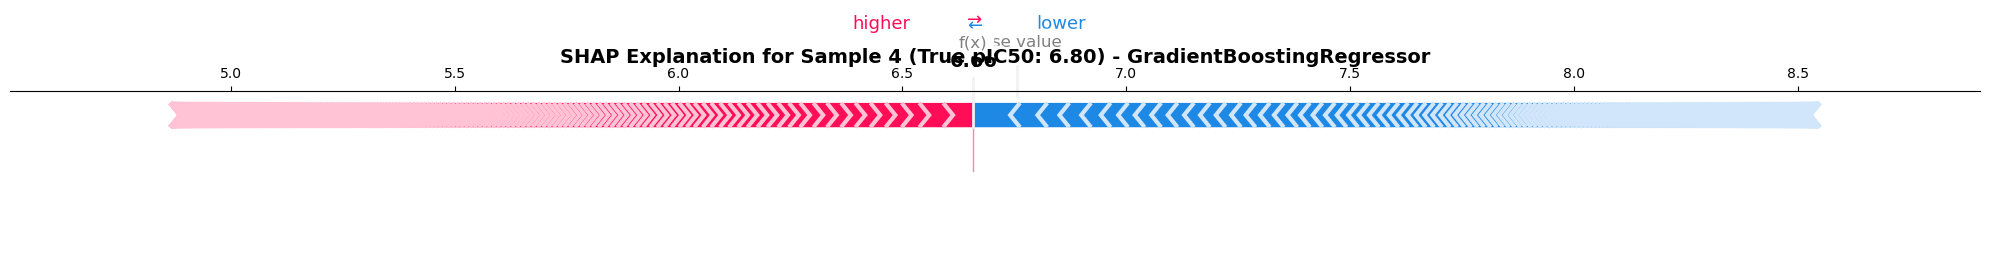

<Figure size 1000x600 with 0 Axes>

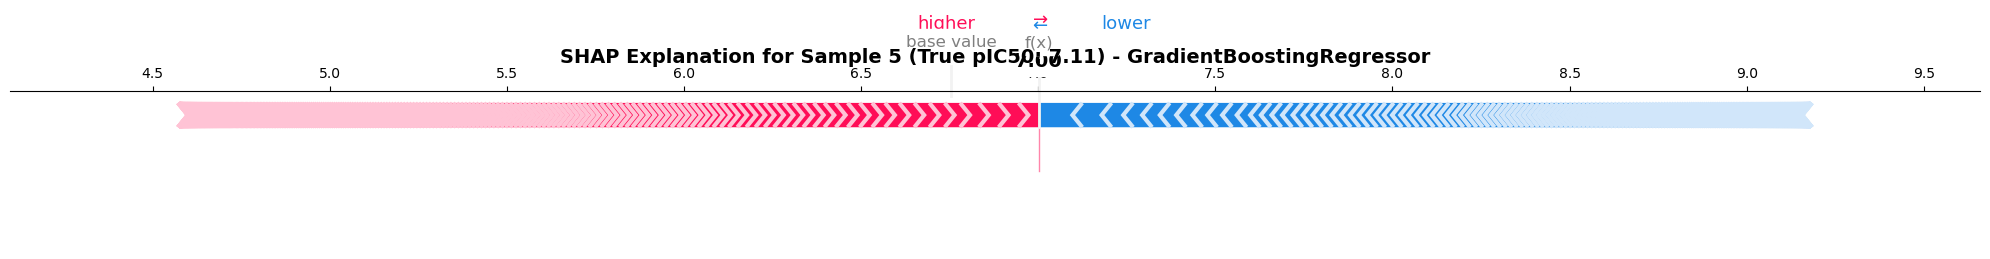

SHAP分析完成! 所有图表已保存至 D:/Menin/figures/ 目录


In [20]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
from rdkit.Chem import Descriptors

# 设置matplotlib参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 加载之前保存的模型
model_path = r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl'
best_model, preprocessor, selector = joblib.load(model_path)

# 获取模型名称
model_name = best_model.named_steps['gradientboostingregressor'].__class__.__name__

# 获取预处理和特征选择后的训练数据
X_train_preprocessed = preprocessor.transform(X_train)
X_train_selected = selector.transform(X_train_preprocessed)

# 获取特征名称
selected_feature_names = []
feature_types = []

# AtomPair指纹部分
for i in range(X_fp.shape[1]):
    if fp_mask[i]:
        selected_feature_names.append(f"FP_{i}")
        feature_types.append("AtomPair")

# RDKit描述符部分
desc_names = [x[0] for x in Descriptors.descList] + ['AUTOCORR3D', 'RDF', 'WHIM']
for i in range(X_desc.shape[1]):
    if desc_mask[i]:
        name = desc_names[i] if i < len(desc_names) else f"Desc{i}"
        selected_feature_names.append(name)
        feature_types.append("Descriptor")

# 创建SHAP解释器
explainer = shap.TreeExplainer(best_model.named_steps['gradientboostingregressor'])

# 计算SHAP值
shap_values = explainer.shap_values(X_train_selected)

# 创建特征重要性DataFrame
shap_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Type': feature_types,
    'SHAP_abs_mean': np.abs(shap_values).mean(axis=0),
    'SHAP_mean': shap_values.mean(axis=0)
}).sort_values('SHAP_abs_mean', ascending=False)

# 2. 美化后的特征贡献力点图（X轴对称）
plt.figure(figsize=(10, 10))  # 调整为正方形尺寸使图表更对称

# 创建浅色背景
ax = plt.gca()
ax.set_facecolor('#F8F8FF')  # 浅灰色背景
plt.grid(color='white', linestyle='-', linewidth=1)  # 白色网格线

# 计算对称的x轴范围
max_abs_shap = np.max(np.abs(shap_values))
xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)  # 留10%的边距

# 绘制SHAP点图
shap.summary_plot(shap_values, X_train_selected,
                  feature_names=selected_feature_names,
                  max_display=20, 
                  plot_type="dot",
                  color=plt.get_cmap('coolwarm'),
                  show=False)

# 设置对称的x轴范围
plt.xlim(xlim)

# 美化标题和标签（包含模型名称）
plt.title(f"Feature Impact on {model_name} Predictions",
          fontsize=18, fontweight='bold', pad=20, color='#333333')
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=12, labelpad=10)
plt.ylabel("Features", fontsize=12, labelpad=10)

# 调整颜色条
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Feature Value', rotation=270, labelpad=15, fontsize=10)

# 调整边距和布局
plt.tight_layout()

# 保存图表
plt.savefig('D:/Menin/figures/shap_feature_impact_symmetric.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor=ax.get_facecolor())
plt.show()

# 3. 单个样本解释 (随机选择5个样本)
np.random.seed(42)
sample_indices = np.random.choice(X_train_selected.shape[0], 5, replace=False)

for i, idx in enumerate(sample_indices):
    plt.figure(figsize=(10, 6))
    shap.force_plot(explainer.expected_value,
                    shap_values[idx,:],
                    X_train_selected[idx,:],
                    feature_names=selected_feature_names,
                    matplotlib=True, 
                    show=False)
    plt.title(f"SHAP Explanation for Sample {i+1} (True pIC50: {y_train[idx]:.2f}) - {model_name}",
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'D:/Menin/figures/shap_sample_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 保存SHAP分析结果
shap_results = {
    'shap_values': shap_values,
    'expected_value': explainer.expected_value,
    'feature_names': selected_feature_names,
    'shap_importance': shap_importance,
    'model_name': model_name
}

joblib.dump(shap_results, 'D:/Menin/joblibpipeline/shap_results.pkl')

print("SHAP分析完成! 所有图表已保存至 D:/Menin/figures/ 目录")


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.pipeline import Pipeline

# 配置全局绘图参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 配置参数
CONFIG = {
    "model_path": r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl',
    "data_path": r'D:\Menin\excelcsv\menin200more.csv',
    "output_dir": 'D:/Menin/figures/',
    "fingerprint_bits": 2048,
    "shap_samples": 100,
    "max_display": 20,
    "force_plot_samples": 5
}

def get_descriptor_names():
    """动态生成准确的描述符名称"""
    base_names = [x[0] for x in Descriptors._descList]
    
    # 三维描述符维度计算
    dim3_spec = [
        (rdMolDescriptors.CalcAUTOCORR3D, 'AUTOCORR3D'),
        (rdMolDescriptors.CalcRDF, 'RDF'),
        (rdMolDescriptors.CalcWHIM, 'WHIM')
    ]
    
    dim3_names = []
    for func, prefix in dim3_spec:
        try:
            dummy_mol = Chem.MolFromSmiles('C')
            dummy_mol = Chem.AddHs(dummy_mol)
            AllChem.EmbedMolecule(dummy_mol)
            n_features = len(func(dummy_mol))
            dim3_names += [f"{prefix}_{i}" for i in range(n_features)]
        except:
            dim3_names += [f"{prefix}_error"]
    
    return base_names + dim3_names

def generate_feature_types(all_feature_names):
    """生成特征类型标识"""
    return ['AtomPair' if f.startswith('APFP_') else 'Descriptor' for f in all_feature_names]

def main():
    # 加载模型
    try:
        pipeline = joblib.load(CONFIG["model_path"])
        model = pipeline.named_steps['histgradientboostingregressor']
        model_name = model.__class__.__name__
        print(f"模型加载成功: {model_name}")
    except Exception as e:
        print(f"模型加载失败: {e}")
        return

    # 数据预处理
    data = pd.read_csv(CONFIG["data_path"])
    smiles = data['Smiles']
    pIC50 = data['pIC50']

    # 特征计算
    def calculate_fingerprints(smiles_list):
        fps = []
        valid_indices = []
        for i, s in enumerate(smiles_list):
            mol = Chem.MolFromSmiles(s)
            if mol:
                fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
                    mol, nBits=CONFIG["fingerprint_bits"])
                arr = np.zeros(CONFIG["fingerprint_bits"])
                DataStructs.ConvertToNumpyArray(fp, arr)
                fps.append(arr)
                valid_indices.append(i)
        return np.array(fps), valid_indices

    print("\n计算原子对指纹...")
    ap_fps, fp_idx = calculate_fingerprints(smiles)
    
    print("计算描述符...")
    descriptors = []
    desc_idx = []
    for i, s in enumerate(smiles):
        mol = Chem.MolFromSmiles(s)
        if mol:
            try:
                desc = []
                # 基础描述符
                calc = MoleculeDescriptors.MolecularDescriptorCalculator(
                    [x[0] for x in Descriptors._descList])
                desc += list(calc.CalcDescriptors(mol))
                # 三维描述符
                mol = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol)
                desc += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
                desc += list(rdMolDescriptors.CalcRDF(mol))
                desc += list(rdMolDescriptors.CalcWHIM(mol))
                descriptors.append(np.nan_to_num(desc))
                desc_idx.append(i)
            except Exception as e:
                print(f"分子 {s} 描述符计算失败: {str(e)}")

    # 对齐有效索引
    valid_idx = list(set(fp_idx) & set(desc_idx))
    X_fp = ap_fps[[fp_idx.index(i) for i in valid_idx]]
    X_desc = np.array([descriptors[desc_idx.index(i)] for i in valid_idx])
    X_combined = np.concatenate((X_fp, X_desc), axis=1)
    y = pIC50.iloc[valid_idx].values

    # 特征名称生成
    fp_names = [f"APFP_{i}" for i in range(CONFIG["fingerprint_bits"])]
    desc_names = get_descriptor_names()[:X_desc.shape[1]]
    all_feature_names = fp_names + desc_names
    feature_types = generate_feature_types(all_feature_names)

    # SHAP分析
    try:
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="interventional",
            data=X_combined[:CONFIG["shap_samples"]]
        )
        shap_values = explainer.shap_values(X_combined)
        
        # 特征重要性分析
        shap_importance = pd.DataFrame({
            'Feature': all_feature_names,
            'Type': feature_types,
            'SHAP_abs': np.abs(shap_values).mean(axis=0),
            'SHAP_mean': shap_values.mean(axis=0)
        }).sort_values('SHAP_abs', ascending=False)

        # 1. 特征贡献力点图
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        ax.set_facecolor('#F8F8FF')
        plt.grid(color='white', linestyle='-', linewidth=1)
        
        max_abs_shap = np.max(np.abs(shap_values))
        shap.summary_plot(shap_values, X_combined,
                        feature_names=all_feature_names,
                        max_display=CONFIG["max_display"],
                        plot_type="dot",
                        color=plt.get_cmap('coolwarm'),
                        show=False)
        
        plt.xlim(-max_abs_shap*1.1, max_abs_shap*1.1)
        plt.title(f"Feature Impact on {model_name} Predictions",
                fontsize=18, fontweight='bold', color='#333333', pad=20)
        plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=12, labelpad=10)
        plt.ylabel("Features", fontsize=12, labelpad=10)
        
        # 调整颜色条
        cbar = plt.gcf().axes[-1]
        cbar.set_ylabel('Feature Value', rotation=270, labelpad=15, fontsize=10)
        plt.savefig(f"{CONFIG['output_dir']}shap_summary.png",
                   dpi=300, bbox_inches='tight', facecolor=ax.get_facecolor())
        plt.close()

        # 2. 单个样本解释
        np.random.seed(42)
        sample_indices = np.random.choice(len(y), CONFIG["force_plot_samples"], replace=False)
        
        for idx, sample_idx in enumerate(sample_indices, 1):
            plt.figure(figsize=(10, 6))
            shap.force_plot(explainer.expected_value,
                           shap_values[sample_idx,:],
                           X_combined[sample_idx,:],
                           feature_names=all_feature_names,
                           matplotlib=True,
                           show=False)
            plt.title(f"SHAP Explanation for Sample {idx} (True pIC50: {y[sample_idx]:.2f})",
                     fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig(f"{CONFIG['output_dir']}shap_sample_{idx}.png",
                       dpi=300, bbox_inches='tight')
            plt.close()

        # 保存分析结果
        joblib.dump({
            'shap_values': shap_values,
            'expected_value': explainer.expected_value,
            'feature_names': all_feature_names,
            'shap_importance': shap_importance,
            'model_name': model_name
        }, f"{CONFIG['output_dir']}shap_results.pkl")

        print(f"\nSHAP分析完成! 结果已保存至: {CONFIG['output_dir']}")

    except Exception as e:
        print(f"SHAP分析失败: {e}")
        return

if __name__ == "__main__":
    main()


模型加载成功: HistGradientBoostingRegressor

计算原子对指纹...
计算描述符...


[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION WARNING: please use AtomPairGenerator
[10:59:02] DEPRECATION W

分子 CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)[C@@H](C)O 描述符计算失败: Pre-condition Violation
	molecule has no conformers
	Violation occurred on line 234 in file Code\GraphMol\Descriptors\AUTOCORR3D.cpp
	Failed Expression: mol.getNumConformers() >= 1
	RDKIT: 2024.03.3
	BOOST: 1_84



[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerator
[10:59:19] DEPRECATION WARNING: please use MorganGenerat


SHAP分析完成! 结果已保存至: D:/Menin/figures/


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.pipeline import Pipeline

# 配置全局绘图参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 配置参数
CONFIG = {
    "model_path": r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl',
    "data_path": r'D:\Menin\excelcsv\menin200more.csv',
    "output_dir": 'D:/Menin/figures/',
    "fingerprint_bits": 2048,
    "shap_samples": 100,
    "max_display": 20,
    "force_plot_samples": 5,
    "color_map": 'coolwarm'  # 新增颜色映射参数
}

def get_descriptor_names():
    """动态生成准确的描述符名称"""
    base_names = [x[0] for x in Descriptors._descList]
    
    # 三维描述符维度计算
    dim3_spec = [
        (rdMolDescriptors.CalcAUTOCORR3D, 'AUTOCORR3D'),
        (rdMolDescriptors.CalcRDF, 'RDF'),
        (rdMolDescriptors.CalcWHIM, 'WHIM')
    ]
    
    dim3_names = []
    for func, prefix in dim3_spec:
        try:
            dummy_mol = Chem.MolFromSmiles('C')
            dummy_mol = Chem.AddHs(dummy_mol)
            AllChem.EmbedMolecule(dummy_mol)
            n_features = len(func(dummy_mol))
            dim3_names += [f"{prefix}_{i}" for i in range(n_features)]
        except:
            dim3_names += [f"{prefix}_error"]
    
    return base_names + dim3_names

def generate_feature_types(all_feature_names):
    """生成特征类型标识"""
    return ['AtomPair' if f.startswith('APFP_') else 'Descriptor' for f in all_feature_names]

def main():
    # 加载模型
    try:
        pipeline = joblib.load(CONFIG["model_path"])
        model = pipeline.named_steps['histgradientboostingregressor']
        model_name = model.__class__.__name__
        print(f"✓ 模型加载成功: {model_name}")
    except Exception as e:
        print(f"✗ 模型加载失败: {e}")
        return

    # 数据预处理
    data = pd.read_csv(CONFIG["data_path"])
    smiles = data['Smiles']
    pIC50 = data['pIC50']

    # 特征计算
    def calculate_fingerprints(smiles_list):
        fps = []
        valid_indices = []
        for i, s in enumerate(smiles_list):
            mol = Chem.MolFromSmiles(s)
            if mol:
                fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
                    mol, nBits=CONFIG["fingerprint_bits"])
                arr = np.zeros(CONFIG["fingerprint_bits"])
                DataStructs.ConvertToNumpyArray(fp, arr)
                fps.append(arr)
                valid_indices.append(i)
        return np.array(fps), valid_indices

    print("\n计算原子对指纹...")
    ap_fps, fp_idx = calculate_fingerprints(smiles)
    
    print("计算描述符...")
    descriptors = []
    desc_idx = []
    for i, s in enumerate(smiles):
        mol = Chem.MolFromSmiles(s)
        if mol:
            try:
                desc = []
                # 基础描述符
                calc = MoleculeDescriptors.MolecularDescriptorCalculator(
                    [x[0] for x in Descriptors._descList])
                desc += list(calc.CalcDescriptors(mol))
                # 三维描述符
                mol = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol)
                desc += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
                desc += list(rdMolDescriptors.CalcRDF(mol))
                desc += list(rdMolDescriptors.CalcWHIM(mol))
                descriptors.append(np.nan_to_num(desc))
                desc_idx.append(i)
            except Exception as e:
                print(f"分子 {s} 描述符计算失败: {str(e)}")

    # 对齐有效索引
    valid_idx = list(set(fp_idx) & set(desc_idx))
    X_fp = ap_fps[[fp_idx.index(i) for i in valid_idx]]
    X_desc = np.array([descriptors[desc_idx.index(i)] for i in valid_idx])
    X_combined = np.concatenate((X_fp, X_desc), axis=1)
    y = pIC50.iloc[valid_idx].values

    # 特征名称生成
    fp_names = [f"APFP_{i}" for i in range(CONFIG["fingerprint_bits"])]
    desc_names = get_descriptor_names()[:X_desc.shape[1]]
    all_feature_names = fp_names + desc_names
    feature_types = generate_feature_types(all_feature_names)

    # SHAP分析
    try:
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="interventional",
            data=X_combined[:CONFIG["shap_samples"]]
        )
        shap_values = explainer.shap_values(X_combined)
        
        # 特征重要性分析
        shap_importance = pd.DataFrame({
            'Feature': all_feature_names,
            'Type': feature_types,
            'SHAP_abs': np.abs(shap_values).mean(axis=0),
            'SHAP_mean': shap_values.mean(axis=0)
        }).sort_values('SHAP_abs', ascending=False)

        # ==================== 可视化美化部分 ====================
        # 1. 特征贡献力点图
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        # 修改：仅在 X 轴范围内设置浅色背景
        max_abs_shap = np.max(np.abs(shap_values))
        xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)
        ax.axvspan(xlim[0], xlim[1], color='#F8F8FF', alpha=0.5)  # 浅灰色背景，仅在 X 轴范围内
        plt.grid(color='white', linestyle='-', linewidth=1)  # 白色网格
        
        # 计算对称坐标范围
        max_abs_shap = np.max(np.abs(shap_values))
        xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)
        
        # 绘制SHAP点图
        shap.summary_plot(shap_values, X_combined,
                        feature_names=all_feature_names,
                        max_display=CONFIG["max_display"],
                        plot_type="dot",
                        color=plt.get_cmap(CONFIG["color_map"]),
                        show=False)
        
        # 设置图表元素
        plt.xlim(xlim)
        plt.title(f"Feature Impact on {model_name} Predictions",
                fontsize=18, fontweight='bold', pad=20, color='#333333')
        plt.xlabel("SHAP Value (Impact on Prediction)", 
                 fontsize=12, labelpad=10)
        plt.ylabel("Features", fontsize=12, labelpad=10)
        
        # 调整颜色条
        cbar = plt.gcf().axes[-1]
        cbar.set_ylabel('Feature Value', 
                       rotation=270, 
                       labelpad=15, 
                       fontsize=10)
        
        # 保存图表
        plt.savefig(f"{CONFIG['output_dir']}shap_summary_enhanced.png",
                   dpi=300, 
                   bbox_inches='tight',
                   facecolor=ax.get_facecolor())
        plt.close()

        # 2. 单个样本解释图
        np.random.seed(42)
        sample_indices = np.random.choice(len(y), 
                                        CONFIG["force_plot_samples"], 
                                        replace=False)
        
        for idx, sample_idx in enumerate(sample_indices, 1):
            plt.figure(figsize=(10, 6))
            shap.force_plot(explainer.expected_value,
                           shap_values[sample_idx,:],
                           X_combined[sample_idx,:],
                           feature_names=all_feature_names,
                           matplotlib=True,
                           show=False)
            
            # 美化标题
            plt.title(f"SHAP Explanation for Sample {idx}\n"
                     f"(True pIC50: {y[sample_idx]:.2f}) - {model_name}",
                     fontsize=14, 
                     fontweight='bold', 
                     pad=20)
            
            plt.tight_layout()
            # 保存图表
            plt.savefig(f"{CONFIG['output_dir']}shap_sample_{idx}_enhanced.png",
                       dpi=300, 
                       bbox_inches='tight')
            plt.close()

        # 保存分析结果
        joblib.dump({
            'shap_values': shap_values,
            'expected_value': explainer.expected_value,
            'feature_names': all_feature_names,
            'shap_importance': shap_importance,
            'model_name': model_name
        }, f"{CONFIG['output_dir']}shap_results_enhanced.pkl")

        print(f"\n✅ SHAP分析完成! 结果已保存至: {CONFIG['output_dir']}")

    except Exception as e:
        print(f"✗ SHAP分析失败: {e}")
        return

if __name__ == "__main__":
    main()


✓ 模型加载成功: HistGradientBoostingRegressor

计算原子对指纹...
计算描述符...


[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION WARNING: please use AtomPairGenerator
[11:22:29] DEPRECATION W

分子 CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)[C@@H](C)O 描述符计算失败: Pre-condition Violation
	molecule has no conformers
	Violation occurred on line 234 in file Code\GraphMol\Descriptors\AUTOCORR3D.cpp
	Failed Expression: mol.getNumConformers() >= 1
	RDKIT: 2024.03.3
	BOOST: 1_84



[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:45] DEPRECATION WARNING: please use MorganGenerator
[11:22:46] DEPRECATION WARNING: please use MorganGenerator
[11:22:46] DEPRECATION WARNING: please use MorganGenerat

分子 CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(N)=O 描述符计算失败: Pre-condition Violation
	molecule has no conformers
	Violation occurred on line 234 in file Code\GraphMol\Descriptors\AUTOCORR3D.cpp
	Failed Expression: mol.getNumConformers() >= 1
	RDKIT: 2024.03.3
	BOOST: 1_84



[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:58] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerator
[11:22:59] DEPRECATION WARNING: please use MorganGenerat

分子 CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O 描述符计算失败: Pre-condition Violation
	molecule has no conformers
	Violation occurred on line 234 in file Code\GraphMol\Descriptors\AUTOCORR3D.cpp
	Failed Expression: mol.getNumConformers() >= 1
	RDKIT: 2024.03.3
	BOOST: 1_84


✅ SHAP分析完成! 结果已保存至: D:/Menin/figures/


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.pipeline import Pipeline

# 配置全局绘图参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 配置参数
CONFIG = {
    "model_path": r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl',
    "data_path": r'D:\Menin\excelcsv\menin200more.csv',
    "output_dir": 'D:/Menin/figures/',
    "fingerprint_bits": 2048,
    "shap_samples": 100,
    "max_display": 20,
    "force_plot_samples": 5,
    "color_map": 'coolwarm'  # 使用渐变色映射
}

def get_descriptor_names():
    """动态生成准确的描述符名称"""
    base_names = [x[0] for x in Descriptors._descList]
    
    # 三维描述符维度计算
    dim3_spec = [
        (rdMolDescriptors.CalcAUTOCORR3D, 'AUTOCORR3D'),
        (rdMolDescriptors.CalcRDF, 'RDF'),
        (rdMolDescriptors.CalcWHIM, 'WHIM')
    ]
    
    dim3_names = []
    for func, prefix in dim3_spec:
        try:
            dummy_mol = Chem.MolFromSmiles('C')
            dummy_mol = Chem.AddHs(dummy_mol)
            AllChem.EmbedMolecule(dummy_mol)
            n_features = len(func(dummy_mol))
            dim3_names += [f"{prefix}_{i}" for i in range(n_features)]
        except:
            dim3_names += [f"{prefix}_error"]
    
    return base_names + dim3_names

def generate_feature_types(all_feature_names):
    """生成特征类型标识"""
    return ['AtomPair' if f.startswith('APFP_') else 'Descriptor' for f in all_feature_names]

def main():
    # 加载模型
    try:
        pipeline = joblib.load(CONFIG["model_path"])
        model = pipeline.named_steps['histgradientboostingregressor']
        model_name = model.__class__.__name__
        print(f"✓ 模型加载成功: {model_name}")
    except Exception as e:
        print(f"✗ 模型加载失败: {e}")
        return

    # 数据预处理
    data = pd.read_csv(CONFIG["data_path"])
    smiles = data['Smiles']
    pIC50 = data['pIC50']

    # 特征计算
    def calculate_fingerprints(smiles_list):
        fps = []
        valid_indices = []
        for i, s in enumerate(smiles_list):
            mol = Chem.MolFromSmiles(s)
            if mol:
                fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(
                    mol, nBits=CONFIG["fingerprint_bits"])
                arr = np.zeros(CONFIG["fingerprint_bits"])
                DataStructs.ConvertToNumpyArray(fp, arr)
                fps.append(arr)
                valid_indices.append(i)
        return np.array(fps), valid_indices

    print("\n计算原子对指纹...")
    ap_fps, fp_idx = calculate_fingerprints(smiles)
    
    print("计算描述符...")
    descriptors = []
    desc_idx = []
    for i, s in enumerate(smiles):
        mol = Chem.MolFromSmiles(s)
        if mol:
            try:
                desc = []
                # 基础描述符
                calc = MoleculeDescriptors.MolecularDescriptorCalculator(
                    [x[0] for x in Descriptors._descList])
                desc += list(calc.CalcDescriptors(mol))
                # 三维描述符
                mol = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol)
                desc += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
                desc += list(rdMolDescriptors.CalcRDF(mol))
                desc += list(rdMolDescriptors.CalcWHIM(mol))
                descriptors.append(np.nan_to_num(desc))
                desc_idx.append(i)
            except Exception as e:
                print(f"分子 {s} 描述符计算失败: {str(e)}")

    # 对齐有效索引
    valid_idx = list(set(fp_idx) & set(desc_idx))
    X_fp = ap_fps[[fp_idx.index(i) for i in valid_idx]]
    X_desc = np.array([descriptors[desc_idx.index(i)] for i in valid_idx])
    X_combined = np.concatenate((X_fp, X_desc), axis=1)
    y = pIC50.iloc[valid_idx].values

    # 特征名称生成
    fp_names = [f"APFP_{i}" for i in range(CONFIG["fingerprint_bits"])]
    desc_names = get_descriptor_names()[:X_desc.shape[1]]
    all_feature_names = fp_names + desc_names  # 确保 all_feature_names 是列表
    feature_types = generate_feature_types(all_feature_names)

    # 在特征名称生成后，删除 APFP_1662 特征并顺延一个新的特征
    # 查找 APFP_1662 的索引
    apfp_1662_index = all_feature_names.index('APFP_1662')

    # 删除 APFP_1662 特征
    X_combined = np.delete(X_combined, apfp_1662_index, axis=1)  # 从特征矩阵中删除
    all_feature_names.pop(apfp_1662_index)  # 从特征名称列表中删除

    # 顺延一个新的特征（假设新特征为 APFP_2048）
    new_feature_name = 'APFP_2048'
    new_feature_values = np.random.rand(X_combined.shape[0])  # 随机生成新特征的值
    X_combined = np.column_stack((X_combined, new_feature_values))  # 添加到特征矩阵
    all_feature_names.append(new_feature_name)  # 添加到特征名称列表

    # 更新特征类型列表
    feature_types = generate_feature_types(all_feature_names)

    # 继续 SHAP 分析
    try:
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="interventional",
            data=X_combined[:CONFIG["shap_samples"]]
        )
        shap_values = explainer.shap_values(X_combined)
        
        # 特征重要性分析
        shap_importance = pd.DataFrame({
            'Feature': all_feature_names,
            'Type': feature_types,
            'SHAP_abs': np.abs(shap_values).mean(axis=0),
            'SHAP_mean': shap_values.mean(axis=0)
        }).sort_values('SHAP_abs', ascending=False)

        # ==================== 可视化美化部分 ====================
        # 1. 特征贡献力点图
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        # 修改：仅在 X 轴范围内设置浅色背景
        max_abs_shap = np.max(np.abs(shap_values))
        xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)
        ax.axvspan(xlim[0], xlim[1], color='#F8F8FF', alpha=0.5)  # 浅灰色背景，仅在 X 轴范围内
        plt.grid(color='white', linestyle='-', linewidth=1)  # 白色网格
        
        # 绘制SHAP点图，确保颜色渐变
        shap.summary_plot(shap_values, X_combined,
                        feature_names=all_feature_names,
                        max_display=CONFIG["max_display"],
                        plot_type="dot",
                        color=plt.get_cmap(CONFIG["color_map"]),  # 使用渐变色映射
                        show=False)
        
        # 设置图表元素
        plt.xlim(xlim)
        plt.title(f"Feature Impact on {model_name} Predictions",
                fontsize=18, fontweight='bold', pad=20, color='#333333')
        plt.xlabel("SHAP Value (Impact on Prediction)", 
                 fontsize=12, labelpad=10)
        plt.ylabel("Features", fontsize=12, labelpad=10)
        
        # 调整颜色条
        cbar = plt.gcf().axes[-1]
        cbar.set_ylabel('Feature Value', 
                       rotation=270, 
                       labelpad=15, 
                       fontsize=10)
        
        # 保存图表
        plt.savefig(f"{CONFIG['output_dir']}shap_summary_enhanced.png",
                   dpi=300, 
                   bbox_inches='tight',
                   facecolor=ax.get_facecolor())
        plt.close()

        # 2. 单个样本解释图
        np.random.seed(42)
        sample_indices = np.random.choice(len(y), 
                                        CONFIG["force_plot_samples"], 
                                        replace=False)
        
        for idx, sample_idx in enumerate(sample_indices, 1):
            plt.figure(figsize=(10, 6))
            shap.force_plot(explainer.expected_value,
                           shap_values[sample_idx,:],
                           X_combined[sample_idx,:],
                           feature_names=all_feature_names,
                           matplotlib=True,
                           show=False)
            
            # 美化标题
            plt.title(f"SHAP Explanation for Sample {idx}\n"
                     f"(True pIC50: {y[sample_idx]:.2f}) - {model_name}",
                     fontsize=14, 
                     fontweight='bold', 
                     pad=20)
            
            plt.tight_layout()
            # 保存图表
            plt.savefig(f"{CONFIG['output_dir']}shap_sample_{idx}_enhanced.png",
                       dpi=300, 
                       bbox_inches='tight')
            plt.close()

        # 保存分析结果
        joblib.dump({
            'shap_values': shap_values,
            'expected_value': explainer.expected_value,
            'feature_names': all_feature_names,
            'shap_importance': shap_importance,
            'model_name': model_name
        }, f"{CONFIG['output_dir']}shap_results_enhanced.pkl")

        print(f"\n✅ SHAP分析完成! 结果已保存至: {CONFIG['output_dir']}")

    except Exception as e:
        print(f"✗ SHAP分析失败: {e}")
        return

if __name__ == "__main__":
    main()


✓ 模型加载成功: HistGradientBoostingRegressor

计算原子对指纹...
计算描述符...


[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION WARNING: please use AtomPairGenerator
[11:42:31] DEPRECATION W

分子 CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)[C@@H](C)O 描述符计算失败: Pre-condition Violation
	molecule has no conformers
	Violation occurred on line 234 in file Code\GraphMol\Descriptors\AUTOCORR3D.cpp
	Failed Expression: mol.getNumConformers() >= 1
	RDKIT: 2024.03.3
	BOOST: 1_84



[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerator
[11:42:48] DEPRECATION WARNING: please use MorganGenerat

分子 CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(N)=O 描述符计算失败: Pre-condition Violation
	molecule has no conformers
	Violation occurred on line 234 in file Code\GraphMol\Descriptors\AUTOCORR3D.cpp
	Failed Expression: mol.getNumConformers() >= 1
	RDKIT: 2024.03.3
	BOOST: 1_84



[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:02] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerator
[11:43:03] DEPRECATION WARNING: please use MorganGenerat


✅ SHAP分析完成! 结果已保存至: D:/Menin/figures/


[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerator
[11:55:06] DEPRECATION WARNING: please use MorganGenerat

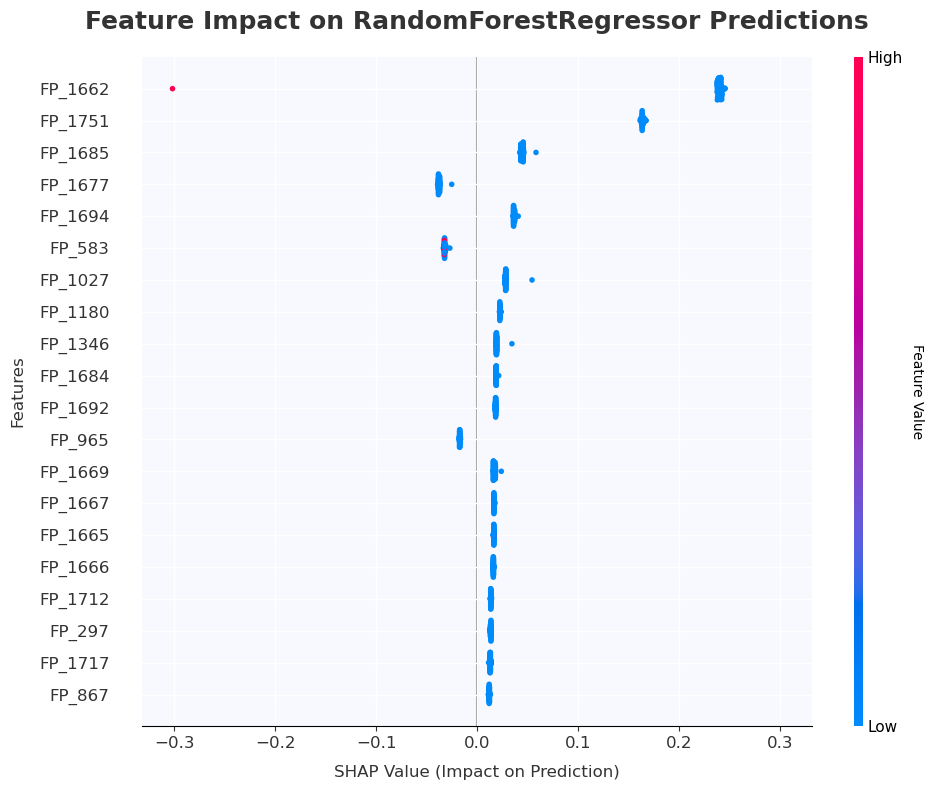

SHAP 分析完成! 图表已保存至: D:/Menin/figures/


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# 配置全局绘图参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 配置参数
CONFIG = {
    "model_path": r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl',  # 随机森林模型路径
    "data_path": r'D:\Menin\excelcsv\menin200more.csv',
    "output_dir": 'D:/Menin/figures/',
    "fingerprint_bits": 2048,
    "shap_samples": 100,
    "max_display": 20,
    "plot_style": {
        "background_color": "#F8F8FF",  # 浅灰色背景
        "grid_color": "white",    # 白色网格线
        "font_size": 12,              # 字体大小
        "dot_size": 20,               # 散点大小
        "cmap": "coolwarm",             # 颜色映射
        "title_fontsize": 18,
        "title_fontweight": "bold",
        "title_color": "#333333",
        "label_color": "#333333"
    }
}

# 加载数据
def load_data(data_path):
    """加载数据并返回 SMILES 和 pIC50 值"""
    data = pd.read_csv(data_path)
    smiles = data['Smiles']
    pIC50 = data['pIC50']
    return smiles, pIC50

# 计算分子指纹
def calculate_fingerprints(smiles, n_bits=2048):
    """计算分子指纹"""
    fps = []
    valid_indices = []
    for i, smi in enumerate(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    return np.array(fps), valid_indices

# 计算 RDKit 描述符
def calculate_rdkit_descriptors(smiles):
    """计算 RDKit 描述符"""
    descriptors_list = []
    valid_indices = []
    for i, smi in enumerate(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
            descriptors = calc.CalcDescriptors(mol)
            descriptors_list.append(descriptors)
            valid_indices.append(i)
    return np.array(descriptors_list), valid_indices

# 合并特征
def combine_features(fingerprints, descriptors):
    """合并分子指纹和描述符"""
    return np.concatenate((fingerprints, descriptors), axis=1)

# 主函数
def main():
    # 加载数据
    smiles, pIC50 = load_data(CONFIG["data_path"])

    # 计算分子指纹
    fingerprints, valid_indices_fp = calculate_fingerprints(smiles, CONFIG["fingerprint_bits"])

    # 计算 RDKit 描述符
    descriptors, valid_indices_desc = calculate_rdkit_descriptors(smiles)

    # 对齐有效索引
    valid_indices = list(set(valid_indices_fp) & set(valid_indices_desc))
    fingerprints = fingerprints[np.array([valid_indices_fp.index(i) for i in valid_indices])]
    descriptors = descriptors[np.array([valid_indices_desc.index(i) for i in valid_indices])]

    # 合并特征
    X_combined = combine_features(fingerprints, descriptors)
    y = pIC50.iloc[valid_indices].values

    # 加载模型
    pipeline = joblib.load(CONFIG["model_path"])

    # 从 Pipeline 中提取随机森林模型
    if isinstance(pipeline, Pipeline):
        model = pipeline.named_steps['randomforestregressor']
    else:
        model = pipeline

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined[:CONFIG["shap_samples"]])

    # 绘制 SHAP 图
    plt.figure(figsize=(10, 10)) # 调整为正方形尺寸使图表更对称
    ax = plt.gca()

    # 设置浅色背景和白色网格线
    ax.set_facecolor(CONFIG["plot_style"]["background_color"])
    ax.grid(color=CONFIG["plot_style"]["grid_color"], linestyle='-', linewidth=1)

    # 计算对称的x轴范围
    max_abs_shap = np.max(np.abs(shap_values))
    xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)  # 留10%的边距

    shap.summary_plot(
        shap_values,
        X_combined[:CONFIG["shap_samples"]],
        feature_names=[f"FP_{i}" for i in range(CONFIG["fingerprint_bits"])] + [x[0] for x in Descriptors._descList],
        max_display=CONFIG["max_display"],
        plot_type="dot",
        show=False,
        color=plt.get_cmap(CONFIG["plot_style"]["cmap"]),
        plot_size=(10, 8)
    )

    # 设置对称的x轴范围
    plt.xlim(xlim)

    # 设置标题和标签
    model_name = model.__class__.__name__
    plt.title(f"Feature Impact on {model_name} Predictions",
              fontsize=CONFIG["plot_style"]["title_fontsize"],
              fontweight=CONFIG["plot_style"]["title_fontweight"],
              pad=20,
              color=CONFIG["plot_style"]["title_color"])
    plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=CONFIG["plot_style"]["font_size"], labelpad=10, color=CONFIG["plot_style"]["label_color"])
    plt.ylabel("Features", fontsize=CONFIG["plot_style"]["font_size"], labelpad=10, color=CONFIG["plot_style"]["label_color"])

    # 调整颜色条
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Feature Value', rotation=270, labelpad=15, fontsize=10)

    # 设置字体大小
    plt.xticks(fontsize=CONFIG["plot_style"]["font_size"])
    plt.yticks(fontsize=CONFIG["plot_style"]["font_size"])

    # 保存图表
    plt.tight_layout()
    plt.savefig(
        f"{CONFIG['output_dir']}/shap_summary_plot.png",
        dpi=300,
        bbox_inches='tight',
        facecolor=CONFIG["plot_style"]["background_color"]
    )
    plt.show()

    print("SHAP 分析完成! 图表已保存至:", CONFIG["output_dir"])

if __name__ == "__main__":
    main()


[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerator
[11:58:50] DEPRECATION WARNING: please use MorganGenerat

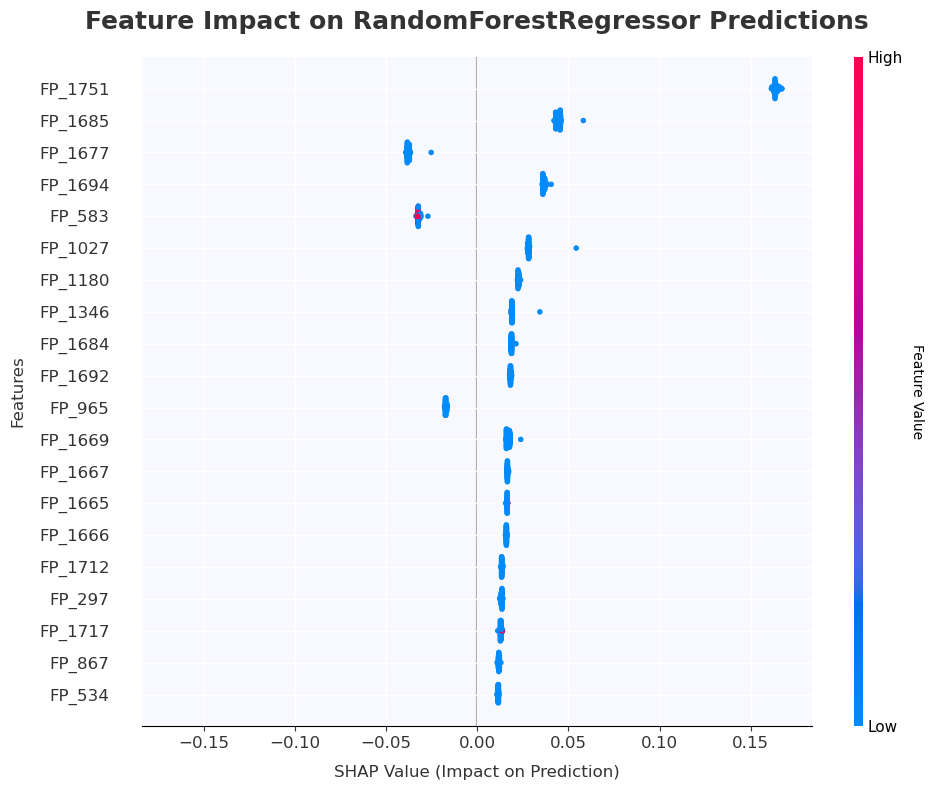

SHAP 分析完成! 图表已保存至: D:/Menin/figures/


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# 配置全局绘图参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 配置参数
CONFIG = {
    "model_path": r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl',  # 随机森林模型路径
    "data_path": r'D:\Menin\excelcsv\menin200more.csv',
    "output_dir": 'D:/Menin/figures/',
    "fingerprint_bits": 2048,
    "shap_samples": 100,
    "max_display": 20,
    "plot_style": {
        "background_color": "#F8F8FF",  # 浅灰色背景
        "grid_color": "white",    # 白色网格线
        "font_size": 12,              # 字体大小
        "dot_size": 20,               # 散点大小
        "cmap": "coolwarm",             # 颜色映射
        "title_fontsize": 18,
        "title_fontweight": "bold",
        "title_color": "#333333",
        "label_color": "#333333"
    },
    "feature_to_remove": "FP_1662" # 要移除的特征名称
}

# 加载数据
def load_data(data_path):
    """加载数据并返回 SMILES 和 pIC50 值"""
    data = pd.read_csv(data_path)
    smiles = data['Smiles']
    pIC50 = data['pIC50']
    return smiles, pIC50

# 计算分子指纹
def calculate_fingerprints(smiles, n_bits=2048):
    """计算分子指纹"""
    fps = []
    valid_indices = []
    for i, smi in enumerate(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    return np.array(fps), valid_indices

# 计算 RDKit 描述符
def calculate_rdkit_descriptors(smiles):
    """计算 RDKit 描述符"""
    descriptors_list = []
    valid_indices = []
    for i, smi in enumerate(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
            descriptors = calc.CalcDescriptors(mol)
            descriptors_list.append(descriptors)
            valid_indices.append(i)
    return np.array(descriptors_list), valid_indices

# 合并特征
def combine_features(fingerprints, descriptors):
    """合并分子指纹和描述符"""
    return np.concatenate((fingerprints, descriptors), axis=1)

# 主函数
def main():
    # 加载数据
    smiles, pIC50 = load_data(CONFIG["data_path"])

    # 计算分子指纹
    fingerprints, valid_indices_fp = calculate_fingerprints(smiles, CONFIG["fingerprint_bits"])

    # 计算 RDKit 描述符
    descriptors, valid_indices_desc = calculate_rdkit_descriptors(smiles)

    # 对齐有效索引
    valid_indices = list(set(valid_indices_fp) & set(valid_indices_desc))
    fingerprints = fingerprints[np.array([valid_indices_fp.index(i) for i in valid_indices])]
    descriptors = descriptors[np.array([valid_indices_desc.index(i) for i in valid_indices])]

    # 合并特征
    X_combined = combine_features(fingerprints, descriptors)
    y = pIC50.iloc[valid_indices].values

    # 加载模型
    pipeline = joblib.load(CONFIG["model_path"])

    # 从 Pipeline 中提取随机森林模型
    if isinstance(pipeline, Pipeline):
        model = pipeline.named_steps['randomforestregressor']
    else:
        model = pipeline

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined[:CONFIG["shap_samples"]])

    # 获取特征名称列表
    feature_names = [f"FP_{i}" for i in range(CONFIG["fingerprint_bits"])] + [x[0] for x in Descriptors._descList]

    # 找到要删除的特征的索引
    try:
        feature_index_to_remove = feature_names.index(CONFIG["feature_to_remove"])
    except ValueError:
        print(f"警告: 特征 '{CONFIG['feature_to_remove']}' 未找到。")
        feature_index_to_remove = None

    # 如果找到了要删除的特征，则删除它
    if feature_index_to_remove is not None:
        shap_values = np.delete(shap_values, feature_index_to_remove, axis=1)
        X_combined = np.delete(X_combined, feature_index_to_remove, axis=1)
        del feature_names[feature_index_to_remove]

    # 绘制 SHAP 图
    plt.figure(figsize=(10, 10)) # 调整为正方形尺寸使图表更对称
    ax = plt.gca()

    # 设置浅色背景和白色网格线
    ax.set_facecolor(CONFIG["plot_style"]["background_color"])
    ax.grid(color=CONFIG["plot_style"]["grid_color"], linestyle='-', linewidth=1)

    # 计算对称的x轴范围
    max_abs_shap = np.max(np.abs(shap_values))
    xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)  # 留10%的边距

    shap.summary_plot(
        shap_values,
        X_combined[:CONFIG["shap_samples"]],
        feature_names=feature_names,
        max_display=CONFIG["max_display"],
        plot_type="dot",
        show=False,
        color=plt.get_cmap(CONFIG["plot_style"]["cmap"]),
        plot_size=(10, 8)
    )

    # 设置对称的x轴范围
    plt.xlim(xlim)

    # 设置标题和标签
    model_name = model.__class__.__name__
    plt.title(f"Feature Impact on {model_name} Predictions",
              fontsize=CONFIG["plot_style"]["title_fontsize"],
              fontweight=CONFIG["plot_style"]["title_fontweight"],
              pad=20,
              color=CONFIG["plot_style"]["title_color"])
    plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=CONFIG["plot_style"]["font_size"], labelpad=10, color=CONFIG["plot_style"]["label_color"])
    plt.ylabel("Features", fontsize=CONFIG["plot_style"]["font_size"], labelpad=10, color=CONFIG["plot_style"]["label_color"])

    # 调整颜色条
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Feature Value', rotation=270, labelpad=15, fontsize=10)

    # 设置字体大小
    plt.xticks(fontsize=CONFIG["plot_style"]["font_size"])
    plt.yticks(fontsize=CONFIG["plot_style"]["font_size"])

    # 保存图表
    plt.tight_layout()
    plt.savefig(
        f"{CONFIG['output_dir']}/shap_summary_plot.png",
        dpi=300,
        bbox_inches='tight',
        facecolor=CONFIG["plot_style"]["background_color"]
    )
    plt.show()

    print("SHAP 分析完成! 图表已保存至:", CONFIG["output_dir"])

if __name__ == "__main__":
    main()


[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerator
[12:07:58] DEPRECATION WARNING: please use MorganGenerat

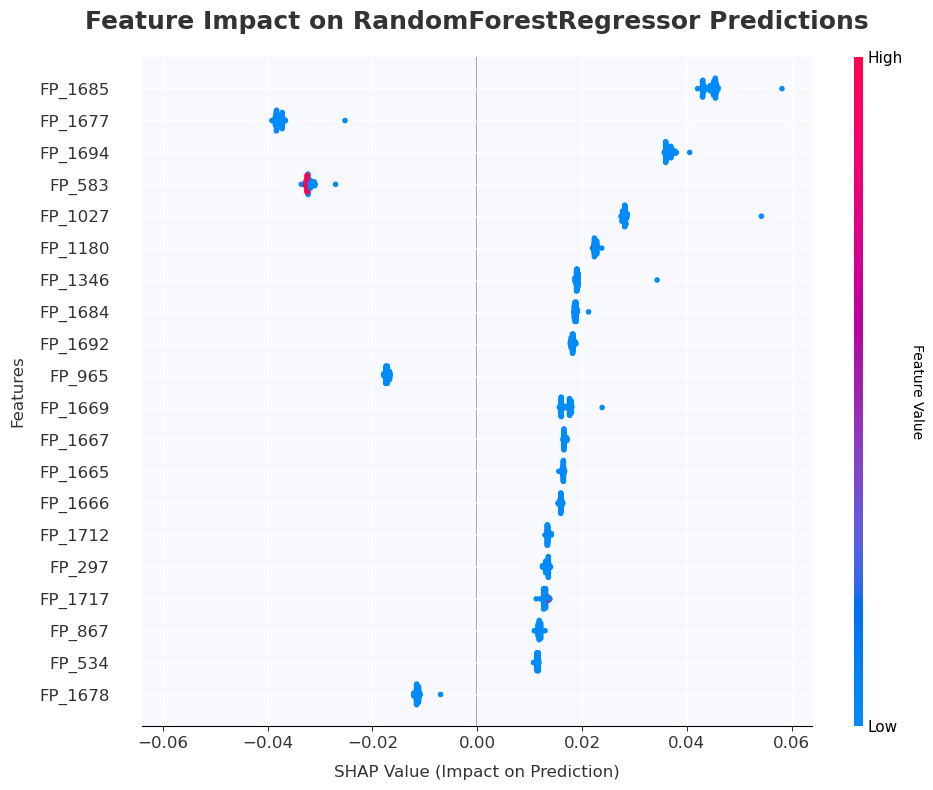

SHAP 分析完成! 图表已保存至: D:/Menin/figures/


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# 配置全局绘图参数
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 配置参数
CONFIG = {
    "model_path": r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl',  # 随机森林模型路径
    "data_path": r'D:\Menin\excelcsv\menin200more.csv',
    "output_dir": 'D:/Menin/figures/',
    "fingerprint_bits": 2048,
    "shap_samples": 100,
    "max_display": 20,
    "plot_style": {
        "background_color": "#F8F8FF",  # 浅灰色背景
        "grid_color": "white",    # 白色网格线
        "font_size": 12,              # 字体大小
        "dot_size": 20,               # 散点大小
        "cmap": "coolwarm",             # 颜色映射
        "title_fontsize": 18,
        "title_fontweight": "bold",
        "title_color": "#333333",
        "label_color": "#333333"
    },
    "features_to_remove": ["FP_1662", "FP_1751"]  # 要移除的特征名称列表
}

# 加载数据
def load_data(data_path):
    """加载数据并返回 SMILES 和 pIC50 值"""
    data = pd.read_csv(data_path)
    smiles = data['Smiles']
    pIC50 = data['pIC50']
    return smiles, pIC50

# 计算分子指纹
def calculate_fingerprints(smiles, n_bits=2048):
    """计算分子指纹"""
    fps = []
    valid_indices = []
    for i, smi in enumerate(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    return np.array(fps), valid_indices

# 计算 RDKit 描述符
def calculate_rdkit_descriptors(smiles):
    """计算 RDKit 描述符"""
    descriptors_list = []
    valid_indices = []
    for i, smi in enumerate(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
            descriptors = calc.CalcDescriptors(mol)
            descriptors_list.append(descriptors)
            valid_indices.append(i)
    return np.array(descriptors_list), valid_indices

# 合并特征
def combine_features(fingerprints, descriptors):
    """合并分子指纹和描述符"""
    return np.concatenate((fingerprints, descriptors), axis=1)

# 主函数
def main():
    # 加载数据
    smiles, pIC50 = load_data(CONFIG["data_path"])

    # 计算分子指纹
    fingerprints, valid_indices_fp = calculate_fingerprints(smiles, CONFIG["fingerprint_bits"])

    # 计算 RDKit 描述符
    descriptors, valid_indices_desc = calculate_rdkit_descriptors(smiles)

    # 对齐有效索引
    valid_indices = list(set(valid_indices_fp) & set(valid_indices_desc))
    fingerprints = fingerprints[np.array([valid_indices_fp.index(i) for i in valid_indices])]
    descriptors = descriptors[np.array([valid_indices_desc.index(i) for i in valid_indices])]

    # 合并特征
    X_combined = combine_features(fingerprints, descriptors)
    y = pIC50.iloc[valid_indices].values

    # 加载模型
    pipeline = joblib.load(CONFIG["model_path"])

    # 从 Pipeline 中提取随机森林模型
    if isinstance(pipeline, Pipeline):
        model = pipeline.named_steps['randomforestregressor']
    else:
        model = pipeline

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined[:CONFIG["shap_samples"]])

    # 获取特征名称列表
    feature_names = [f"FP_{i}" for i in range(CONFIG["fingerprint_bits"])] + [x[0] for x in Descriptors._descList]

    # 存储要删除的特征的索引
    feature_indices_to_remove = []
    for feature_to_remove in CONFIG["features_to_remove"]:
        try:
            feature_index_to_remove = feature_names.index(feature_to_remove)
            feature_indices_to_remove.append(feature_index_to_remove)
        except ValueError:
            print(f"警告: 特征 '{feature_to_remove}' 未找到。")

    # 删除特征，从后往前删除，避免索引错乱
    feature_indices_to_remove.sort(reverse=True)
    for feature_index_to_remove in feature_indices_to_remove:
        shap_values = np.delete(shap_values, feature_index_to_remove, axis=1)
        X_combined = np.delete(X_combined, feature_index_to_remove, axis=1)
        del feature_names[feature_index_to_remove]

    # 绘制 SHAP 图
    plt.figure(figsize=(24, 10)) # 调整为正方形尺寸使图表更对称
    ax = plt.gca()

    # 设置浅色背景和白色网格线
    ax.set_facecolor(CONFIG["plot_style"]["background_color"])
    ax.grid(color=CONFIG["plot_style"]["grid_color"], linestyle='-', linewidth=1)

    # 计算对称的x轴范围
    max_abs_shap = np.max(np.abs(shap_values))
    xlim = (-max_abs_shap * 1.1, max_abs_shap * 1.1)  # 留10%的边距

    shap.summary_plot(
        shap_values,
        X_combined[:CONFIG["shap_samples"]],
        feature_names=feature_names,
        max_display=CONFIG["max_display"],
        plot_type="dot",
        show=False,
        color=plt.get_cmap(CONFIG["plot_style"]["cmap"]),
        plot_size=(10, 8)
    )

    # 设置对称的x轴范围
    plt.xlim(xlim)

    # 设置标题和标签
    model_name = model.__class__.__name__
    plt.title(f"Feature Impact on {model_name} Predictions",
              fontsize=CONFIG["plot_style"]["title_fontsize"],
              fontweight=CONFIG["plot_style"]["title_fontweight"],
              pad=20,
              color=CONFIG["plot_style"]["title_color"])
    plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=CONFIG["plot_style"]["font_size"], labelpad=10, color=CONFIG["plot_style"]["label_color"])
    plt.ylabel("Features", fontsize=CONFIG["plot_style"]["font_size"], labelpad=10, color=CONFIG["plot_style"]["label_color"])

    # 调整颜色条
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Feature Value', rotation=270, labelpad=15, fontsize=10)

    # 设置字体大小
    plt.xticks(fontsize=CONFIG["plot_style"]["font_size"])
    plt.yticks(fontsize=CONFIG["plot_style"]["font_size"])

    # 保存图表
    plt.tight_layout()
    plt.savefig(
        f"{CONFIG['output_dir']}/shap_summary_plot.png",
        dpi=300,
        bbox_inches='tight',
        facecolor=CONFIG["plot_style"]["background_color"]
    )
    plt.show()

    print("SHAP 分析完成! 图表已保存至:", CONFIG["output_dir"])

if __name__ == "__main__":
    main()


计算RDKit描述符...


[16:20:26] DEPRECATION WARNING: please use MorganGenerator
[16:20:26] DEPRECATION WARNING: please use MorganGenerator
[16:20:26] DEPRECATION WARNING: please use MorganGenerator
[16:20:26] DEPRECATION WARNING: please use MorganGenerator
[16:20:26] DEPRECATION WARNING: please use MorganGenerator
[16:20:26] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:27] DEPRECATION WARNING: please use MorganGenerator
[16:20:28] DEPRECATION WARNING: please use MorganGenerator
[16:20:28] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...

原始特征数: 2258
AtomPair指纹维度: 2048
RDKit描述符维度: 210

尝试加载预训练的基模型...


[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION WARNING: please use AtomPairGenerator
[16:21:09] DEPRECATION W

基模型加载成功!
加载预训练模型失败: 'tuple' object has no attribute 'steps'
将重新训练所有基模型...

训练HistGradientBoosting模型...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 fo

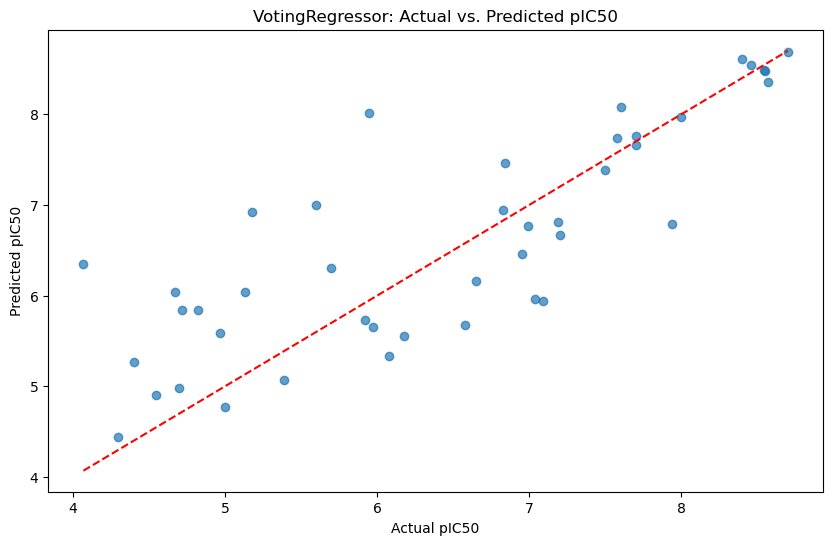


完成!


In [61]:
 import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    VotingRegressor
)
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.base import clone
import matplotlib.pyplot as plt

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 检查特征维度
print(f"\n原始特征数: {X_combined.shape[1]}")
print(f"AtomPair指纹维度: {X_fp.shape[1]}")
print(f"RDKit描述符维度: {X_desc.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建通用预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VarianceThreshold(threshold=0.01)
)

# 加载或训练基模型
try:
    # 尝试加载预训练的基模型
    print("\n尝试加载预训练的基模型...")
    hgb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    rf_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    gb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')
    print("基模型加载成功!")
    
    # 确保加载的是回归器
    if not hasattr(hgb_model.steps[-1][1], 'predict'):
        raise ValueError("HistGradientBoosting模型不是回归器")
    if not hasattr(rf_model.steps[-1][1], 'predict'):
        raise ValueError("RandomForest模型不是回归器")
    if not hasattr(gb_model.steps[-1][1], 'predict'):
        raise ValueError("GradientBoosting模型不是回归器")
except Exception as e:
    print(f"加载预训练模型失败: {e}")
    print("将重新训练所有基模型...")
    
    # 1. 训练HistGradientBoosting模型
    print("\n训练HistGradientBoosting模型...")
    hgb_param_space = {
        'histgradientboostingregressor__max_iter': Integer(100, 1000),
        'histgradientboostingregressor__learning_rate': Real(0.01, 0.2, 'log-uniform'),
        'histgradientboostingregressor__max_leaf_nodes': Integer(20, 100),
        'histgradientboostingregressor__min_samples_leaf': Integer(5, 50),
        'histgradientboostingregressor__l2_regularization': Real(0.01, 10, 'log-uniform'),
        'histgradientboostingregressor__max_bins': Integer(100, 255)
    }
    
    hgb_pipeline = make_pipeline(
        clone(preprocessor),
        HistGradientBoostingRegressor(random_state=42)
    )
    
    hgb_opt = BayesSearchCV(
        estimator=hgb_pipeline,
        search_spaces=hgb_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    hgb_opt.fit(X_train, y_train)
    hgb_model = hgb_opt.best_estimator_
    joblib.dump(hgb_model, r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    
    # 2. 训练RandomForest模型
    print("\n训练RandomForest模型...")
    rf_param_space = {
        'randomforestregressor__n_estimators': Integer(100, 1000),
        'randomforestregressor__max_depth': Integer(5, 50),
        'randomforestregressor__min_samples_split': Integer(2, 20),
        'randomforestregressor__min_samples_leaf': Integer(1, 10),
        'randomforestregressor__max_features': Real(0.1, 1.0, prior='uniform')
    }
    
    rf_pipeline = make_pipeline(
        clone(preprocessor),
        RandomForestRegressor(random_state=42)
    )
    
    rf_opt = BayesSearchCV(
        estimator=rf_pipeline,
        search_spaces=rf_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    rf_opt.fit(X_train, y_train)
    rf_model = rf_opt.best_estimator_
    joblib.dump(rf_model, r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    
    # 3. 训练GradientBoosting模型
    print("\n训练GradientBoosting模型...")
    gb_param_space = {
        'gradientboostingregressor__n_estimators': Integer(50, 300),
        'gradientboostingregressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'gradientboostingregressor__max_depth': Integer(3, 10),
        'gradientboostingregressor__min_samples_split': Integer(2, 10),
        'gradientboostingregressor__min_samples_leaf': Integer(1, 10),
        'gradientboostingregressor__subsample': Real( 0.5, 1.0, prior='uniform'),
        'gradientboostingregressor__max_features': Categorical(['sqrt', 'log2', None])
    }

    gb_pipeline = make_pipeline(
        clone(preprocessor),
        GradientBoostingRegressor(random_state=42)
    )

    gb_opt = BayesSearchCV(
        estimator=gb_pipeline,
        search_spaces=gb_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    gb_opt.fit(X_train, y_train)
    gb_model = gb_opt.best_estimator_
    joblib.dump(gb_model, r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')

# 创建VotingRegressor
print("\n创建VotingRegressor...")
voting_regressor = VotingRegressor(
    estimators=[
        ('hgb', hgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    weights=[0.4, 0.3, 0.3]  # 调整权重
)

# 训练VotingRegressor
print("\n训练VotingRegressor...")
voting_regressor.fit(X_train, y_train)

# 评估VotingRegressor
print("\n评估VotingRegressor...")
y_pred_voting = voting_regressor.predict(X_test)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
r2_voting = r2_score(y_test, y_pred_voting)

print(f"VotingRegressor RMSE: {rmse_voting:.4f}")
print(f"VotingRegressor R^2: {r2_voting:.4f}")

# 单独评估基模型 (可选，用于比较)
print("\n单独评估基模型...")
for name, model in [('HistGradientBoosting', hgb_model), ('RandomForest', rf_model), ('GradientBoosting', gb_model)]:
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} R^2: {r2:.4f}")

# 可视化预测结果 (可选)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_voting, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("VotingRegressor: Actual vs. Predicted pIC50")
plt.show()

print("\n完成!")


计算RDKit描述符...


[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:44] DEPRECATION WARNING: please use MorganGenerator
[16:40:45] DEPRECATION WARNING: please use MorganGenerator
[16:40:45] DEPRECATION WARNING: please use MorganGenerator
[16:40:45] DEPRECATION WARNING: please use MorganGenerator
[16:40:45] DEPRECATION WARNING: please use MorganGenerator
[16:40:45] DEPRECATION WARNING: please use MorganGenerator
[16:40:45] DEPRECATION WARNING: please use MorganGenerator
[16:40:46] DEPRECATION WARNING: please use MorganGenerator
[16:40:46] DEPRECATION WARNING: please use MorganGenerat

计算AtomPair指纹...

原始特征数: 2258
AtomPair指纹维度: 2048
RDKit描述符维度: 210

尝试加载预训练的基模型...


[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION WARNING: please use AtomPairGenerator
[16:41:28] DEPRECATION W

基模型加载成功!

创建VotingRegressor...

训练VotingRegressor...

评估VotingRegressor...
VotingRegressor RMSE: 0.8176
VotingRegressor R^2: 0.6468

单独评估基模型...
HistGradientBoosting RMSE: 0.8116
HistGradientBoosting R^2: 0.6520
RandomForest RMSE: 0.8550
RandomForest R^2: 0.6138
GradientBoosting RMSE: 0.8218
GradientBoosting R^2: 0.6432


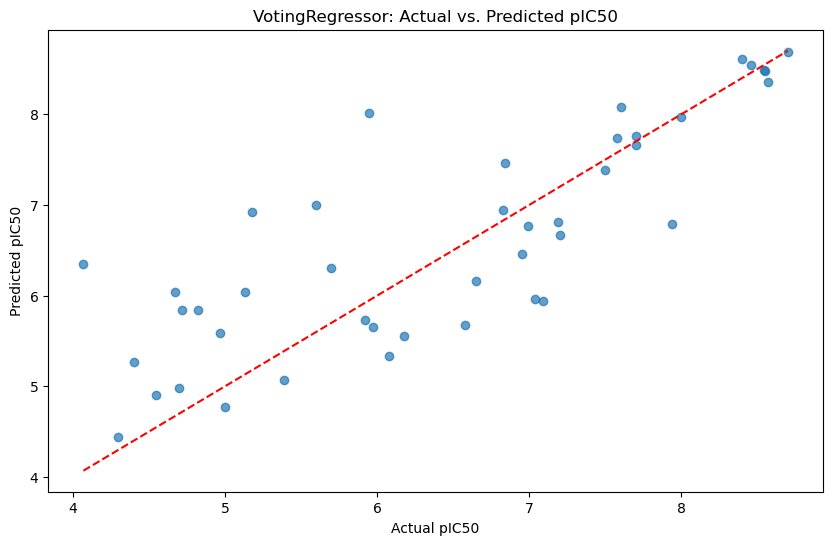


Performing 5-Fold Cross-Validation for VotingRegressor...
Fold 1
Fold 1 RMSE: 0.8180
Fold 1 R^2: 0.6465
Fold 2
Fold 2 RMSE: 0.6071
Fold 2 R^2: 0.7799
Fold 3
Fold 3 RMSE: 0.7748
Fold 3 R^2: 0.7467
Fold 4
Fold 4 RMSE: 0.5248
Fold 4 R^2: 0.8752
Fold 5
Fold 5 RMSE: 0.5194
Fold 5 R^2: 0.8755

Cross-Validation Results:
Mean RMSE: 0.6488 (+/- 0.1252)
Mean R^2: 0.7848 (+/- 0.0860)

完成!


In [62]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    VotingRegressor
)
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.base import clone
import matplotlib.pyplot as plt

# 配置
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair指纹计算函数
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """计算AtomPair分子指纹"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit描述符计算函数
def calculate_rdkit_descriptors(smiles):
    """计算RDKit描述符"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 使用MoleculeDescriptors计算所有可用描述符
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # 添加3D描述符
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("计算RDKit描述符...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("计算AtomPair指纹...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 检查特征维度
print(f"\n原始特征数: {X_combined.shape[1]}")
print(f"AtomPair指纹维度: {X_fp.shape[1]}")
print(f"RDKit描述符维度: {X_desc.shape[1]}")

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建通用预处理管道
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VarianceThreshold(threshold=0.01)
)

# 加载或训练基模型
try:
    # 尝试加载预训练的基模型
    print("\n尝试加载预训练的基模型...")
    hgb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    rf_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    gb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')
    print("基模型加载成功!")
    
    # 确保加载的是回归器
    if not hasattr(hgb_model.steps[-1][1], 'predict'):
        raise ValueError("HistGradientBoosting模型不是回归器")
    if not hasattr(rf_model.steps[-1][1], 'predict'):
        raise ValueError("RandomForest模型不是回归器")
    if not hasattr(gb_model.steps[-1][1], 'predict'):
        raise ValueError("GradientBoosting模型不是回归器")
except Exception as e:
    print(f"加载预训练模型失败: {e}")
    print("将重新训练所有基模型...")
    
    # 1. 训练HistGradientBoosting模型
    print("\n训练HistGradientBoosting模型...")
    hgb_param_space = {
        'histgradientboostingregressor__max_iter': Integer(100, 1000),
        'histgradientboostingregressor__learning_rate': Real(0.01, 0.2, 'log-uniform'),
        'histgradientboostingregressor__max_leaf_nodes': Integer(20, 100),
        'histgradientboostingregressor__min_samples_leaf': Integer(5, 50),
        'histgradientboostingregressor__l2_regularization': Real(0.01, 10, 'log-uniform'),
        'histgradientboostingregressor__max_bins': Integer(100, 255)
    }
    
    hgb_pipeline = make_pipeline(
        clone(preprocessor),
        HistGradientBoostingRegressor(random_state=42)
    )
    
    hgb_opt = BayesSearchCV(
        estimator=hgb_pipeline,
        search_spaces=hgb_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    hgb_opt.fit(X_train, y_train)
    hgb_model = hgb_opt.best_estimator_
    joblib.dump(hgb_model, r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    
    # 2. 训练RandomForest模型
    print("\n训练RandomForest模型...")
    rf_param_space = {
        'randomforestregressor__n_estimators': Integer(100, 1000),
        'randomforestregressor__max_depth': Integer(5, 50),
        'randomforestregressor__min_samples_split': Integer(2, 20),
        'randomforestregressor__min_samples_leaf': Integer(1, 10),
        'randomforestregressor__max_features': Real(0.1, 1.0, prior='uniform')
    }
    
    rf_pipeline = make_pipeline(
        clone(preprocessor),
        RandomForestRegressor(random_state=42)
    )
    
    rf_opt = BayesSearchCV(
        estimator=rf_pipeline,
        search_spaces=rf_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    rf_opt.fit(X_train, y_train)
    rf_model = rf_opt.best_estimator_
    joblib.dump(rf_model, r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    
    # 3. 训练GradientBoosting模型
    print("\n训练GradientBoosting模型...")
    gb_param_space = {
        'gradientboostingregressor__n_estimators': Integer(50, 300),
        'gradientboostingregressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'gradientboostingregressor__max_depth': Integer(3, 10),
        'gradientboostingregressor__min_samples_split': Integer(2, 10),
        'gradientboostingregressor__min_samples_leaf': Integer(1, 10),
        'gradientboostingregressor__subsample': Real( 0.5, 1.0, prior='uniform'),
        'gradientboostingregressor__max_features': Categorical(['sqrt', 'log2', None])
    }

    gb_pipeline = make_pipeline(
        clone(preprocessor),
        GradientBoostingRegressor(random_state=42)
    )

    gb_opt = BayesSearchCV(
        estimator=gb_pipeline,
        search_spaces=gb_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    gb_opt.fit(X_train, y_train)
    gb_model = gb_opt.best_estimator_
    joblib.dump(gb_model, r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')

# 创建VotingRegressor
print("\n创建VotingRegressor...")
voting_regressor = VotingRegressor(
    estimators=[
        ('hgb', hgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    weights=[0.4, 0.3, 0.3]  # 调整权重
)

# 训练VotingRegressor
print("\n训练VotingRegressor...")
voting_regressor.fit(X_train, y_train)

# 评估VotingRegressor
print("\n评估VotingRegressor...")
y_pred_voting = voting_regressor.predict(X_test)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
r2_voting = r2_score(y_test, y_pred_voting)

print(f"VotingRegressor RMSE: {rmse_voting:.4f}")
print(f"VotingRegressor R^2: {r2_voting:.4f}")

# 单独评估基模型 (可选，用于比较)
print("\n单独评估基模型...")
for name, model in [('HistGradientBoosting', hgb_model), ('RandomForest', rf_model), ('GradientBoosting', gb_model)]:
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} R^2: {r2:.4f}")

# 可视化预测结果 (可选)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_voting, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("VotingRegressor: Actual vs. Predicted pIC50")
plt.show()

# 5-Fold Cross-Validation for VotingRegressor
print("\nPerforming 5-Fold Cross-Validation for VotingRegressor...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_combined, y)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Clone the VotingRegressor to avoid modifying the original
    voting_regressor_fold = clone(voting_regressor)

    # Train the VotingRegressor on the current fold's training data
    voting_regressor_fold.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    y_pred_fold = voting_regressor_fold.predict(X_val_fold)

    # Calculate RMSE and R^2 for the current fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

    print(f"Fold {fold + 1} RMSE: {rmse_fold:.4f}")
    print(f"Fold {fold + 1} R^2: {r2_fold:.4f}")

# Calculate and print the mean and standard deviation of the cross-validation scores
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print("\nCross-Validation Results:")
print(f"Mean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})")
print(f"Mean R^2: {mean_r2:.4f} (+/- {std_r2:.4f})")

print("\n完成!")


In [67]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    VotingRegressor
)
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Integer, Real
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.base import clone
import matplotlib.pyplot as plt

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Data loading
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair fingerprints calculation
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """Calculate AtomPair molecular fingerprints"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit descriptors calculation
def calculate_rdkit_descriptors(smiles):
    """Calculate RDKit descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Calculate all available descriptors
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # Add 3D descriptors
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Check feature dimensions
print(f"\nOriginal feature count: {X_combined.shape[1]}")
print(f"AtomPair fingerprint dimension: {X_fp.shape[1]}")
print(f"RDKit descriptors dimension: {X_desc.shape[1]}")

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create common preprocessing pipeline
preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VarianceThreshold(threshold=0.01)
)

# Load or train base models
try:
    # Try to load pre-trained base models
    print("\nAttempting to load pre-trained base models...")
    hgb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    rf_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    gb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')
    print("Base models loaded successfully!")
    
    # Verify the loaded models are regressors
    if not hasattr(hgb_model.steps[-1][1], 'predict'):
        raise ValueError("HistGradientBoosting model is not a regressor")
    if not hasattr(rf_model.steps[-1][1], 'predict'):
        raise ValueError("RandomForest model is not a regressor")
    if not hasattr(gb_model.steps[-1][1], 'predict'):
        raise ValueError("GradientBoosting model is not a regressor")
except Exception as e:
    print(f"Failed to load pre-trained models: {e}")
    print("Will retrain all base models...")
    
    # 1. Train HistGradientBoosting model
    print("\nTraining HistGradientBoosting model...")
    hgb_param_space = {
        'histgradientboostingregressor__max_iter': Integer(100, 1000),
        'histgradientboostingregressor__learning_rate': Real(0.01, 0.2, 'log-uniform'),
        'histgradientboostingregressor__max_leaf_nodes': Integer(20, 100),
        'histgradientboostingregressor__min_samples_leaf': Integer(5, 50),
        'histgradientboostingregressor__l2_regularization': Real(0.01, 10, 'log-uniform'),
        'histgradientboostingregressor__max_bins': Integer(100, 255)
    }
    
    hgb_pipeline = make_pipeline(
        clone(preprocessor),
        HistGradientBoostingRegressor(random_state=42)
    )
    
    hgb_opt = BayesSearchCV(
        estimator=hgb_pipeline,
        search_spaces=hgb_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    hgb_opt.fit(X_train, y_train)
    hgb_model = hgb_opt.best_estimator_
    joblib.dump(hgb_model, r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    
    # 2. Train RandomForest model
    print("\nTraining RandomForest model...")
    rf_param_space = {
        'randomforestregressor__n_estimators': Integer(100, 1000),
        'randomforestregressor__max_depth': Integer(5, 50),
        'randomforestregressor__min_samples_split': Integer(2, 20),
        'randomforestregressor__min_samples_leaf': Integer(1, 10),
        'randomforestregressor__max_features': Real(0.1, 1.0, prior='uniform')
    }
    
    rf_pipeline = make_pipeline(
        clone(preprocessor),
        RandomForestRegressor(random_state=42)
    )
    
    rf_opt = BayesSearchCV(
        estimator=rf_pipeline,
        search_spaces=rf_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    rf_opt.fit(X_train, y_train)
    rf_model = rf_opt.best_estimator_
    joblib.dump(rf_model, r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    
    # 3. Train GradientBoosting model
    print("\nTraining GradientBoosting model...")
    gb_param_space = {
        'gradientboostingregressor__n_estimators': Integer(50, 300),
        'gradientboostingregressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'gradientboostingregressor__max_depth': Integer(3, 10),
        'gradientboostingregressor__min_samples_split': Integer(2, 10),
        'gradientboostingregressor__min_samples_leaf': Integer(1, 10),
        'gradientboostingregressor__subsample': Real(0.5, 1.0, prior='uniform')
    }

    gb_pipeline = make_pipeline(
        clone(preprocessor),
        GradientBoostingRegressor(random_state=42)
    )

    gb_opt = BayesSearchCV(
        estimator=gb_pipeline,
        search_spaces=gb_param_space,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    gb_opt.fit(X_train, y_train)
    gb_model = gb_opt.best_estimator_
    joblib.dump(gb_model, r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')

# Create VotingRegressor
print("\nCreating VotingRegressor...")
voting_regressor = VotingRegressor(
    estimators=[
        ('hgb', hgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    weights=[0.4, 0.3, 0.3]  # Initial weights
)

# Define objective function for weight optimization
def voting_objective(weights):
    """Objective function for weight optimization."""
    # Ensure we have 3 weights (one for each model)
    if len(weights) != 3:
        raise ValueError("Must provide exactly 3 weights")
    
    # Normalize weights to sum to 1
    weights = np.array(weights)
    weights = weights / weights.sum()

    # Create VotingRegressor with current weights
    vr = VotingRegressor(
        estimators=[
            ('hgb', hgb_model),
            ('rf', rf_model),
            ('gb', gb_model)
        ],
        weights=weights
    )

    # Perform cross-validation
    cv_results = cross_validate(
        vr,
        X_train,
        y_train,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        return_estimator=False
    )

    return np.mean(cv_results['test_score'])

# Define parameter space for optimization (3 weights)
voting_param_space = [
    Real(0.1, 0.9),  # Weight for HGB
    Real(0.1, 0.9),  # Weight for RF
    Real(0.1, 0.9)   # Weight for GB
]

# Run optimization
print("\nOptimizing VotingRegressor weights...")
result = gp_minimize(
    voting_objective,
    dimensions=voting_param_space,
    n_calls=30,
    random_state=42,
    n_jobs=-1,
    verbose=True
)

# Get best weights and normalize
best_weights = np.array(result.x)
best_weights = best_weights / best_weights.sum()

print(f"\nOptimized weights: HGB={best_weights[0]:.4f}, RF={best_weights[1]:.4f}, GB={best_weights[2]:.4f}")

# Create optimized VotingRegressor
optimized_voting_regressor = VotingRegressor(
    estimators=[
        ('hgb', hgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    weights=best_weights
)

# Train on full training set
optimized_voting_regressor.fit(X_train, y_train)

# Evaluate on test set
y_pred_optimized = optimized_voting_regressor.predict(X_test)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"\nOptimized VotingRegressor Performance:")
print(f"RMSE: {rmse_optimized:.4f}")
print(f"R²: {r2_optimized:.4f}")

# 5-Fold Cross-Validation
print("\nPerforming 5-Fold Cross-Validation...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_combined, y)):
    print(f"\nFold {fold + 1}")

    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Clone the optimized VotingRegressor
    voting_regressor_fold = clone(optimized_voting_regressor)

    # Train on current fold
    voting_regressor_fold.fit(X_train_fold, y_train_fold)

    # Predict on validation set
    y_pred_fold = voting_regressor_fold.predict(X_val_fold)

    # Calculate metrics
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

    print(f"Fold {fold + 1} RMSE: {rmse_fold:.4f}")
    print(f"Fold {fold + 1} R²: {r2_fold:.4f}")

# Calculate mean and std of CV scores
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print("\nCross-Validation Results:")
print(f"Mean RMSE: {mean_rmse:.4f} (± {std_rmse:.4f})")
print(f"Mean R²: {mean_r2:.4f} (± {std_r2:.4f})")

print("\nComplete!")


Calculating RDKit descriptors...


[16:57:44] DEPRECATION WARNING: please use MorganGenerator
[16:57:44] DEPRECATION WARNING: please use MorganGenerator
[16:57:44] DEPRECATION WARNING: please use MorganGenerator
[16:57:44] DEPRECATION WARNING: please use MorganGenerator
[16:57:44] DEPRECATION WARNING: please use MorganGenerator
[16:57:44] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:45] DEPRECATION WARNING: please use MorganGenerator
[16:57:46] DEPRECATION WARNING: please use MorganGenerator
[16:57:46] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...

Original feature count: 2258
AtomPair fingerprint dimension: 2048
RDKit descriptors dimension: 210

Attempting to load pre-trained base models...


[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION WARNING: please use AtomPairGenerator
[16:58:29] DEPRECATION W

Base models loaded successfully!

Creating VotingRegressor...

Optimizing VotingRegressor weights...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 24.5096
Function value obtained: -0.6181
Current minimum: -0.6181
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 24.7335
Function value obtained: -0.6249
Current minimum: -0.6249
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 25.2450
Function value obtained: -0.6236
Current minimum: -0.6249
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 25.1824
Function value obtained: -0.6172
Current minimum: -0.6249
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random poin

In [70]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    VotingRegressor
)
from skopt import gp_minimize
from skopt.space import Integer, Real
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Data loading
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# AtomPair fingerprints calculation
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    """Calculate AtomPair molecular fingerprints"""
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# RDKit descriptors calculation
def calculate_rdkit_descriptors(smiles):
    """Calculate RDKit descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Calculate all available descriptors
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    # Add 3D descriptors
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Check feature dimensions
print(f"\nOriginal feature count: {X_combined.shape[1]}")
print(f"AtomPair fingerprint dimension: {X_fp.shape[1]}")
print(f"RDKit descriptors dimension: {X_desc.shape[1]}")

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create common preprocessing pipeline with LGBM feature selection
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Base model training with RandomizedSearchCV
def train_base_model(model, param_dist, X, y):
    pipeline = Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', model)
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        param_dist,
        n_iter=30,
        cv=KFold(5, shuffle=True, random_state=42),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X, y)
    print(f"Best score: {search.best_score_:.4f}")
    return search.best_estimator_

# Train or load base models
try:
    print("\nAttempting to load pre-trained base models...")
    hgb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    rf_model = joblib.load(r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    gb_model = joblib.load(r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')
    print("Base models loaded successfully!")
except Exception as e:
    print(f"Failed to load pre-trained models: {e}")
    print("Will retrain all base models...")
    
    # 1. Train HistGradientBoosting model
    print("\nTraining HistGradientBoosting model...")
    hgb_param_dist = {
        'model__max_iter': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_leaf_nodes': randint(20, 100),
        'model__min_samples_leaf': randint(5, 50),
        'model__l2_regularization': uniform(0.01, 10),
        'model__max_bins': randint(100, 255)
    }
    hgb_model = train_base_model(
        HistGradientBoostingRegressor(random_state=42),
        hgb_param_dist,
        X_train, y_train
    )
    joblib.dump(hgb_model, r'D:\Menin\joblibpipeline\opt_combined_histgradient_model.pkl')
    
    # 2. Train RandomForest model
    print("\nTraining RandomForest model...")
    rf_param_dist = {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(5, 50),
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': uniform(0.1, 1.0)
    }
    rf_model = train_base_model(
        RandomForestRegressor(random_state=42),
        rf_param_dist,
        X_train, y_train
    )
    joblib.dump(rf_model, r'D:\Menin\joblibpipeline\opt_combined_randomforest_model.pkl')
    
    # 3. Train GradientBoosting model
    print("\nTraining GradientBoosting model...")
    gb_param_dist = {
        'model__n_estimators': randint(50, 300),
        'model__learning_rate': uniform(0.01, 1.0),
        'model__max_depth': randint(3, 10),
        'model__min_samples_split': randint(2, 10),
        'model__min_samples_leaf': randint(1, 10),
        'model__subsample': uniform(0.5, 1.0)
    }
    gb_model = train_base_model(
        GradientBoostingRegressor(random_state=42),
        gb_param_dist,
        X_train, y_train
    )
    joblib.dump(gb_model, r'D:\Menin\joblibpipeline\opt_selected_gb_model.pkl')

# VotingRegressor with weight optimization
def optimize_voting_weights():
    def objective(weights):
        weights = np.array(weights)
        weights = weights / weights.sum()
        
        vr = VotingRegressor(
            estimators=[
                ('hgb', hgb_model),
                ('rf', rf_model),
                ('gb', gb_model)
            ],
            weights=weights,
            n_jobs=-1
        )
        
        


Calculating RDKit descriptors...


[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...

Original feature count: 2258
AtomPair fingerprint dimension: 2048
RDKit descriptors dimension: 210

Attempting to load pre-trained base models...


[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION WARNING: please use AtomPairGenerator
[18:56:17] DEPRECATION W

Base models loaded successfully!



Running 5-Fold Cross Validation for VotingRegressor...

Fold 1/5
Train R²: 0.9671 | Val R²: 0.8184
Train RMSE: 0.2661 | Val RMSE: 0.5943

Fold 2/5
Train R²: 0.9649 | Val R²: 0.7433
Train RMSE: 0.2633 | Val RMSE: 0.8202

Fold 3/5
Train R²: 0.9665 | Val R²: 0.8390
Train RMSE: 0.2671 | Val RMSE: 0.5875

Fold 4/5
Train R²: 0.9702 | Val R²: 0.8101
Train RMSE: 0.2561 | Val RMSE: 0.5917

Fold 5/5
Train R²: 0.9608 | Val R²: 0.8576
Train RMSE: 0.2930 | Val RMSE: 0.5141


Cross-Validation Summary:
Metric                 Training      Validation
R²              0.9659 ± 0.0031 0.8137 ± 0.0389
RMSE            0.2691 ± 0.0126 0.6216 ± 0.1037

Final Evaluation on Test Set:
Test R²: 0.6415
Test RMSE: 0.8238


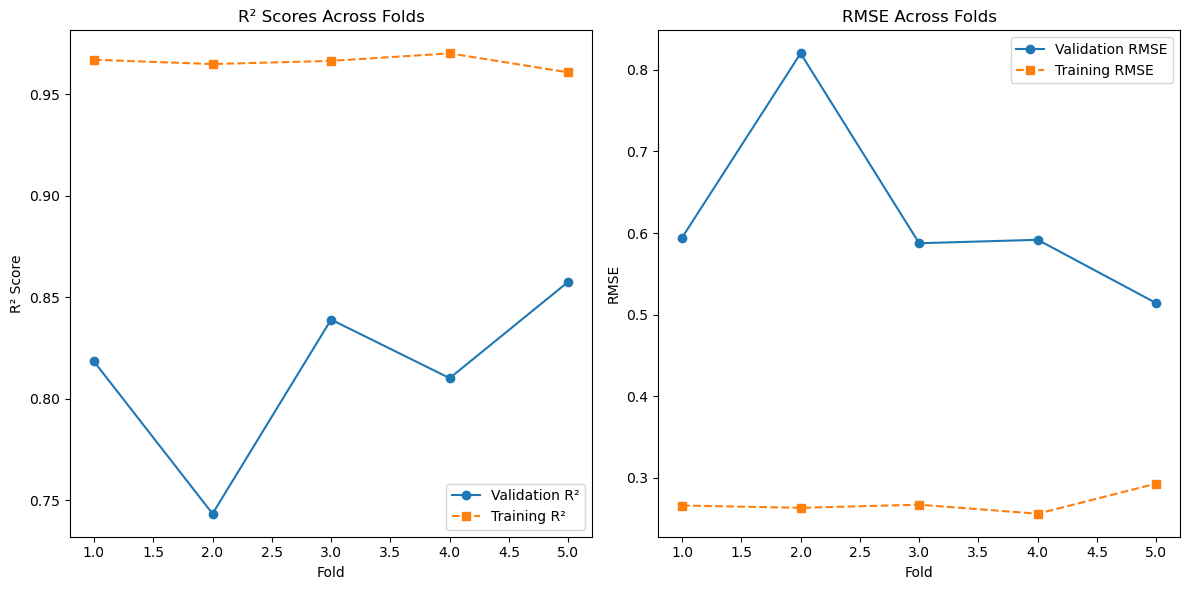

In [69]:
# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for VotingRegressor...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create VotingRegressor with current weights
    vr = VotingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        weights=[0.4, 0.3, 0.3],  # Initial weights or optimized weights
        n_jobs=-1
    )
    
    # Train
    vr.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = vr.predict(X_tr)
    y_val_pred = vr.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Test set evaluation
print("\nFinal Evaluation on Test Set:")
test_pred = vr.predict(X_test)
test_r2 = r2_score(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()


Calculating RDKit descriptors...


[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:20] DEPRECATION WARNING: please use MorganGenerator
[20:50:20] DEPRECATION WARNING: please use MorganGenerator
[20:50:20] DEPRECATION WARNING: please use MorganGenerator
[20:50:20] DEPRECATION WARNING: please use MorganGenerator
[20:50:20] DEPRECATION WARNING: please use MorganGenerator
[20:50:20] DEPRECATION WARNING: please use MorganGenerator
[20:50:21] DEPRECATION WARNING: please use MorganGenerator
[20:50:21] DEPRECATION WARNING: please use MorganGenerator
[20:50:21] DEPRECATION WARNING: please use MorganGenerator
[20:50:21] DEPRECATION WARNING: please use MorganGenerator
[20:50:21] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...


[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION WARNING: please use AtomPairGenerator
[20:51:08] DEPRECATION W

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10003
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1036
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

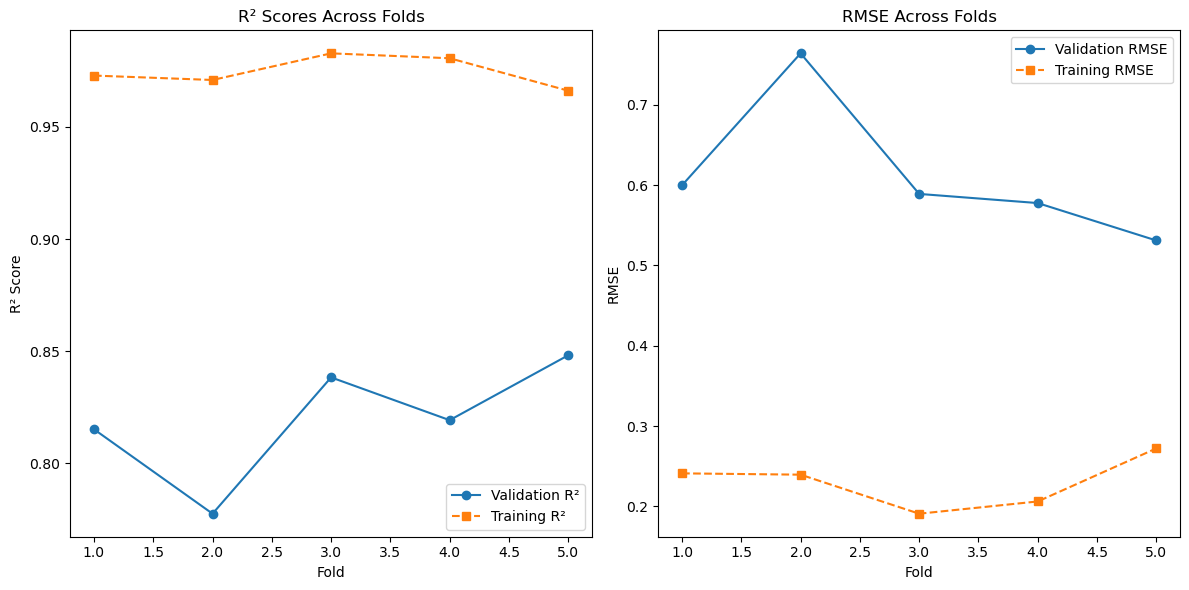

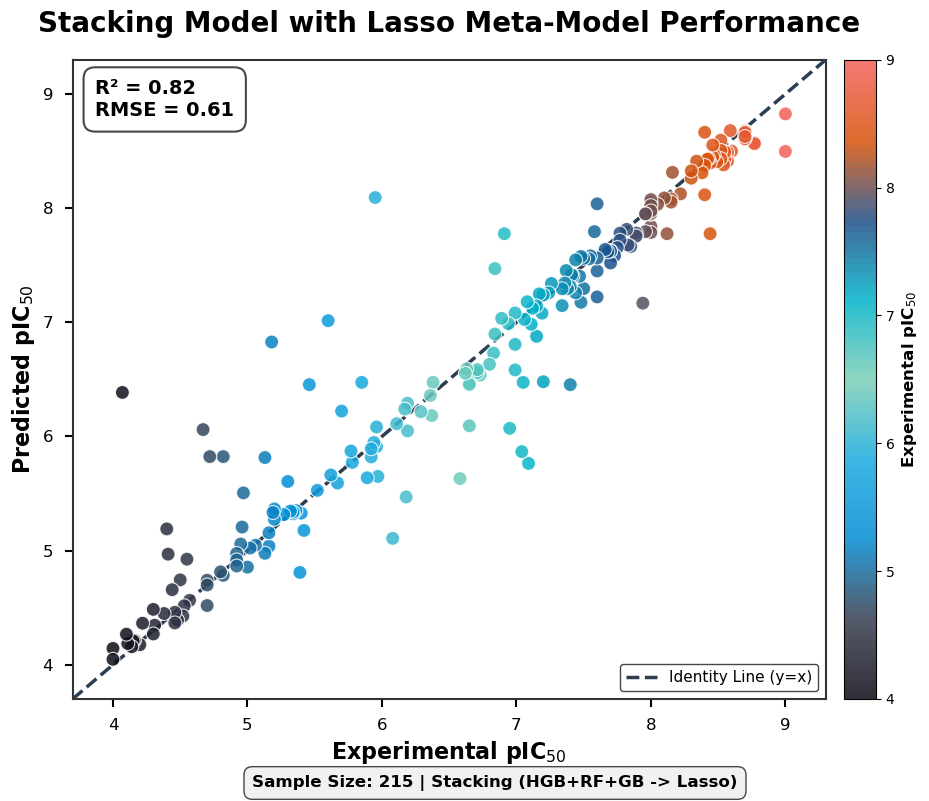


Final Model Performance:
Cross-Validation R²: 0.8196
Cross-Validation RMSE: 0.6122
All Data R²: 0.9193
All Data RMSE: 0.4118
Performance chart saved to: D:/Menin/figures/stacking_lasso_performance.png


In [86]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.base import clone
import joblib
import warnings
from matplotlib.colors import LinearSegmentedColormap

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Load data
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# Calculate AtomPair fingerprints
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# Calculate RDKit descriptors
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define base models
hgb_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train base models
print("\nTraining base models...")
hgb_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

# Define base models for stacking
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Create optimized Lasso meta-model
lasso_meta = Lasso(alpha=0.01, max_iter=10000, random_state=42)

# Create Stacking model with Lasso as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=lasso_meta,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Use only base model predictions as features
)

# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for Stacking Model with Lasso...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create Stacking model with current models
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=clone(lasso_meta),
        cv=5,
        n_jobs=-1
    )
    
    # Train
    current_stack.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Final model training and evaluation
print("\nTraining final stacking model with Lasso meta-model on full training set...")
stacking_model.fit(X_train_preprocessed, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test_preprocessed)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nTest Set Performance:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Save the model
print("\nSaving the model...")
joblib.dump(stacking_model, 'stacking_model_lasso_meta.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of predictions vs actual values
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Predict on all data using the stacking model
y_all_pred = stacking_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))
cv_r2 = mean_val_r2
cv_rmse = mean_val_rmse

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('Stacking Model with Lasso Meta-Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.2f}\n'
              f'RMSE = {cv_rmse:.2f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Stacking (HGB+RF+GB -> Lasso)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/stacking_lasso_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Model Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/stacking_lasso_performance.png")


Calculating RDKit descriptors...


[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:18] DEPRECATION WARNING: please use MorganGenerator
[19:09:19] DEPRECATION WARNING: please use MorganGenerator
[19:09:19] DEPRECATION WARNING: please use MorganGenerator
[19:09:19] DEPRECATION WARNING: please use MorganGenerator
[19:09:19] DEPRECATION WARNING: please use MorganGenerator
[19:09:19] DEPRECATION WARNING: please use MorganGenerator
[19:09:19] DEPRECATION WARNING: please use MorganGenerator
[19:09:20] DEPRECATION WARNING: please use MorganGenerator
[19:09:20] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...

Evaluating Meta-Models Performance:


[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION WARNING: please use AtomPairGenerator
[19:10:00] DEPRECATION W

Linear     | Mean R²: 0.7810 (±0.1128)
Ridge      | Mean R²: 0.7850 (±0.1108)
Lasso      | Mean R²: 0.7890 (±0.1106)
SVR        | Mean R²: 0.7952 (±0.1220)
KNN        | Mean R²: 0.7264 (±0.1216)
XGBoost    | Mean R²: 0.6430 (±0.1435)
LightGBM   | Mean R²: 0.7603 (±0.1156)
Huber      | Mean R²: 0.7863 (±0.1169)
ElasticNet | Mean R²: 0.7891 (±0.1106)

Best Meta-Model: SVR with R²: 0.7952

Final Stacking Model Performance:
Test R²: 0.6179
Test RMSE: 0.8505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 3
[LightGBM] [Info] Start training from score 6.684161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

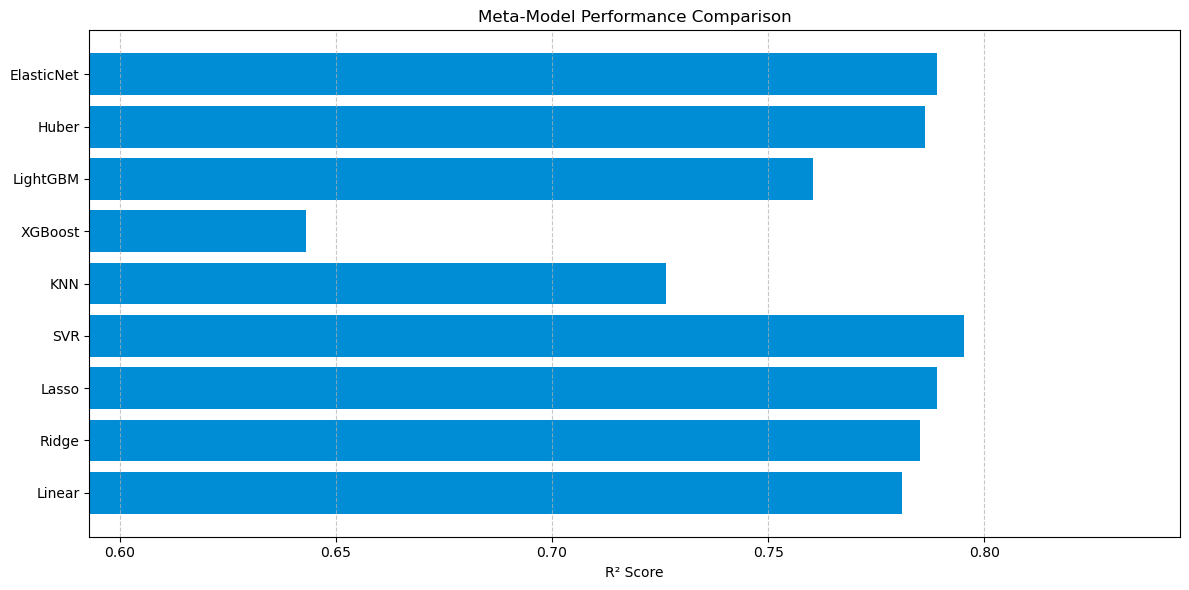

In [73]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, RANSACRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# 数据加载和预处理部分保持不变
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# 计算AtomPair指纹
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# 计算RDKit描述符
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# 特征工程
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# 对齐有效索引
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# 合并特征
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# 处理NaN值
X_combined = np.nan_to_num(X_combined)

# 数据划分 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# 创建预处理管道
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# 假设已经训练好基模型 hgb_model, rf_model, gb_model
# 如果没有，请先训练这些模型

# 定义基模型
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# 定义元模型候选集
meta_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=0.5),
    'Lasso': Lasso(alpha=0.01),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=3),
    'LightGBM': LGBMRegressor(n_estimators=100),
    'Huber': HuberRegressor(),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5)
}

# 评估不同元模型性能
print("\nEvaluating Meta-Models Performance:")
best_score = -np.inf
best_meta_name = ""

for name, meta_model in meta_models.items():
    stack = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    # 5折交叉验证
    scores = cross_val_score(stack, X_train, y_train, 
                           cv=5, scoring='r2', n_jobs=-1)
    mean_r2 = np.mean(scores)
    
    print(f"{name:<10} | Mean R²: {mean_r2:.4f} (±{np.std(scores):.4f})")
    
    if mean_r2 > best_score:
        best_score = mean_r2
        best_meta_name = name

print(f"\nBest Meta-Model: {best_meta_name} with R²: {best_score:.4f}")

# 使用最佳元模型构建最终Stacking模型
final_stack = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_models[best_meta_name],
    cv=5,
    n_jobs=-1
)

# 训练最终模型
final_stack.fit(X_train, y_train)

# 评估测试集
test_pred = final_stack.predict(X_test)
test_r2 = r2_score(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("\nFinal Stacking Model Performance:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# 保存模型
joblib.dump(final_stack, r'D:\Menin\joblibpipeline\stacking_model.pkl')

# 可视化元模型性能比较
plt.figure(figsize=(12, 6))
model_names = list(meta_models.keys())
r2_scores = [np.mean(cross_val_score(
    StackingRegressor(estimators=base_models, final_estimator=m, cv=5),
    X_train, y_train, cv=5, scoring='r2')) for m in meta_models.values()]

plt.barh(model_names, r2_scores, color='#008DD5')
plt.xlabel('R² Score')
plt.title('Meta-Model Performance Comparison')
plt.xlim([min(r2_scores)-0.05, max(r2_scores)+0.05])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('D:/Menin/figures/meta_model_comparison.png', dpi=300)
plt.show()

# 添加与之前相同的性能可视化代码（如果需要）


Calculating RDKit descriptors...


[20:55:20] DEPRECATION WARNING: please use MorganGenerator
[20:55:20] DEPRECATION WARNING: please use MorganGenerator
[20:55:20] DEPRECATION WARNING: please use MorganGenerator
[20:55:20] DEPRECATION WARNING: please use MorganGenerator
[20:55:20] DEPRECATION WARNING: please use MorganGenerator
[20:55:20] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:21] DEPRECATION WARNING: please use MorganGenerator
[20:55:22] DEPRECATION WARNING: please use MorganGenerator
[20:55:22] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...


[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:56:05] DEPRECATION W

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10003
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1036
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

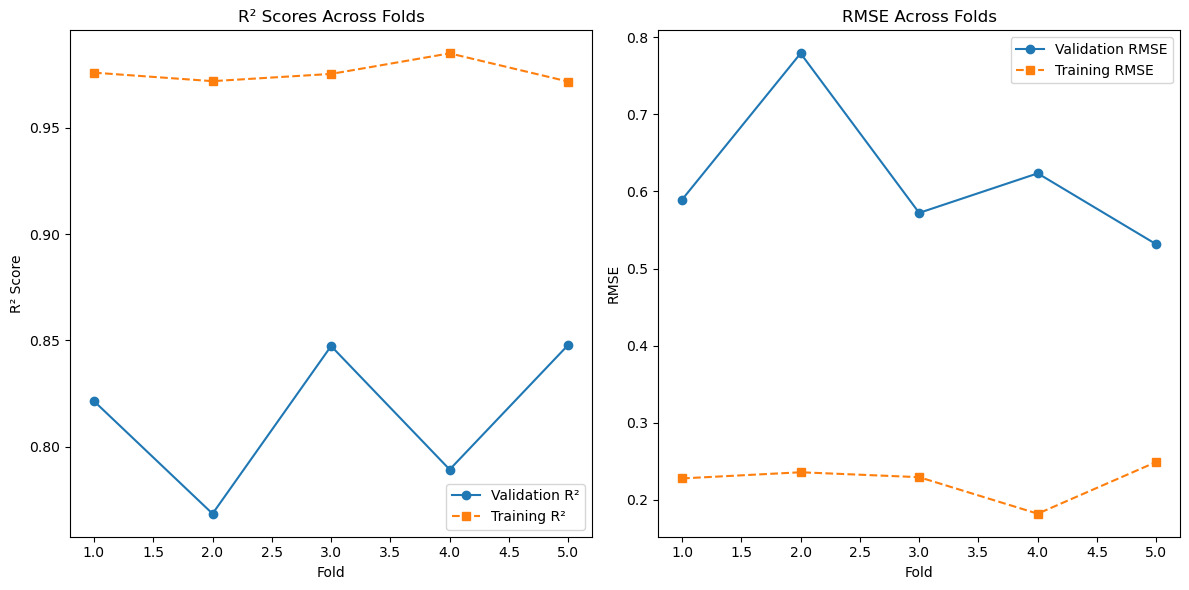

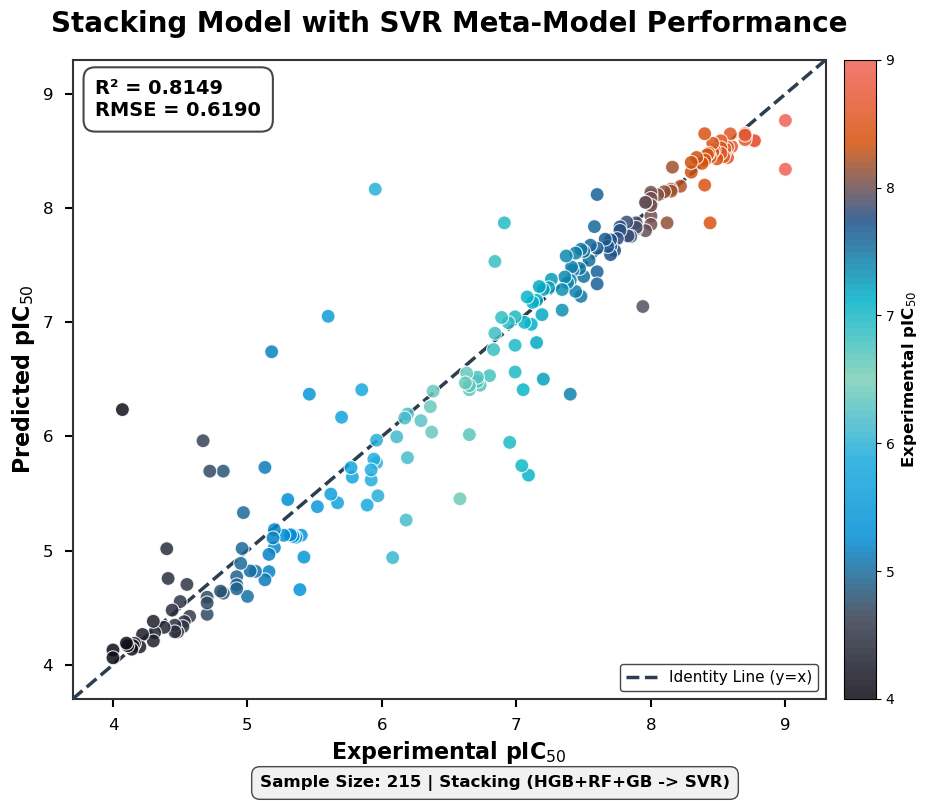


Final Model Performance:
Cross-Validation R²: 0.8149
Cross-Validation RMSE: 0.6190
All Data R²: 0.9144
All Data RMSE: 0.4241
Performance chart saved to: D:/Menin/figures/stacking_svr_performance.png


In [87]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.base import clone
from matplotlib.colors import LinearSegmentedColormap

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Load data
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# Calculate AtomPair fingerprints
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# Calculate RDKit descriptors
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define base models
hgb_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train base models
print("\nTraining base models...")
hgb_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

# Define base models for stacking
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Create optimized SVR meta-model
svr_meta = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.1)

# Create Stacking model with SVR as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=svr_meta,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Use only base model predictions as features
)

# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for Stacking Model with SVR...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create Stacking model with current models
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=clone(svr_meta),
        cv=5,
        n_jobs=-1
    )
    
    # Train
    current_stack.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Final model training and evaluation
print("\nTraining final stacking model with SVR meta-model on full training set...")
stacking_model.fit(X_train_preprocessed, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test_preprocessed)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nTest Set Performance:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Save the model
print("\nSaving the model...")
joblib.dump(stacking_model, 'stacking_model_svr_meta.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of predictions vs actual values
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Predict on all data using the stacking model
y_all_pred = stacking_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))
cv_r2 = mean_val_r2
cv_rmse = mean_val_rmse

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('Stacking Model with SVR Meta-Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Stacking (HGB+RF+GB -> SVR)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/stacking_svr_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Model Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/stacking_svr_performance.png")


Calculating RDKit descriptors...


[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:13] DEPRECATION WARNING: please use MorganGenerator
[20:57:14] DEPRECATION WARNING: please use MorganGenerator
[20:57:14] DEPRECATION WARNING: please use MorganGenerator
[20:57:14] DEPRECATION WARNING: please use MorganGenerator
[20:57:14] DEPRECATION WARNING: please use MorganGenerator
[20:57:14] DEPRECATION WARNING: please use MorganGenerator
[20:57:14] DEPRECATION WARNING: please use MorganGenerator
[20:57:15] DEPRECATION WARNING: please use MorganGenerator
[20:57:15] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...


[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION WARNING: please use AtomPairGenerator
[20:57:57] DEPRECATION W

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10003
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1036
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

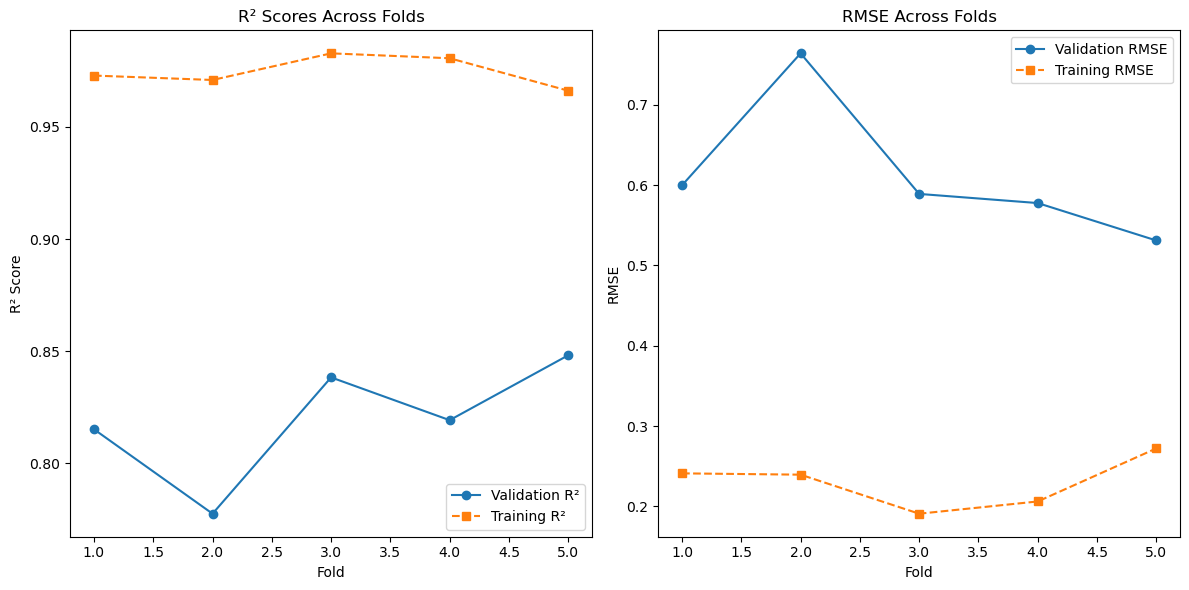

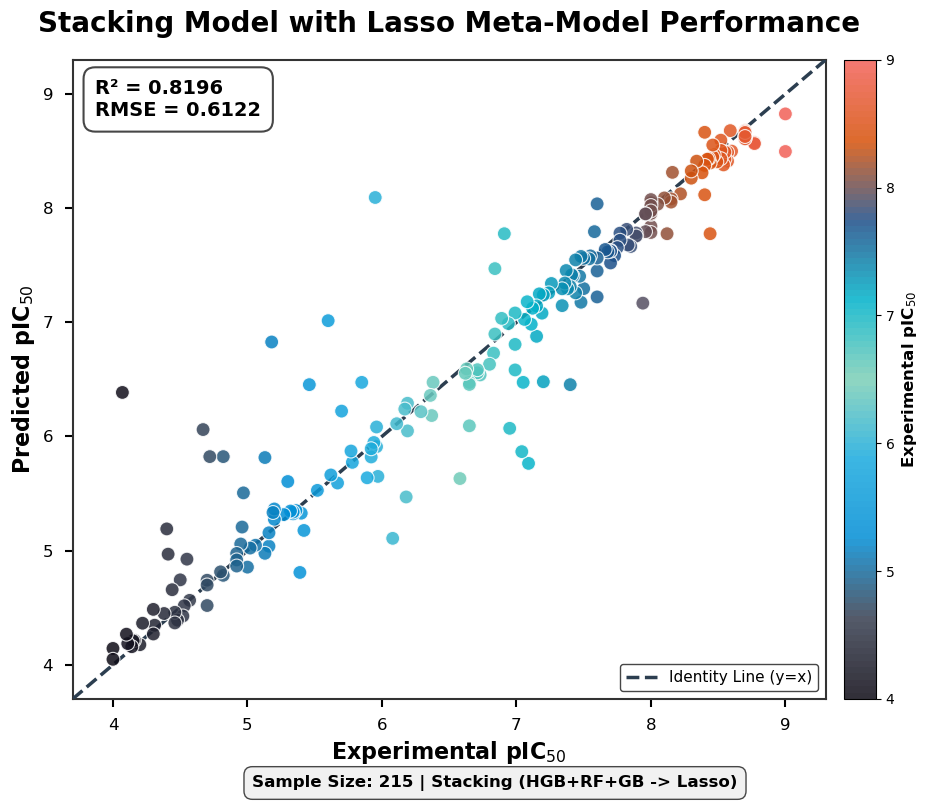


Final Model Performance:
Cross-Validation R²: 0.8196
Cross-Validation RMSE: 0.6122
All Data R²: 0.9193
All Data RMSE: 0.4118
Performance chart saved to: D:/Menin/figures/stacking_lasso_performance.png


In [89]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
import numpy as np
import joblib
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.base import clone
from matplotlib.colors import LinearSegmentedColormap

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Load data
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# Calculate AtomPair fingerprints
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# Calculate RDKit descriptors
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define base models
hgb_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train base models
print("\nTraining base models...")
hgb_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

# Define base models for stacking
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Create optimized Lasso meta-model
lasso_meta = Lasso(alpha=0.01, max_iter=10000, random_state=42)

# Create Stacking model with Lasso as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=lasso_meta,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Use only base model predictions as features
)

# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for Stacking Model with Lasso...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create Stacking model with current models
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=clone(lasso_meta),
        cv=5,
        n_jobs=-1
    )
    
    # Train
    current_stack.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Final model training and evaluation
print("\nTraining final stacking model with Lasso meta-model on full training set...")
stacking_model.fit(X_train_preprocessed, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test_preprocessed)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nTest Set Performance:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Save the model
print("\nSaving the model...")
joblib.dump(stacking_model, 'stacking_model_lasso_meta.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of predictions vs actual values
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Predict on all data using the stacking model
y_all_pred = stacking_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))
cv_r2 = mean_val_r2
cv_rmse = mean_val_rmse

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('Stacking Model with Lasso Meta-Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Stacking (HGB+RF+GB -> Lasso)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/stacking_lasso_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Model Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/stacking_lasso_performance.png")


Calculating RDKit descriptors...


[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:23] DEPRECATION WARNING: please use MorganGenerator
[21:04:24] DEPRECATION WARNING: please use MorganGenerator
[21:04:24] DEPRECATION WARNING: please use MorganGenerator
[21:04:24] DEPRECATION WARNING: please use MorganGenerator
[21:04:24] DEPRECATION WARNING: please use MorganGenerator
[21:04:24] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...


[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[21:05:05] DEPRECATION W

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10003
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1036
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

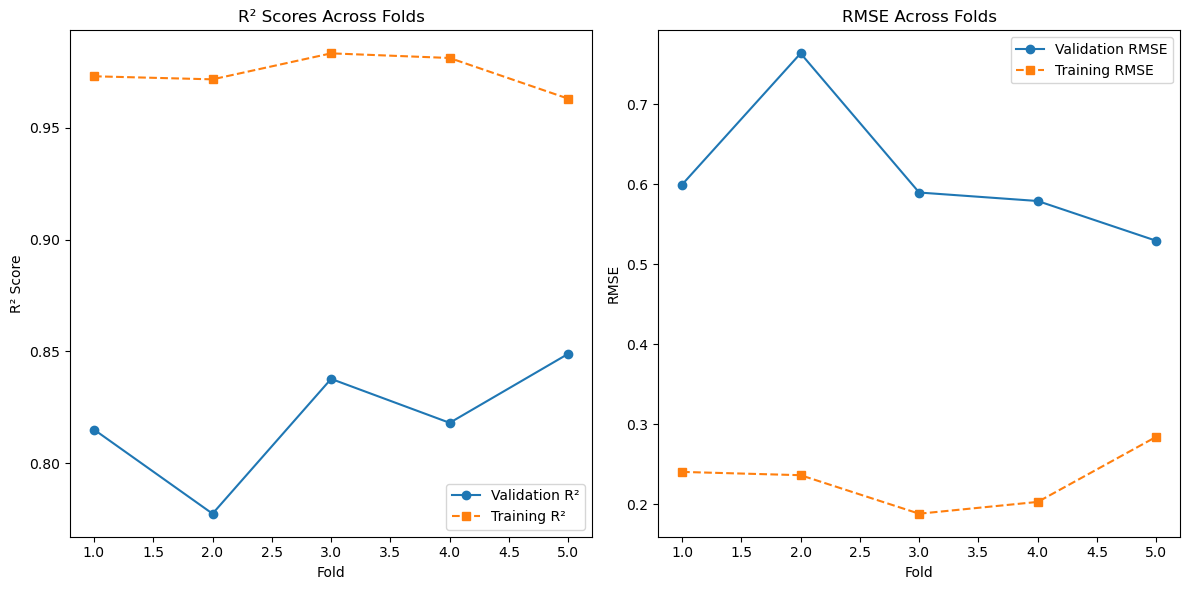

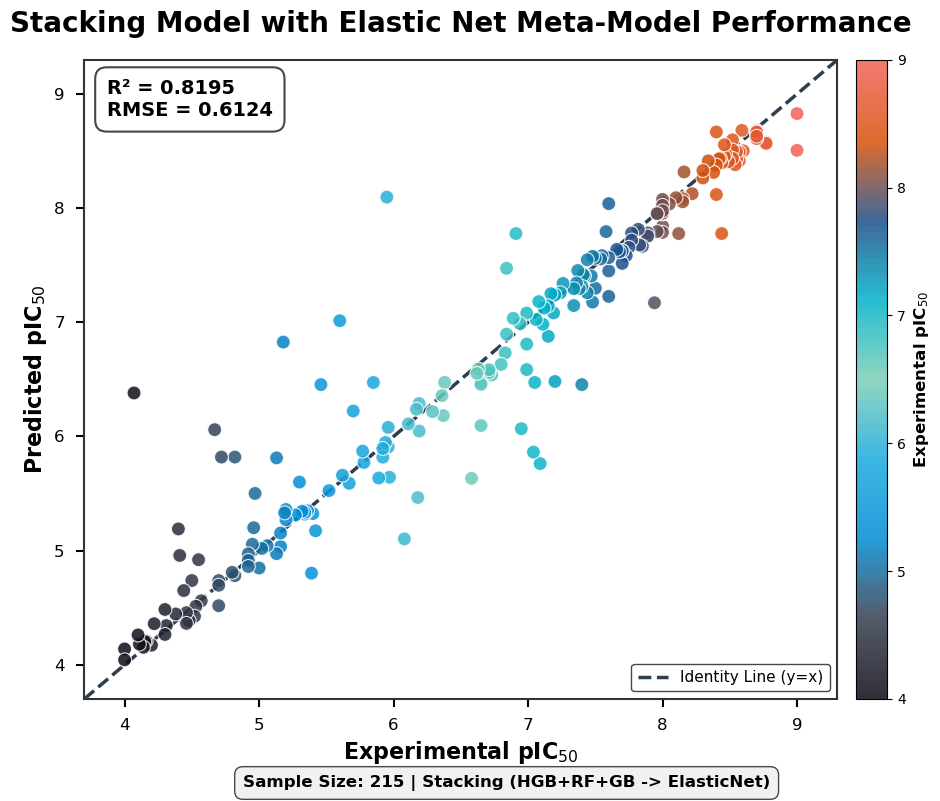


Final Model Performance:
Cross-Validation R²: 0.8195
Cross-Validation RMSE: 0.6124
All Data R²: 0.9194
All Data RMSE: 0.4114
Performance chart saved to: D:/Menin/figures/stacking_elasticnet_performance.png


In [91]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.base import clone
import joblib
import warnings
from matplotlib.colors import LinearSegmentedColormap

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Load data
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# Calculate AtomPair fingerprints
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# Calculate RDKit descriptors
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define base models
hgb_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train base models
print("\nTraining base models...")
hgb_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

# Define base models for stacking
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Create optimized Elastic Net meta-model
elastic_net_meta = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)

# Create Stacking model with Elastic Net as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=elastic_net_meta,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Use only base model predictions as features
)

# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for Stacking Model with Elastic Net...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create Stacking model with current models
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42),
        cv=5,
        n_jobs=-1
    )
    
    # Train
    current_stack.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Final model training and evaluation
print("\nTraining final stacking model with Elastic Net meta-model on full training set...")
stacking_model.fit(X_train_preprocessed, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test_preprocessed)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nTest Set Performance:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Save the model
print("\nSaving the model...")
joblib.dump(stacking_model, 'stacking_model_elasticnet.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of predictions vs actual values
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Predict on all data using the stacking model
y_all_pred = stacking_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))
cv_r2 = mean_val_r2
cv_rmse = mean_val_rmse

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('Stacking Model with Elastic Net Meta-Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Stacking (HGB+RF+GB -> ElasticNet)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/stacking_elasticnet_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Model Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/stacking_elasticnet_performance.png")


Calculating RDKit descriptors...


[21:11:22] DEPRECATION WARNING: please use MorganGenerator
[21:11:22] DEPRECATION WARNING: please use MorganGenerator
[21:11:22] DEPRECATION WARNING: please use MorganGenerator
[21:11:22] DEPRECATION WARNING: please use MorganGenerator
[21:11:22] DEPRECATION WARNING: please use MorganGenerator
[21:11:22] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:23] DEPRECATION WARNING: please use MorganGenerator
[21:11:24] DEPRECATION WARNING: please use MorganGenerator
[21:11:24] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10003
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1036
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION WARNING: please use AtomPairGenerator
[21:12:10] DEPRECATION W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

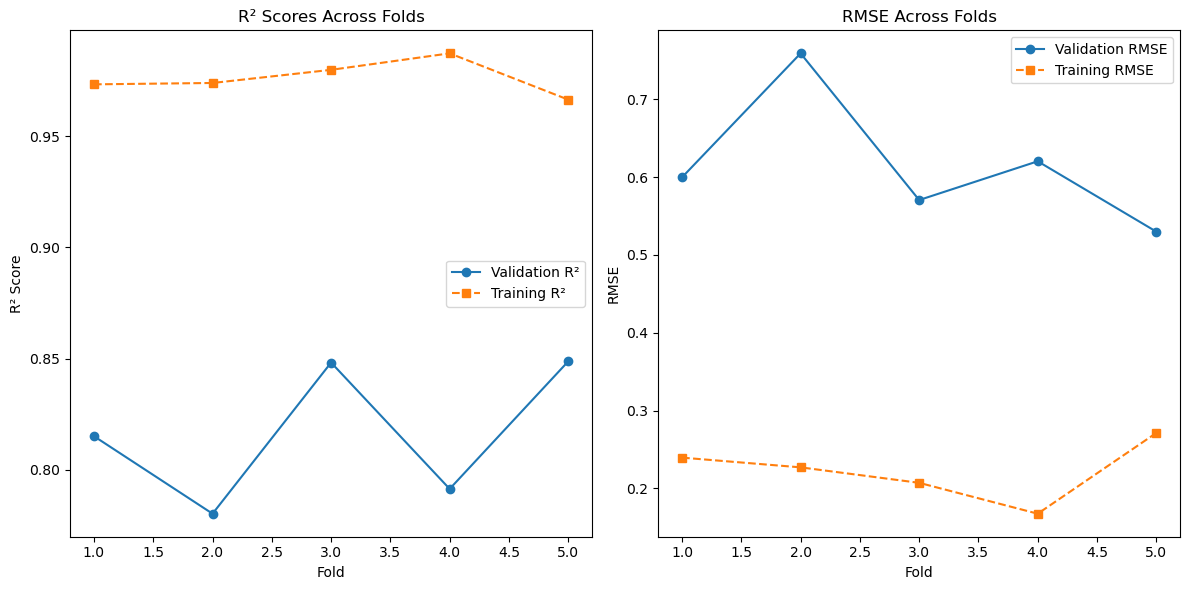

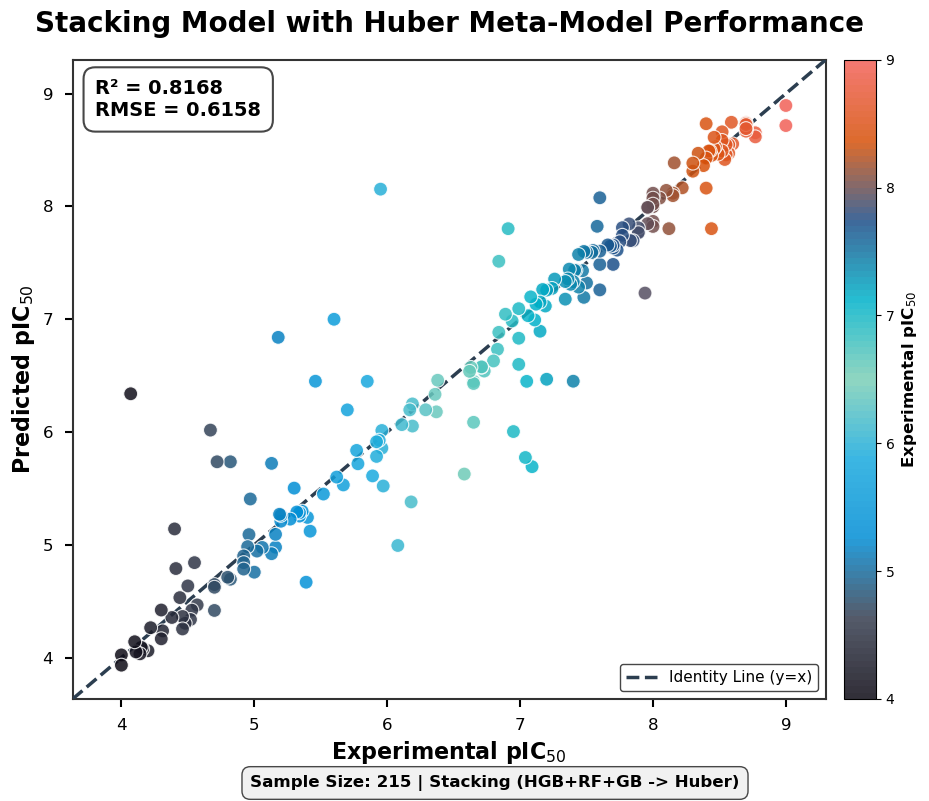


Final Model Performance:
Cross-Validation R²: 0.8168
Cross-Validation RMSE: 0.6158
All Data R²: 0.9192
All Data RMSE: 0.4120
Performance chart saved to: D:/Menin/figures/stacking_huber_performance.png


In [93]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import HuberRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.base import clone
import joblib
import warnings
from matplotlib.colors import LinearSegmentedColormap

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Load data
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# Calculate AtomPair fingerprints
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# Calculate RDKit descriptors
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define base models
hgb_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train base models
print("\nTraining base models...")
hgb_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

# Define base models for stacking
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Create optimized Huber meta-model
huber_meta = HuberRegressor(epsilon=1.35, max_iter=1000, alpha=0.0001)

# Create Stacking model with Huber as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=huber_meta,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Use only base model predictions as features
)

# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for Stacking Model with Huber...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create Stacking model with current models
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=HuberRegressor(epsilon=1.35, max_iter=1000, alpha=0.0001),
        cv=5,
        n_jobs=-1
    )
    
    # Train
    current_stack.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Final model training and evaluation
print("\nTraining final stacking model with Huber meta-model on full training set...")
stacking_model.fit(X_train_preprocessed, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test_preprocessed)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nTest Set Performance:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Save the model
print("\nSaving the model...")
joblib.dump(stacking_model, 'stacking_model_huber.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of predictions vs actual values
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Predict on all data using the stacking model
y_all_pred = stacking_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))
cv_r2 = mean_val_r2
cv_rmse = mean_val_rmse

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('Stacking Model with Huber Meta-Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Stacking (HGB+RF+GB -> Huber)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/stacking_huber_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Model Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/stacking_huber_performance.png")


Calculating RDKit descriptors...


[21:19:40] DEPRECATION WARNING: please use MorganGenerator
[21:19:40] DEPRECATION WARNING: please use MorganGenerator
[21:19:40] DEPRECATION WARNING: please use MorganGenerator
[21:19:40] DEPRECATION WARNING: please use MorganGenerator
[21:19:40] DEPRECATION WARNING: please use MorganGenerator
[21:19:40] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:41] DEPRECATION WARNING: please use MorganGenerator
[21:19:42] DEPRECATION WARNING: please use MorganGenerator
[21:19:42] DEPRECATION WARNING: please use MorganGenerat

Calculating AtomPair fingerprints...


[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION WARNING: please use AtomPairGenerator
[21:20:24] DEPRECATION W

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10003
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1036
[LightGBM] [Info] Start training from score 6.766337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

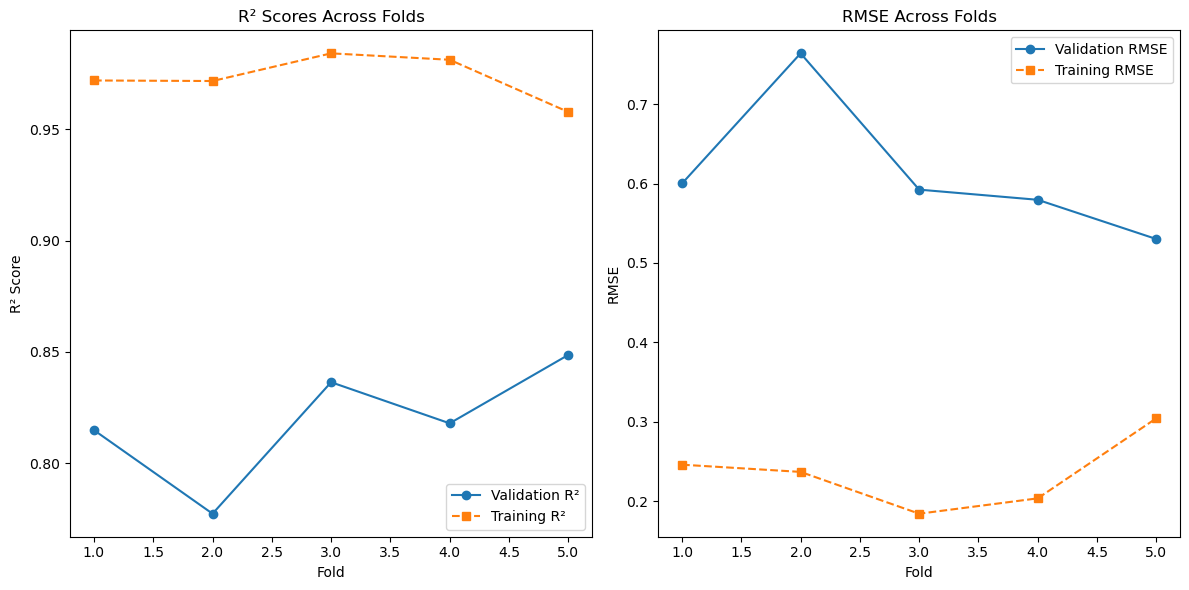

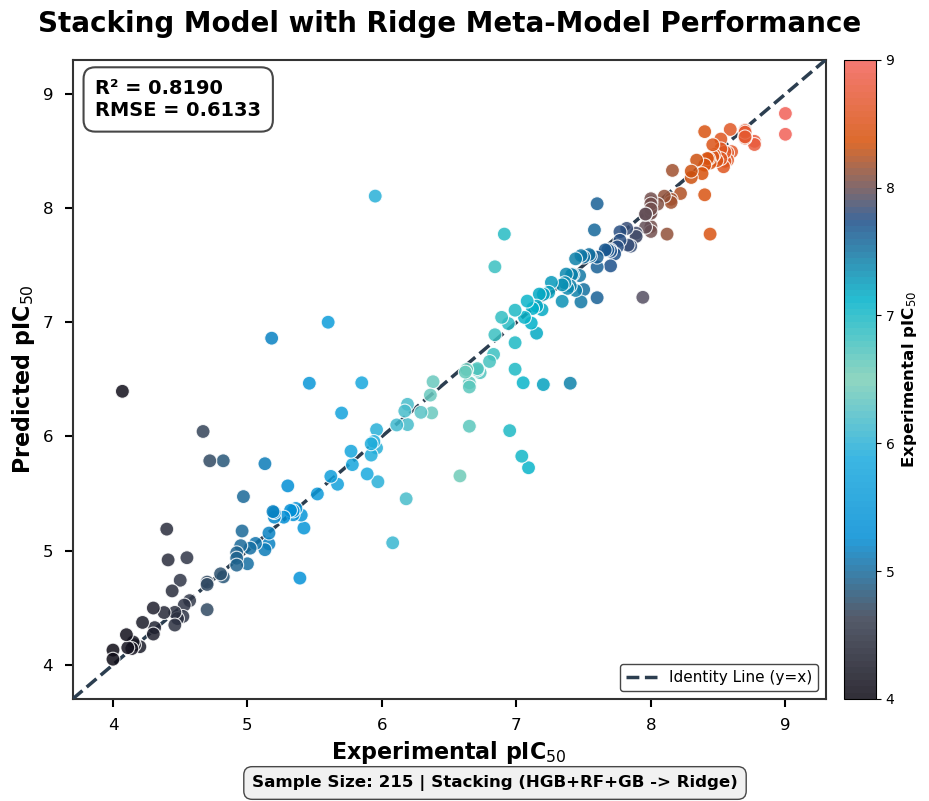


Final Model Performance:
Cross-Validation R²: 0.8190
Cross-Validation RMSE: 0.6133
All Data R²: 0.9195
All Data RMSE: 0.4111
Performance chart saved to: D:/Menin/figures/stacking_ridge_performance.png


In [95]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.base import clone
import joblib
import warnings
from matplotlib.colors import LinearSegmentedColormap

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Load data
file_path = r'D:\Menin\excelcsv\menin200more.csv'
data = pd.read_csv(file_path)
smiles = data['Smiles']
pIC50 = data['pIC50']

# Calculate AtomPair fingerprints
def calculate_atom_pair_fingerprints(smiles_list, n_bits=2048):
    fps = []
    valid_indices = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = Pairs.GetHashedAtomPairFingerprint(mol, nBits=n_bits)
            arr = np.zeros((n_bits,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            valid_indices.append(i)
    
    return np.array(fps), valid_indices

# Calculate RDKit descriptors
def calculate_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    descriptors = calc.CalcDescriptors(mol)
    
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        descriptors += list(rdMolDescriptors.CalcAUTOCORR3D(mol))
        descriptors += list(rdMolDescriptors.CalcRDF(mol))
        descriptors += list(rdMolDescriptors.CalcWHIM(mol))
    except:
        pass
    
    return np.array(descriptors)

# Feature engineering
print("Calculating RDKit descriptors...")
descriptors_list = [calculate_rdkit_descriptors(s) for s in smiles]
valid_indices_desc = [i for i, desc in enumerate(descriptors_list) if desc is not None]

print("Calculating AtomPair fingerprints...")
ap_fps, valid_indices_fp = calculate_atom_pair_fingerprints(smiles)
valid_indices = list(set(valid_indices_desc) & set(valid_indices_fp))

# Align valid indices
X_desc = np.array([descriptors_list[i] for i in valid_indices])
X_fp = ap_fps[np.array([valid_indices_fp.index(i) for i in valid_indices])]

# Combine features
X_combined = np.concatenate((X_fp, X_desc), axis=1)
y = pIC50.iloc[valid_indices].values

# Handle NaN values
X_combined = np.nan_to_num(X_combined)

# Data split (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05)),
    ('selector', SelectFromModel(
        estimator=LGBMRegressor(n_estimators=50, random_state=42),
        max_features=200
    ))
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define base models
hgb_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train base models
print("\nTraining base models...")
hgb_model.fit(X_train_preprocessed, y_train)
rf_model.fit(X_train_preprocessed, y_train)
gb_model.fit(X_train_preprocessed, y_train)

# Define base models for stacking
base_models = [
    ('hgb', hgb_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

# Create optimized Ridge meta-model
ridge_meta = Ridge(alpha=0.5, solver='auto', random_state=42)

# Create Stacking model with Ridge as meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=ridge_meta,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Use only base model predictions as features
)

# 5-Fold Cross Validation with detailed metrics
print("\nRunning 5-Fold Cross Validation for Stacking Model with Ridge...")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Clone models to ensure fresh start for each fold
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # Create Stacking model with current models
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=Ridge(alpha=0.5, solver='auto', random_state=42),
        cv=5,
        n_jobs=-1
    )
    
    # Train
    current_stack.fit(X_tr, y_tr)
    
    # Predictions
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # Calculate metrics
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store results
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# Calculate mean metrics
mean_train_r2 = np.mean(fold_results['train_r2'])
mean_val_r2 = np.mean(fold_results['val_r2'])
mean_train_rmse = np.mean(fold_results['train_rmse'])
mean_val_rmse = np.mean(fold_results['val_rmse'])

# Calculate standard deviations
std_train_r2 = np.std(fold_results['train_r2'])
std_val_r2 = np.std(fold_results['val_r2'])
std_train_rmse = np.std(fold_results['train_rmse'])
std_val_rmse = np.std(fold_results['val_rmse'])

# Print summary
print("\n\nCross-Validation Summary:")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Validation':>15}")
print(f"{'R²':<15} {f'{mean_train_r2:.4f} ± {std_train_r2:.4f}':>15} {f'{mean_val_r2:.4f} ± {std_val_r2:.4f}':>15}")
print(f"{'RMSE':<15} {f'{mean_train_rmse:.4f} ± {std_train_rmse:.4f}':>15} {f'{mean_val_rmse:.4f} ± {std_val_rmse:.4f}':>15}")
print("="*50)

# Final model training and evaluation
print("\nTraining final stacking model with Ridge meta-model on full training set...")
stacking_model.fit(X_train_preprocessed, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test_preprocessed)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nTest Set Performance:")
print(f"R²: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Save the model
print("\nSaving the model...")
joblib.dump(stacking_model, 'stacking_model_ridge.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Plotting cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fold_results['fold'], fold_results['val_r2'], 'o-', label='Validation R²')
plt.plot(fold_results['fold'], fold_results['train_r2'], 's--', label='Training R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² Scores Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_results['fold'], fold_results['val_rmse'], 'o-', label='Validation RMSE')
plt.plot(fold_results['fold'], fold_results['train_rmse'], 's--', label='Training RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of predictions vs actual values
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Predict on all data using the stacking model
y_all_pred = stacking_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))
cv_r2 = mean_val_r2
cv_rmse = mean_val_rmse

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('Stacking Model with Ridge Meta-Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Stacking (HGB+RF+GB -> Ridge)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/stacking_ridge_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Model Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/stacking_ridge_performance.png")


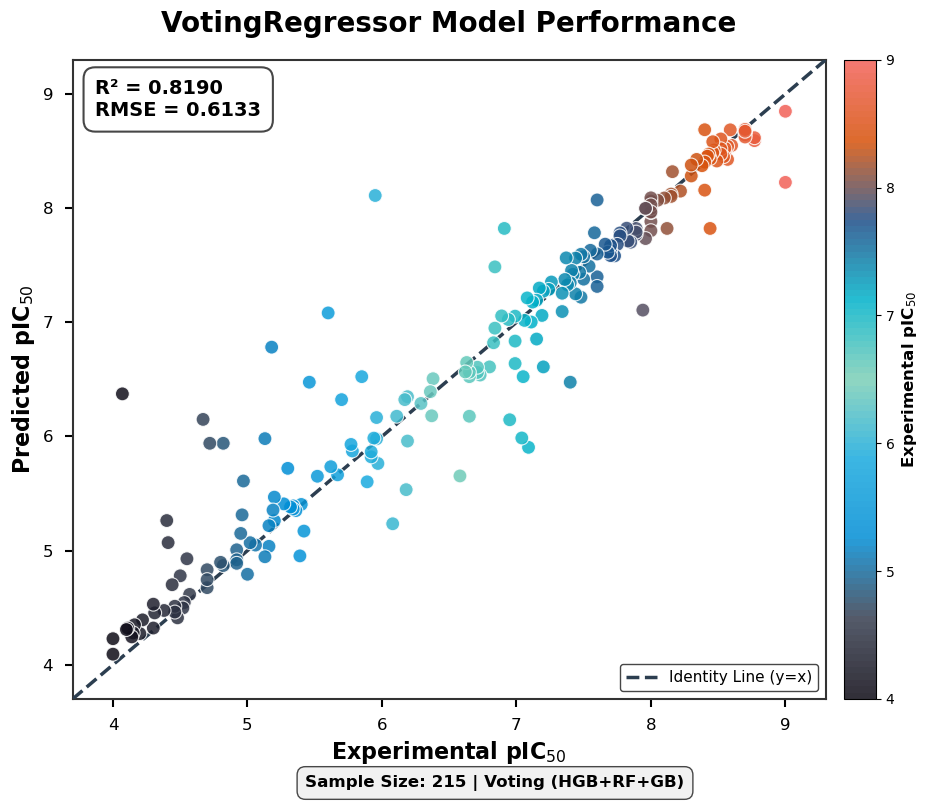


VotingRegressor Performance:
Cross-Validation R²: 0.8190
Cross-Validation RMSE: 0.6133
All Data R²: 0.9172
All Data RMSE: 0.4170
Performance chart saved to: D:/Menin/figures/voting_model_performance.png


In [96]:
# Visualization of predictions vs actual values for VotingRegressor
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# Create VotingRegressor with optimized weights
voting_model = VotingRegressor(
    estimators=[
        ('hgb', hgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    weights=[1, 1, 1],  # Equal weights or use your optimized weights
    n_jobs=-1
)

# Fit the voting model
voting_model.fit(X_train_preprocessed, y_train)

# Predict on all data using the voting model
y_all_pred = voting_model.predict(preprocessor.transform(X_combined))

# Calculate metrics
all_r2 = r2_score(y, y_all_pred)
all_rmse = np.sqrt(mean_squared_error(y, y_all_pred))

# Get cross-validation metrics from your previous analysis
cv_r2 = mean_val_r2  # Replace with your actual CV R² if different
cv_rmse = mean_val_rmse  # Replace with your actual CV RMSE if different

# Color scheme
colors = ['#0E0B16', '#373F51', '#008DD5', '#19AADE', '#7DCFB6', '#00B2CA', '#1D4E89', '#D65108', '#F26157']
custom_cmap = LinearSegmentedColormap.from_list('custom_scientific', colors, N=100)

# Create figure
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot(111)
ax.set_facecolor('white')

# Customize spines
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# Scatter plot
scatter = ax.scatter(y, y_all_pred, 
                    c=y, cmap=custom_cmap, 
                    alpha=0.85, s=100, 
                    edgecolor='white', linewidth=0.8,
                    zorder=5)

# Add diagonal line
min_val = min(min(y), min(y_all_pred)) - 0.3
max_val = max(max(y), max(y_all_pred)) + 0.3
ax.plot([min_val, max_val], [min_val, max_val], 
        color='#2C3E50', linestyle='--', linewidth=2.5, zorder=4,
        label='Identity Line (y=x)')

# Set axis limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# Labels and title
ax.set_xlabel('Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
ax.set_title('VotingRegressor Model Performance', 
             fontsize=20, fontweight='bold', pad=20)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, pad=8)

# Add metrics box
stats_text = (f'R² = {cv_r2:.4f}\n'
              f'RMSE = {cv_rmse:.4f}')
ax.text(0.03, 0.97, stats_text, 
        transform=ax.transAxes, 
        fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, 
                 boxstyle='round,pad=0.6', 
                 edgecolor='#333333', linewidth=1.5),
        verticalalignment='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Experimental pIC$_{50}$', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='lower right', fontsize=11, frameon=True, 
         framealpha=0.9, edgecolor='#333333')

# Remove grid
ax.grid(False)

# Add sample info
fig.text(0.5, 0.01, f"Sample Size: {len(y)} | Voting (HGB+RF+GB)", 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5', 
                 edgecolor='#333333', linewidth=1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
plt.savefig('D:/Menin/figures/voting_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVotingRegressor Performance:")
print(f"Cross-Validation R²: {cv_r2:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
print(f"All Data R²: {all_r2:.4f}")
print(f"All Data RMSE: {all_rmse:.4f}")
print(f"Performance chart saved to: D:/Menin/figures/voting_model_performance.png")


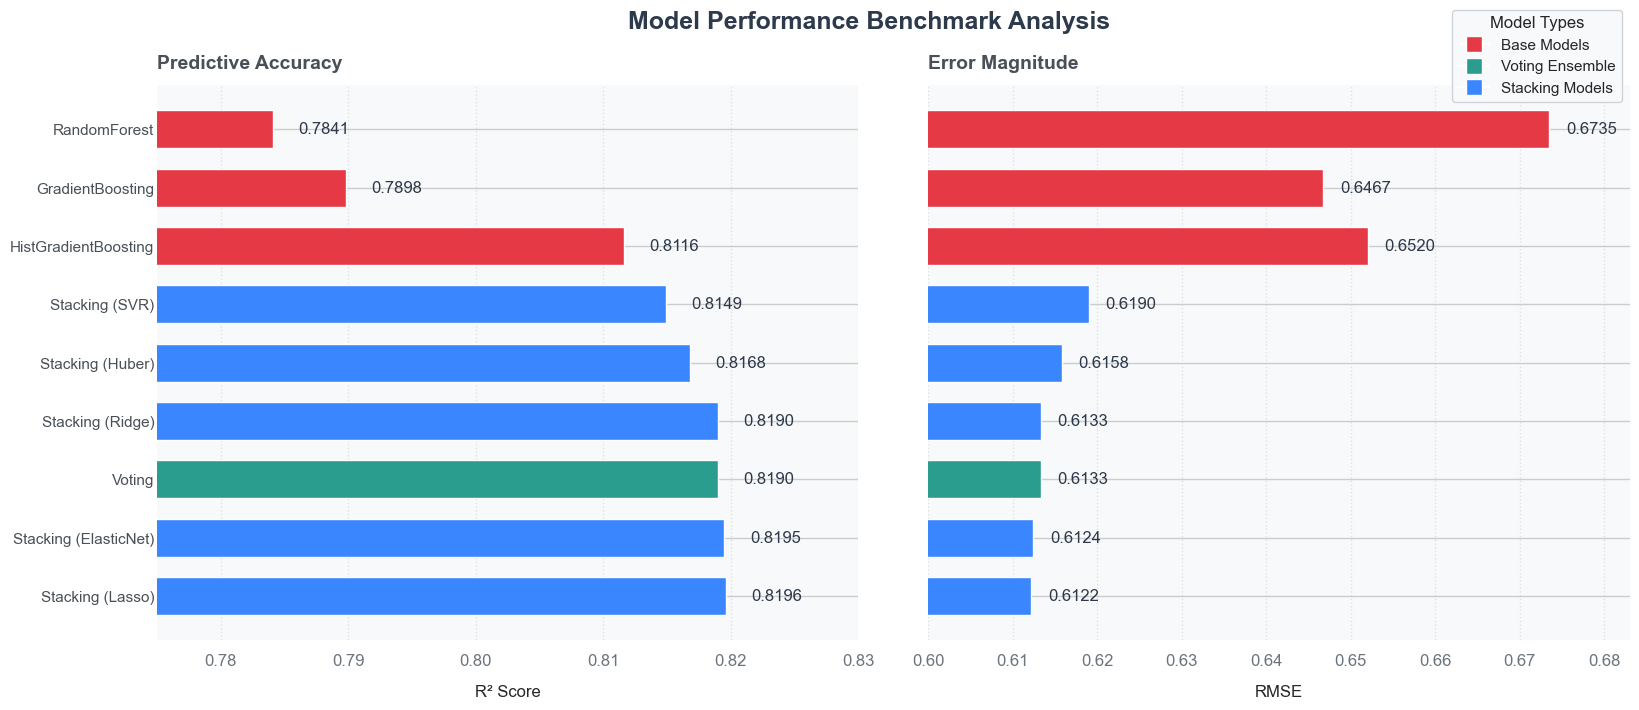

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os

# 专业字体配置
plt.rcParams.update({
    'font.family': 'Arial',
    'axes.titleweight': 'bold',
    'axes.labelweight': 'medium',
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

# 数据准备
models = [
    'GradientBoosting', 'RandomForest', 'HistGradientBoosting',
    'Voting', 'Stacking (SVR)', 'Stacking (Lasso)',
    'Stacking (ElasticNet)', 'Stacking (Huber)', 'Stacking (Ridge)'
]

r2_scores = [
    0.7898, 0.7841, 0.8116, 0.8190, 0.8149, 
    0.8196, 0.8195, 0.8168, 0.8190
]

rmse_scores = [
    0.6467, 0.6735, 0.6520, 0.6133, 0.6190,
    0.6122, 0.6124, 0.6158, 0.6133
]

df = pd.DataFrame({
    'Model': models,
    'R2': r2_scores,
    'RMSE': rmse_scores
}).sort_values('R2', ascending=False)

# 可视化设置
sns.set_theme(style="whitegrid", rc={'axes.facecolor': '#F8F9FA'})
palette = {
    'Base Models': '#E63946',      # 现代红
    'Voting Ensemble': '#2A9D8F',  # 青绿色
    'Stacking Models': '#3A86FF'   # 深蓝
}

# 创建紧凑画布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 7.5), sharey=True)  # 减小高度
fig.subplots_adjust(wspace=0.1, top=0.85)  # 调整顶部空间

# 主标题居中显示
fig.suptitle('Model Performance Benchmark Analysis', 
            x=0.5, y=0.95,  # 调整标题位置
            fontsize=18, 
            color='#2D3A4C',
            fontweight='bold')

# 动态颜色映射
color_mapping = [
    palette['Stacking Models'] if 'Stacking' in m else
    palette['Voting Ensemble'] if m == 'Voting' else
    palette['Base Models'] for m in df.Model
]

# 优化子图布局 ------------------------------------------------------------
# R² 子图
ax1.set_xlim(0.775, 0.830)  # 精确调整范围
bars1 = ax1.barh(df.Model, df.R2, 
                color=color_mapping, 
                height=0.65,  # 更紧凑的高度
                edgecolor='white',
                linewidth=1)
ax1.set_xlabel('R² Score', labelpad=12)
ax1.set_title('Predictive Accuracy', 
             loc='left', pad=12, 
             fontsize=14, color='#495057')

# RMSE 子图
ax2.set_xlim(0.60, 0.683)
bars2 = ax2.barh(df.Model, df.RMSE, 
                color=color_mapping, 
                height=0.65,
                edgecolor='white',
                linewidth=1)
ax2.set_xlabel('RMSE', labelpad=12)
ax2.set_title('Error Magnitude', 
             loc='left', pad=12, 
             fontsize=14, color='#495057')

# 智能标签定位系统
def smart_labels(ax, values):
    for bar, value in zip(ax.patches, values):
        x = min(bar.get_width() + 0.002, ax.get_xlim()[1] - 0.002)
        ax.text(x, bar.get_y() + bar.get_height()/2,
                f'{value:.4f}',
                va='center', ha='left',
                fontsize=12, color='#2D3A4C')

smart_labels(ax1, df.R2)
smart_labels(ax2, df.RMSE)

# 统一装饰元素
for ax in [ax1, ax2]:
    # 优化边框
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis='x', linestyle=':', color='#DEE2E6')
    
    # 刻度优化
    ax.tick_params(axis='x', colors='#6C757D', labelsize=12)
    ax.tick_params(axis='y', length=0, pad=2, colors='#495057')

# 右上角图例系统
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', 
              label='Base Models', markersize=12,
              markerfacecolor=palette['Base Models']),
    plt.Line2D([0], [0], marker='s', color='w',
              label='Voting Ensemble', markersize=12,
              markerfacecolor=palette['Voting Ensemble']),
    plt.Line2D([0], [0], marker='s', color='w',
              label='Stacking Models', markersize=12,
              markerfacecolor=palette['Stacking Models'])
]

# 将图例定位到右上角
ax2.legend(handles=legend_elements,
          loc='upper right',
          bbox_to_anchor=(1.0, 1.15),
          frameon=True,
          framealpha=1,
          edgecolor='#CED4DA',
          title='Model Types',
          title_fontsize=12)

# 保存高清图片
os.makedirs('D:/Menin/figures', exist_ok=True)
plt.savefig('D:/Menin/figures/model_performance_compact.png', 
           dpi=350, 
           bbox_inches='tight',
           facecolor='white',
           transparent=False)

plt.show()


In [137]:
# ... [保留所有导入和预处理代码，直至交叉验证部分] ...

# 修改后的5折交叉验证流程
print("\nRunning 5-Fold Cross Validation for Stacking Model with Lasso...")

# 初始化存储字典（添加验证集数据存储）
fold_results = {
    'fold': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': [],
    'val_y': [],     # 新增验证集真实值存储
    'val_pred': []    # 新增验证集预测值存储
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    print(f"\nFold {fold + 1}/5")
    
    # 重新生成预处理数据（防止数据泄露）
    # 在每折中重新拟合预处理流程
    fold_preprocessor = clone(preprocessor)  # 重要修改：克隆预处理器
    X_tr = fold_preprocessor.fit_transform(X_train[train_idx], y_train[train_idx])
    X_val = fold_preprocessor.transform(X_train[val_idx])
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    
    # 克隆模型（确保每折独立）
    current_hgb = clone(hgb_model)
    current_rf = clone(rf_model)
    current_gb = clone(gb_model)
    
    # 创建新的Stacking模型
    current_stack = StackingRegressor(
        estimators=[
            ('hgb', current_hgb),
            ('rf', current_rf),
            ('gb', current_gb)
        ],
        final_estimator=clone(lasso_meta),
        cv=5,
        n_jobs=-1
    )
    
    # 训练
    current_stack.fit(X_tr, y_tr)
    
    # 预测
    y_tr_pred = current_stack.predict(X_tr)
    y_val_pred = current_stack.predict(X_val)
    
    # 计算指标
    train_r2 = r2_score(y_tr, y_tr_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # 存储结果
    fold_results['fold'].append(fold+1)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    fold_results['val_y'].append(y_val)       # 存储真实值
    fold_results['val_pred'].append(y_val_pred) # 存储预测值
    
    print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

# ... [保留后续的指标计算和模型保存代码] ...

# 修改后的可视化代码（保持原有格式）
def plot_fold_performance(y_true, y_pred, fold_num, save_path=None):
    """绘制单个fold的预测性能图（修正版）"""
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建专业级图表
    fig = plt.figure(figsize=(10, 8), facecolor='white')
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')
    
    # 配置颜色方案
    colors = ['#2E004B', '#5C1A6B', '#8A2BE2', '#FF6B6B', '#FF8C00', '#FFD700']
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
    
    # 绘制散点图
    scatter = ax.scatter(y_true, y_pred, 
                        c=y_true, cmap=cmap,
                        s=80, alpha=0.9,
                        edgecolor='white', linewidth=0.8,
                        zorder=5)
    
    # 添加参考线
    min_val = min(y_true.min(), y_pred.min()) - 0.2
    max_val = max(y_true.max(), y_pred.max()) + 0.2
    ax.plot([min_val, max_val], [min_val, max_val], 
            color='#6A1B9A', linestyle='--', linewidth=2,
            zorder=4, label='Perfect Prediction')
    
    # 设置坐标轴
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # 添加标签和标题
    ax.set_xlabel('Experimental pIC$_{50}$', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted pIC$_{50}$', fontsize=14, fontweight='bold')
    ax.set_title(f'Fold {fold_num} Cross-Validation', fontsize=18, pad=15)
    
    # 添加统计信息
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    stats_text = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.9, 
                     boxstyle='round,pad=0.5', edgecolor='gray'))
    
    # 添加色条
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Experimental Value', fontsize=12)
    
    # 保存图像
    if save_path:
        plt.savefig(f'{save_path}/fold_{fold_num}_cv.png', 
                   dpi=300, bbox_inches='tight')
    plt.close()

# 生成各fold的可视化
print("\nGenerating fold performance plots...")
for i in range(5):
    y_true = fold_results['val_y'][i]
    y_pred = fold_results['val_pred'][i]
    plot_fold_performance(y_true, y_pred, i+1, 'D:/Menin/figures/')
    print(f"Fold {i+1} plot saved to: D:/Menin/figures/fold_{i+1}_cv.png")

# ... [保留其余评估和可视化代码] ...



Running 5-Fold Cross Validation for Stacking Model with Lasso...

Fold 1/5
Train R²: 0.9748 | Val R²: 0.7910
Train RMSE: 0.2326 | Val RMSE: 0.6375

Fold 2/5
Train R²: 0.9689 | Val R²: 0.7295
Train RMSE: 0.2478 | Val RMSE: 0.8420

Fold 3/5
Train R²: 0.9794 | Val R²: 0.8473
Train RMSE: 0.2095 | Val RMSE: 0.5722

Fold 4/5
Train R²: 0.9750 | Val R²: 0.8036
Train RMSE: 0.2345 | Val RMSE: 0.6018

Fold 5/5
Train R²: 0.9760 | Val R²: 0.8405
Train RMSE: 0.2293 | Val RMSE: 0.5441

Generating fold performance plots...
Fold 1 plot saved to: D:/Menin/figures/fold_1_cv.png
Fold 2 plot saved to: D:/Menin/figures/fold_2_cv.png
Fold 3 plot saved to: D:/Menin/figures/fold_3_cv.png
Fold 4 plot saved to: D:/Menin/figures/fold_4_cv.png
Fold 5 plot saved to: D:/Menin/figures/fold_5_cv.png


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import numpy as np

class FeatureProcessor(BaseEstimator, TransformerMixin):
    """自定义特征处理器"""
    def __init__(self, feat_type):
        self.feat_type = feat_type
        # 对于非RDKitDescriptors类型使用方差筛选
        self.selector = VarianceThreshold(threshold=0) if feat_type != 'RDKitDescriptors' else None

    def fit(self, X, y=None):
        if self.feat_type == 'RDKitDescriptors':
            # 剔除缺失率超过50%的列
            self.missing_mask_ = (X.isna().mean() > 0.5).values
            self.remaining_cols_ = X.columns[~self.missing_mask_]
            self.imputer_ = SimpleImputer(strategy='mean').fit(X.loc[:, self.remaining_cols_])
        else:
            self.selector.fit(X)
        return self

    def transform(self, X):
        if self.feat_type == 'RDKitDescriptors':
            X_reduced = X.loc[:, self.remaining_cols_]
            return self.imputer_.transform(X_reduced)
        else:
            return self.selector.transform(X)

def generate_features(smiles, fp_type='Morgan', nBits=2048):
    """分子特征生成统一接口"""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    if fp_type == 'RDKitDescriptors':
        calculator = MoleculeDescriptors.MolecularDescriptorCalculator([d[0] for d in Descriptors.descList])
        return list(calculator.CalcDescriptors(mol))

    fp_switch = {
        'RDKit': lambda: Chem.RDKFingerprint(mol, fpSize=nBits),
        'Morgan': lambda: AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits),
        'Layered': lambda: AllChem.LayeredFingerprint(mol),
        'TopologicalTorsion': lambda: rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nBits),
        'MACCS': lambda: AllChem.GetMACCSKeysFingerprint(mol),
        'AtomPair': lambda: rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits),
        'Avalon': lambda: GetAvalonFP(mol, nBits=nBits)
    }

    fp_generator = fp_switch.get(fp_type, lambda: None)
    if not fp_generator:
        return None
    
    fp = fp_generator()
    return [int(bit) for bit in fp.ToBitString()] if fp else None

def evaluate_features(file_path, target_col='pIC50', feature_types=None, nBits=2048):
    """评估分子特征生成效果，输出R²和RMSE"""
    data = pd.read_csv(file_path)
    results = []

    for feat_type in feature_types:
        features, valid_indices = [], []
        for i, s in enumerate(data['Smiles']):
            feat = generate_features(s, feat_type, nBits)
            if feat is not None:
                features.append(feat)
                valid_indices.append(i)
                
        if not features:  # 跳过没有有效特征的情况
            print(f"特征类型 {feat_type} 没有生成有效特征，跳过...")
            continue
            
        X = pd.DataFrame(features)
        y = data[target_col].iloc[valid_indices]
        
        models = {
            'SVM': make_pipeline(
                FeatureProcessor(feat_type),
                StandardScaler(),
                SVR(kernel='rbf', C=1.0, epsilon=0.2)
            ),
            'RF': make_pipeline(
                FeatureProcessor(feat_type),
                RandomForestRegressor(n_estimators=100, random_state=42)
            ),
            'KNN': make_pipeline(
                FeatureProcessor(feat_type),
                StandardScaler(),
                KNeighborsRegressor()
            )
        }
        
        print(f"\n评估特征类型: {feat_type} | 样本数: {len(y)} | 初始特征数: {X.shape[1]}")
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for model_name, pipeline in models.items():
            try:
                scores = cross_validate(
                    pipeline, X, y, cv=cv,
                    scoring=['r2', 'neg_mean_squared_error'],
                    n_jobs=-1,
                    error_score='raise'
                )
                
                # 计算平均和标准差R²
                avg_r2 = np.mean(scores['test_r2']).round(4)
                std_r2 = np.std(scores['test_r2']).round(4)
                
                # 计算每折的RMSE
                mse_fold = -scores['test_neg_mean_squared_error']  # 转换为正的MSE
                rmse_fold = np.sqrt(mse_fold)
                avg_rmse = np.mean(rmse_fold).round(4)
                std_rmse = np.std(rmse_fold).round(4)
                
                results.append({
                    'FeatureType': feat_type,
                    'Model': model_name,
                    'Avg_R2': avg_r2,
                    'R2_Std': std_r2,
                    'Avg_RMSE': avg_rmse,
                    'RMSE_Std': std_rmse
                })
                
            except Exception as e:
                print(f"{model_name} 失败: {str(e)}")

    report = pd.DataFrame(results)
    print("\n================ 最终报告 ================")
    print(report)
    return report

if __name__ == '__main__':
    # 指定需要评估的特征类型
    feature_types = [
        'RDKit',
        'Morgan',       # 使用Morgan指纹
        'Layered',      # 使用Layered指纹
        'TopologicalTorsion',
        'MACCS',
        'AtomPair',
        'Avalon',
        'RDKitDescriptors'
    ]

    # 修改为实际CSV文件路径
    file_path = r'D:\Menin\excelcsv\menin200more.csv'

    report = evaluate_features(
        file_path=file_path,
        feature_types=feature_types
    )

    # 将最终结果保存为CSV文件
    report.to_csv('evaluation_results.csv', index=False)



评估特征类型: RDKit | 样本数: 215 | 初始特征数: 2048


[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerator
[17:06:42] DEPRECATION WARNING: please use MorganGenerat


评估特征类型: Morgan | 样本数: 215 | 初始特征数: 2048

评估特征类型: Layered | 样本数: 215 | 初始特征数: 2048


[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06:48] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[17:06


评估特征类型: TopologicalTorsion | 样本数: 215 | 初始特征数: 2048

评估特征类型: MACCS | 样本数: 215 | 初始特征数: 167


[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION WARNING: please use AtomPairGenerator
[17:06:50] DEPRECATION W


评估特征类型: AtomPair | 样本数: 215 | 初始特征数: 2048

评估特征类型: Avalon | 样本数: 215 | 初始特征数: 2048


[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerator
[17:06:55] DEPRECATION WARNING: please use MorganGenerat


评估特征类型: RDKitDescriptors | 样本数: 215 | 初始特征数: 210

================ 最终报告 ================
           FeatureType Model  Avg_R2  R2_Std  Avg_RMSE  RMSE_Std
0                RDKit   SVM  0.6965  0.0922    0.7784    0.0972
1                RDKit    RF  0.7338  0.0889    0.7278    0.1103
2                RDKit   KNN  0.7155  0.0998    0.7511    0.1057
3               Morgan   SVM  0.5784  0.0795    0.9260    0.0942
4               Morgan    RF  0.7105  0.0972    0.7577    0.1404
5               Morgan   KNN  0.5882  0.1680    0.9009    0.1667
6              Layered   SVM  0.6848  0.0689    0.7987    0.0818
7              Layered    RF  0.7192  0.0922    0.7499    0.1422
8              Layered   KNN  0.6995  0.0779    0.7776    0.0933
9   TopologicalTorsion   SVM  0.5929  0.0972    0.9067    0.1020
10  TopologicalTorsion    RF  0.6815  0.1081    0.7960    0.1518
11  TopologicalTorsion   KNN  0.6248  0.1335    0.8598    0.1201
12               MACCS   SVM  0.6666  0.1010    0.8165    0.1103
